# Project Overview

## Business Problem

Pada bisnis penginapan atau Hotel untuk permasalahan pembatalan pesanan sudah menjadi permasalahan yang sering terjadi. Hal ini dapat mempengaruhi pendapatan dari hotel atau penginapan

1. Bagaimana tren pembatalan pemesanan hotel? kapan puncaknya terjadi pembatalan pesanan?
2. Kriteria customer apa yang sering membatalkan pesanan?
3. Kriteria hotel dan jenis booking apa yang sering terjadi pembatalan pesanan?
4. Bagaimana status pemesanan terkait dengan kinerja hotel, khususnya dengan ADR (Average Daily Rate)?


## Objective

Memberikan rekomendasi bisnis yang tepat agar meminimalisir pembatalan pesanan hotel sehingga dapat meningkatkan revenue

# Import Library

In [594]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Load Data

In [2]:
df_train = pd.read_csv('data/train.csv')

In [3]:
df_train.head(3)

hotel  is_canceled  lead_time  \
0                   Crystal Cove, Barbados Barbados            0          8   
1               Greensboro Courtyard Greensboro, NC            1        524   
2  The Westin Peachtree Plaza, Atlanta Atlanta, GA             1        175   

   arrival_date_year arrival_date_month  arrival_date_week_number  \
0               2019            January                         2   
1               2018           December                        51   
2               2019                May                        20   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                         10                        0                     4   
1                         15                        0                     2   
2                         19                        1                     2   

   adults  ...  agent  company days_in_waiting_list customer_type    adr  \
0       2  ...  314.0      NaN                    0     Transient   38.4   
1       2  ...    1.0      NaN                    0     Transient   62.8   
2       2  ...   12.0      NaN                    0     Transient  110.0   

  required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                           0                          0           Check-Out   
1                           0                          0            Canceled   
2                           0                          0            Canceled   

   reservation_status_date bookingID  
0               2019-01-14         1  
1               2017-10-21         2  
2               2018-11-25         3  

[3 rows x 33 columns]

In [4]:
df_train['agent'].value_counts()

9.0      22305
240.0     9667
1.0       4943
14.0      2529
7.0       2511
         ...  
337.0        1
352.0        1
299.0        1
446.0        1
144.0        1
Name: agent, Length: 320, dtype: int64

# Data Understanding

## Data Preparation

### General Information

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83293 entries, 0 to 83292
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83293 non-null  object 
 1   is_canceled                     83293 non-null  int64  
 2   lead_time                       83293 non-null  int64  
 3   arrival_date_year               83293 non-null  int64  
 4   arrival_date_month              83293 non-null  object 
 5   arrival_date_week_number        83293 non-null  int64  
 6   arrival_date_day_of_month       83293 non-null  int64  
 7   stays_in_weekend_nights         83293 non-null  int64  
 8   stays_in_week_nights            83293 non-null  int64  
 9   adults                          83293 non-null  int64  
 10  children                        83290 non-null  float64
 11  babies                          83293 non-null  int64  
 12  meal                            

**Dataset Information**

- Jumlah kolom pada data sebanyak 33 kolom 83293 baris

**Description Dataset:**

1. hotel: Type of hotel (Categorical)

2. is_canceled: Whether the booking was canceled or not (Binary)

3. lead_time: Number of days between booking date and arrival date (Numeric)

4. arrival_date_year: The year of the arrival date (Numeric)

5. arrival_date_month: The month of the arrival date (Categorical)

6. arrival_date_week_number: The week number of the arrival date (Numeric)

7. arrival_date_day_of_month: The day of the month of the arrival date (Numeric)

8. stays_in_weekend_nights: Number of weekend nights stayed or booked to stay at the hotel (Numeric)

9. stays_in_week_nights: Number of week nights stayed or booked to stay at the hotel (Numeric)

10. adults, children, babies: Number of guests categorized by age groups:

    - adults = Number of adults
    - children = Number of children
    - babies = Number infants
    
11. Booking Details:

    - meal: Type(s) food option(s) included in booking package (Categorical)
    - country & market_segment & distribution_channel columns provide demographic and customer classification information.
    - is_repeated_guest column specifies whether a guest is a repeated visitor or not.
    - previous_cancellations column indicates how many previous bookings were canceled by a guest.
    - previous_bookings_not_canceled shows how many previous bookings were not canceled by a guest.
    
12. Accommodation Details:

    - reserved_room_type column indicates which type room was originally reserved for each booking.
    - assigned_room_type mentions which type room was finally assigned for each booking.
    - booking_changes: Number of changes made to the booking before arrival.
    - deposit_type: Type of deposit made for the booking (Categorical).
    - agent & company columns provide relevant information about the travel agency and/or company involved in making the reservation.
    
13. Additional Information:

    - days_in_waiting_list: Number of days the booking was on a waiting list before it was confirmed or canceled.
    - customer_type provides information on types of customers (Categorical)
    - adr: Average daily rate per room, calculated by dividing the sum of all lodging transactions by the total number of staying nights (Numeric)
    
14. required_car_parking_spaces : Number of car parking spaces required by the customer

15. total_of_special_requests : Number of special requests made by the customer (e.g. twin bed or high floor)

16. reservation_status : Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why

17. reservation_status_date : Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

18. bookingID : Booking ID each Users

### Type & Number of Unique Values

In [6]:
types = df_train.dtypes
nuniques = df_train.nunique()
types_nunique = pd.concat([types,nuniques], axis = 1, keys = ['types','nunique'])
types_nunique

types  nunique
hotel                            object       64
is_canceled                       int64        2
lead_time                         int64      477
arrival_date_year                 int64        3
arrival_date_month               object       12
arrival_date_week_number          int64       53
arrival_date_day_of_month         int64       31
stays_in_weekend_nights           int64       17
stays_in_week_nights              int64       34
adults                            int64       14
children                        float64        5
babies                            int64        5
meal                             object        5
country                          object      165
market_segment                   object        8
distribution_channel             object        5
is_repeated_guest                 int64        2
previous_cancellations            int64       14
previous_bookings_not_canceled    int64       65
reserved_room_type               object       10
assigned_room_type               object       11
booking_changes                   int64       20
deposit_type                     object        3
agent                           float64      320
company                         float64      327
days_in_waiting_list              int64      122
customer_type                    object        4
adr                             float64     7460
required_car_parking_spaces       int64        5
total_of_special_requests         int64        6
reservation_status               object        3
reservation_status_date          object      914
bookingID                         int64    83293

In [7]:
print('Data Categorical :', len(df_train.select_dtypes('O').columns[:-1]))
print('Data Numerical :', len(df_train.select_dtypes(exclude='O').columns))
print('Data DateTime :', len(df_train.select_dtypes('O').columns[-1:]))

Data Categorical : 11
Data Numerical : 21
Data DateTime : 1


**Observation**

- Data Categorical : 11 kolom
- Data Numerical : 21 Kolom
- Data DateTime : 1 Kolom

1. is_canceled, is_repeated_guest (binary, True or False (1,0))
2. Data Categorical : hotel, arrival_date_month,  meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, agent, company, customer_type, reservation_status
3. Data Numeric Discrete : arrival_date_year, arrival_date_day_of_month, adults, children, babies, required_car_parking_spaces, total_of_special_requests
4. Data Numeric Continous : lead_time, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, adr
5. Data DateTime : reservation_status_date akan dilakukan convert menjadi dateTime karena sebelumnya bertipe object
6. Unique Value : bookingID

### Missing Value Checking

In [8]:
missing_count = df_train.isna().sum()
missing_percent = round(df_train.isna().mean()*100,2)
missing_value = pd.concat([missing_count,missing_percent], axis= 1, keys=['count','percent (%)'])
missing_value

count  percent (%)
hotel                               0         0.00
is_canceled                         0         0.00
lead_time                           0         0.00
arrival_date_year                   0         0.00
arrival_date_month                  0         0.00
arrival_date_week_number            0         0.00
arrival_date_day_of_month           0         0.00
stays_in_weekend_nights             0         0.00
stays_in_week_nights                0         0.00
adults                              0         0.00
children                            3         0.00
babies                              0         0.00
meal                                0         0.00
country                           346         0.42
market_segment                      0         0.00
distribution_channel                0         0.00
is_repeated_guest                   0         0.00
previous_cancellations              0         0.00
previous_bookings_not_canceled      0         0.00
reserved_room_type                  0         0.00
assigned_room_type                  0         0.00
booking_changes                     0         0.00
deposit_type                        0         0.00
agent                           11404        13.69
company                         78559        94.32
days_in_waiting_list                0         0.00
customer_type                       0         0.00
adr                                 0         0.00
required_car_parking_spaces         0         0.00
total_of_special_requests           0         0.00
reservation_status                  0         0.00
reservation_status_date             0         0.00
bookingID                           0         0.00

**Observation**

1. `company` memiliki banyak missing value sehingga akan dilakukan drop column karena tidak memungkinkan untuk drop value dan impute missing value karena akan menimbulkan bias dan kekurangan data
2. `agent` memiliki missing value lebih dari 10% dan merupakan ID travel agent maka akan diisi dengan nilai 0 karena tidak semua bookingan berasal dari agent
3. `country, children` merupakan data kategorikal dan missing value tidak sampai 1 % maka untuk `country` akan diisi dengan country yang frequency paling banyak dan `children` akan diisi dengan nilai 0

### Duplicate Checking

In [9]:
print('Jumlah Duplikat Data Train :', df_train.duplicated(subset = 'bookingID').sum())

Jumlah Duplikat Data Train : 0


**Observation**

Pada dataset tidak terdapat data duplikat

### Data Cleaning

In [10]:
missing_value[missing_value['count']> 0]

count  percent (%)
children      3         0.00
country     346         0.42
agent     11404        13.69
company   78559        94.32

**Treatment missing value pada Company**

In [11]:
df_train_clean = df_train.drop(['company'], axis=1)
df_train_clean.head(1)

hotel  is_canceled  lead_time  arrival_date_year  \
0  Crystal Cove, Barbados Barbados            0          8               2019   

  arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0            January                         2                         10   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     4       2  ...    No Deposit   

   agent days_in_waiting_list customer_type   adr required_car_parking_spaces  \
0  314.0                    0     Transient  38.4                           0   

   total_of_special_requests  reservation_status  reservation_status_date  \
0                          0           Check-Out               2019-01-14   

  bookingID  
0         1  

[1 rows x 32 columns]

**Treatment missing value pada Agent**

In [12]:
df_train_clean['agent'].value_counts()

9.0      22305
240.0     9667
1.0       4943
14.0      2529
7.0       2511
         ...  
337.0        1
352.0        1
299.0        1
446.0        1
144.0        1
Name: agent, Length: 320, dtype: int64

In [13]:
df_train_clean['agent'] = df_train_clean['agent'].fillna(0)

#convert to integer
df_train_clean['agent'] = df_train_clean['agent'].astype(str)

**Treatment missing value pada Country & Children**

In [14]:
#children
df_train_clean['children'] = df_train_clean['children'].fillna(0)
df_train_clean['children'] = df_train_clean['children'].astype('int64')

#country
df_train_clean['country'] = df_train_clean['country'].fillna(df_train_clean["country"].mode()[0])

**Rechecking missing value**

In [15]:
df_train_clean.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

Sudah tidak terdapat missing value pada data Train

**Recheck persentase berkurangnya data**

In [16]:
df_train_clean.shape

(83293, 32)

In [17]:
print(round((df_train.shape[0] - df_train_clean.shape[0]) / df_train.shape[0] *100,2))

0.0


**Convert Reservation Status Date menjadi tipe DateTime**

In [18]:
df_train_clean['reservation_status_date'] = pd.to_datetime(df_train_clean['reservation_status_date'])

**Convert Undefined pada Kolom Meal menjadi SC**

Dilakukan perubahan pada undefined karena pada general info undefined dan SC artinya sama no meal

In [19]:
df_train_clean['meal'].value_counts()

BB           64424
HB           10098
SC            7401
Undefined      828
FB             542
Name: meal, dtype: int64

In [20]:
df_train_clean['meal'] = df_train_clean['meal'].replace('Undefined','SC')

In [21]:
df_train_clean['meal'].value_counts()

BB    64424
HB    10098
SC     8229
FB      542
Name: meal, dtype: int64

**Checking Invalid Date (Leap Year)**

In [22]:
filter_arrive = (df_train_clean['arrival_date_year'] == 2018) & (df_train_clean['arrival_date_month'] == 'February') & (df_train_clean['arrival_date_day_of_month'] == 29)

In [23]:
df_train_clean[filter_arrive]

hotel  is_canceled  \
1565    The Westin Peachtree Plaza, Atlanta Atlanta, GA             1   
3069                      Colony Club, Barbados Barbados            0   
3081   Protea Hotel by Marriott O.R. Tambo Airport Jo...            1   
3792   Sheraton Grand Rio Hotel & Resort Rio de Janei...            1   
4488   Protea Hotel Fire & Ice! by Marriott Johannesb...            1   
...                                                  ...          ...   
77857                       W Barcelona Barcelona, Spain            1   
78926                Mt. Laurel Courtyard Mt. Laurel, NJ            1   
79306                       Anaheim Marriott Anaheim, CA            1   
81571          Des Moines West/Clive Courtyard Clive, IA            1   
82232  Protea Hotel by Marriott O.R. Tambo Airport Jo...            1   

       lead_time  arrival_date_year arrival_date_month  \
1565         117               2018           February   
3069         117               2018           February   
3081         138               2018           February   
3792         117               2018           February   
4488          21               2018           February   
...          ...                ...                ...   
77857        117               2018           February   
78926         50               2018           February   
79306         40               2018           February   
81571        117               2018           February   
82232        117               2018           February   

       arrival_date_week_number  arrival_date_day_of_month  \
1565                         10                         29   
3069                         10                         29   
3081                         10                         29   
3792                         10                         29   
4488                         10                         29   
...                         ...                        ...   
77857                        10                         29   
78926                        10                         29   
79306                        10                         29   
81571                        10                         29   
82232                        10                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
1565                         1                     2       2  ...   
3069                         1                     2       2  ...   
3081                         3                     7       2  ...   
3792                         1                     2       2  ...   
4488                         1                     3       1  ...   
...                        ...                   ...     ...  ...   
77857                        1                     2       2  ...   
78926                        1                     0       2  ...   
79306                        1                     4       2  ...   
81571                        1                     2       2  ...   
82232                        1                     2       2  ...   

       deposit_type  agent days_in_waiting_list    customer_type     adr  \
1565     Non Refund   19.0                   44        Transient   75.00   
3069     No Deposit  134.0                    0  Transient-Party   86.33   
3081     No Deposit  240.0                    0        Transient   40.50   
3792     Non Refund   19.0                   44        Transient   75.00   
4488     No Deposit    9.0                    0        Transient  102.05   
...             ...    ...                  ...              ...     ...   
77857    Non Refund   19.0                   44        Transient   75.00   
78926    No Deposit    9.0                    0        Transient   76.50   
79306    No Deposit  240.0                    0        Transient   48.00   
81571    Non Refund   19.0                   44        Transient   75.00   
82232    Non Refund   19.0                   44        Transient   

**Observation**

Terdapat 65 data yang memiliki invalid date, yaitu data arrival date yang memiliki tanggal 29 Februari 2018 sedangkan pada tahun tersebut bukan lah tahun kabisat. Maka Treatment yang akan dilakukan yaitu merubah tanggal 29 Februari menjadi tanggal 28 Februari

In [24]:
df_train_clean.loc[filter_arrive, 'arrival_date_day_of_month'] = 28

In [25]:
df_train_clean[(df_train_clean['arrival_date_year'] == 2018) & (df_train_clean['arrival_date_month'] == 'February') & (df_train_clean['arrival_date_day_of_month'] == 29)]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, bookingID]
Index: []

[0 rows x 32 columns]

Sudah tidak terdapat invalid Date

## Statistical Summary

### Categorical

In [26]:
df_train_clean.describe(include='O').T

count unique  \
hotel                 83293     64   
arrival_date_month    83293     12   
meal                  83293      4   
country               83293    165   
market_segment        83293      8   
distribution_channel  83293      5   
reserved_room_type    83293     10   
assigned_room_type    83293     11   
deposit_type          83293      3   
agent                 83293    321   
customer_type         83293      4   
reservation_status    83293      3   

                                                                    top   freq  
hotel                 Renaissance New York Times Square Hotel New Yo...   1373  
arrival_date_month                                               August   9643  
meal                                                                 BB  64424  
country                                                             PRT  34298  
market_segment                                                Online TA  39445  
distribution_channel                                              TA/TO  68368  
reserved_room_type                                                    A  60062  
assigned_room_type                                                    A  51702  
deposit_type                                                 No Deposit  72979  
agent                                                               9.0  22305  
customer_type                                                 Transient  62535  
reservation_status                                            Check-Out  52516

**Observation**

- `hotel` : mayoritas customer memesan hotel Renaissance New York Times Square Hotel
- `arrival_date_month` : Hotel paling banyak dipesan yaitu pada bulan agustus
- `meal` : Fasilitas yang paling banyak dipesan yaitu BB (Breakfast and Bed) 
- `country` : asal customer paling banyak PRT (kemungkinan ini warga lokal)
- `market_segment`, `distribution_channel` : pemesan paling banyak memesan lewat Online TA
- `reserved_room_type, assigned_room_type` : kamar paling banyak dipesan dan ditempati yaitu tipe A 
- `deposit_type` : rata-rata customer memesan hotel tidak melakukan deposit (ini perlu ditinjau apakah tipe ini merupakan paling banyak cancellation booking)
- `customer_type` : rata-rata pemesan adalah Transient dan bukan member atau pelanggan tetap
- `reservation_status` : mayoritas pesanan yang dilakukan memang ditempati terlihat reservation statusnya banyak Check-Out
- `reservation_status_date` : pesanan hotel paling banyak pada tanggal 21 Oktober 2017

### Numerical

In [27]:
df_train_clean.describe().T

count          mean           std     min  \
is_canceled                     83293.0      0.369503      0.482673     0.0   
lead_time                       83293.0    103.914230    106.874124     0.0   
arrival_date_year               83293.0   2018.156808      0.706656  2017.0   
arrival_date_week_number        83293.0     27.164023     13.623752     1.0   
arrival_date_day_of_month       83293.0     15.785336      8.774800     1.0   
stays_in_weekend_nights         83293.0      0.930390      1.004196     0.0   
stays_in_week_nights            83293.0      2.503812      1.924511     0.0   
adults                          83293.0      1.854466      0.606139     0.0   
children                        83293.0      0.103610      0.398815     0.0   
babies                          83293.0      0.008032      0.100641     0.0   
is_repeated_guest               83293.0      0.030243      0.171255     0.0   
previous_cancellations          83293.0      0.086994      0.862988     0.0   
previous_bookings_not_canceled  83293.0      0.141765      1.554390     0.0   
booking_changes                 83293.0      0.223068      0.656237     0.0   
days_in_waiting_list            83293.0      2.352238     17.820652     0.0   
adr                             83293.0    101.724373     48.082552     0.0   
required_car_parking_spaces     83293.0      0.061818      0.245027     0.0   
total_of_special_requests       83293.0      0.571945      0.793742     0.0   
bookingID                       83293.0  41647.000000  24044.762323     1.0   

                                     25%      50%      75%      max  
is_canceled                         0.00      0.0      1.0      1.0  
lead_time                          18.00     69.0    160.0    737.0  
arrival_date_year                2018.00   2018.0   2019.0   2019.0  
arrival_date_week_number           16.00     27.0     38.0     53.0  
arrival_date_day_of_month           8.00     16.0     23.0     31.0  
stays_in_weekend_nights             0.00      1.0      2.0     19.0  
stays_in_week_nights                1.00      2.0      3.0     50.0  
adults                              2.00      2.0      2.0     55.0  
children                            0.00      0.0      0.0     10.0  
babies                              0.00      0.0      0.0     10.0  
is_repeated_guest                   0.00      0.0      0.0      1.0  
previous_cancellations              0.00      0.0      0.0     26.0  
previous_bookings_not_canceled      0.00      0.0      0.0     70.0  
booking_changes                     0.00      0.0      0.0     21.0  
days_in_waiting_list                0.00      0.0      0.0    391.0  
adr                                69.53     94.5    126.0    508.0  
required_car_parking_spaces         0.00      0.0      0.0      8.0  
total_of_special_requests           0.00      0.0      1.0      5.0  
bookingID                       20824.00  41647.0  62470.0  83293.0

**Observation**

1. `lead_time` 
    - min: 0 , mean: 103, median: 69, max: 737 yang berarti bahwa jangka waktu dari reservasi sampai kedatangan sekitar 70 - 100 hari. Terdapat customer yang memesan jauh-jauh hari dan juga terdapat customer yang memesan pada saat itu juga dikarenakan terdapat value 0 pada `lead_time`. Hal ini dapat diperhatikan untuk ketersediaan kamar dan fasilitas untuk jenis customer yang tidak memesan jauh-jauh hari
    - data berdistribusi positif (skew ke kanan) Mean > Median
2. dataset ini terdiri dari 3 tahun yaitu 2017, 2018, 2019
3. `arrival_date_week_number, arrival_date_day_of_month` 
    - data cenderung berdistribusi normal
    - membutuhkan waktu sekitar 20 - 30 minggu customer dari tanggal reservasi sampai kedatangan 
    - rata-rata pengunjung melakukan pemesanan pada tengah bulan
4. `stays_in_weekend_nights, stays_in_week_nights` 
    - Data cenderung berdistribusi normal 
    - rata-rata customer memesan penginapan pada weekend yaitu hanya 1 hari sedangkan untuk hari biasa sekitar 2 - 3 hari
    - kemungkinan terdapat outlier dikarenakan nilai max dan quartile 75 sangat jauh jaraknya
5. `adult, children, babies` 
    - data cenderung berdistribusi normal
    - terdapat nilai yang cukup aneh pada `adult` yaitu min bernilai 0 karena tidak mungkin memesan hotel tetapi tidak ada customer yang menginap, hal ini akan ditinjau apakah termasuk outlier atau tidak
    - terdapat nilai yang cukup aneh pada `children, babies` yaitu max yang cukup besar dibandingkan dengan quartile 75 kemungkinan adalah outliers
6. `previous_cancellations, previous_bookings_not_canceled` 
    - distribusi cenderung normal
    - terdapat customer yang tidak melakukan pembatalan pesanan dan cancel pesanan terlihat pada nilai 0, kemungkinan hal tersebut adalah customer baru
    - kemungkinan terdapat outlier karena max sangat jauh jaraknya dengan quartile 75
7. `booking_changes` 
    - cenderung berdistribusi normal
    - rata-rata booking changes yaitu 0 yang berarti pesanan tersebut sudah final
    - kemungkinan terdapat outlier karena terdapat nilai max yang jauh dari nilai quartile 75

8. `Agent` merupakan ID travel yang melakukan pemesanan sehingga tidak perlu dilihat skewnya
9. `days_in_waiting_list`
    - distribusi cenderung positif skew Mean > Median
    - rata-rata waiting list hotel yaitu sekitar 0 -2 hari artinya ketersediaan kamar hotel cukup baik karena setiap customer dapat memesan kamar tetapi terdapat juga yang mendapatkan waiting list cukup lama hal ini menjadi cukup perhatian bagi hotel
10. `adr` 
    - harga kamar perhari sekitar 90 - 100 tetapi terdapat kamar yang cukup tinggi hal ini perlu di cek apakah mempengaruhi cancellation atau tidak
    - distribusi cenderung positif skew Mean > Median
11. `required_car_parking_spaces` 
    - distribusi cenderung normal
    - kemungkinan terdapat outlier karena terdapat nilai max yang jauh dari nilai quartile 75
12. `total_of_special_requests`
    - distribusi cenderung normal
    - Rata-rata customer tidak meminta special request, tetapi terdapat beberapa customer meminta special request hal ini perlu diperhatikan apakah mempengaruhi `adr`


## Exploratory Data Analysis

Akan dilakukan pembagian sesuai dengan tipe datanya yaitu data categorical, data numerical, data DateTime. Data Categorical akan ditambahkan kolom `is_canceled`, `is_repeated_guest` karena merupakan binary dan akan dihapus data `arrival_date_month, reservation_status_date` sedangkan untuk Data numerical akan dihapus kolom `is_canceled`, `is_repeated_guest, arrival_date_year, arrival_date_day_of_month, agent, reservation_status_date, bookingID`

`arrival_date_year, arrival_date_month, arrival_date_day_of_month, reservation_status_date` merupakan Data Timeseries maka akan dilakukan analisis berdasarkan waktu

In [28]:
## data categorical
cats_train = df_train_clean.drop(['arrival_date_month','reservation_status_date'], axis =1)
cats_train = cats_train.select_dtypes('O').columns.tolist()
cats_train = cats_train + ['is_canceled','is_repeated_guest']
print('Jumlah Data Categorical :',len(cats_train))

## data numerical
nums_train = df_train_clean.drop(['is_canceled', 'is_repeated_guest', 'arrival_date_year', 'arrival_date_day_of_month','agent','reservation_status_date','bookingID'], axis=1)
nums_train = nums_train.select_dtypes(exclude='O').columns.tolist()
print('Jumlah Data Numerical :',len(nums_train))

##data timeseries
date_train = df_train_clean[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'reservation_status_date']]
date_train = date_train.columns.tolist()
print('Jumlah Data Time Series :',len(date_train))

Jumlah Data Categorical : 13
Jumlah Data Numerical : 14
Jumlah Data Time Series : 4


In [29]:
sns.set_style('whitegrid')

### Univariate Analysis

#### Boxplot untuk melihat Outliers

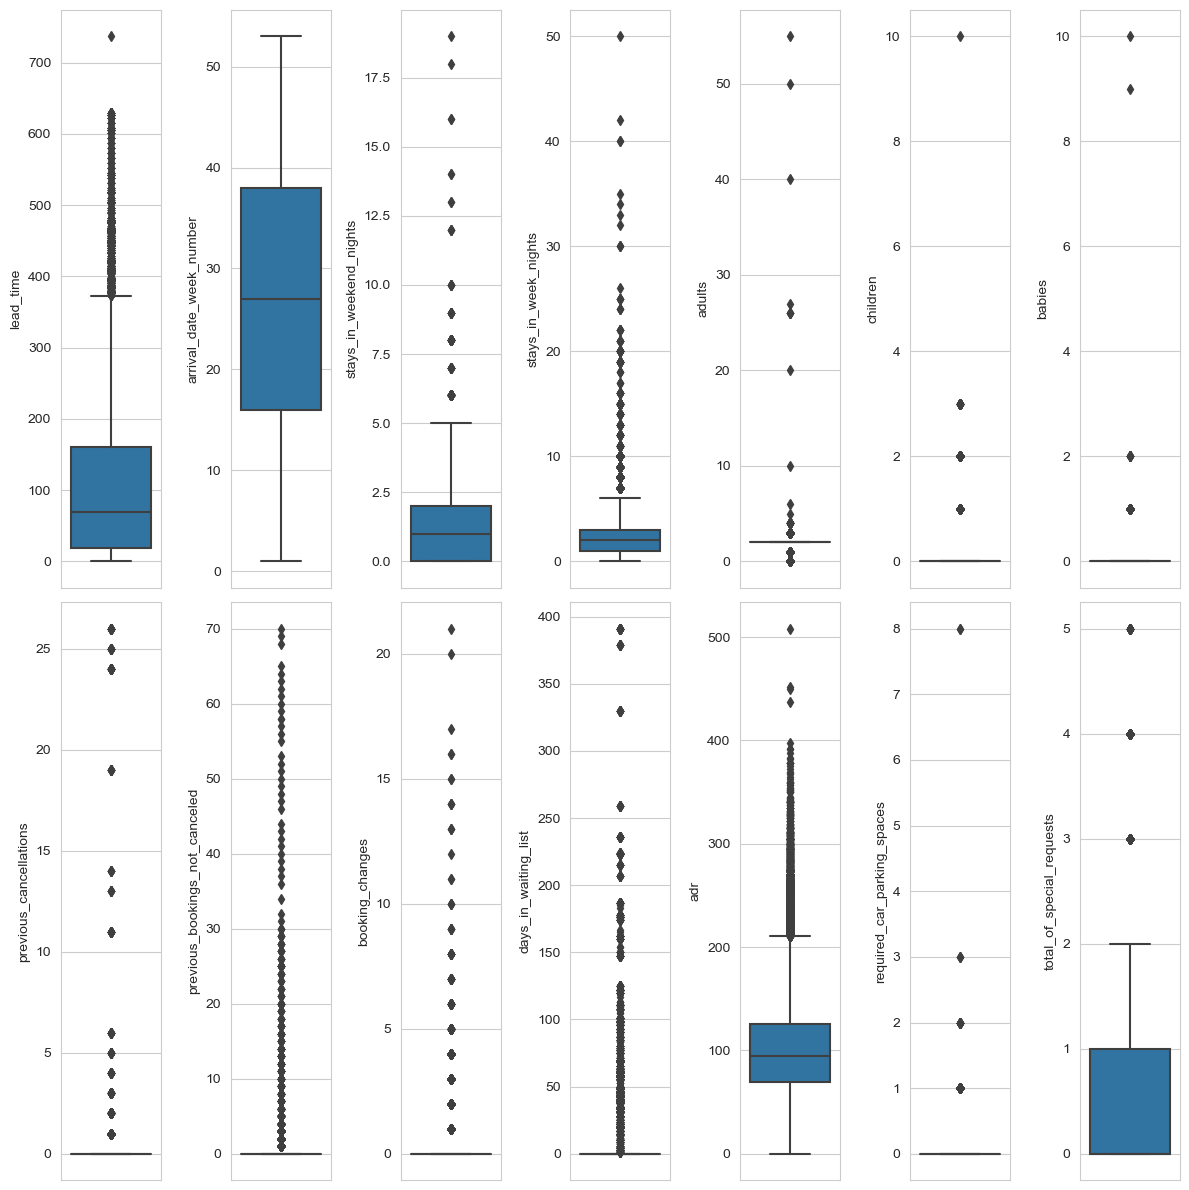

In [30]:
plt.figure(figsize=(12,12))

columns = nums_train
for i in range(len(columns)):
    plt.subplot(2,7, i+1)
    sns.boxplot(data = df_train_clean, y = columns[i])
    plt.tight_layout()
plt.show()

**Observation**

Terlihat hampir keseluruhan data numerical memiliki outliers, tetapi disini akan menghapus outliers yang tidak masuk akal seperti kolom `adult, children, babies` lalu mengecek apakah kolom tersebut ketika dijumlahkan bernilai 0 karena tidak mungkin customer yang memesan hotel tidak ada orangnya. Juga mengecek jumlah total menginap apakah terdapat data yang anomali atau tidak

**Checking & Treatment Hotel Guest**

In [31]:
filter_data = (df_train_clean['adults'] == 0) & (df_train_clean['children'] == 0) & (df_train_clean['babies']==0)
df_train_clean[filter_data].iloc[:,:12]

hotel  is_canceled  \
1377   Sheraton Grand Rio Hotel & Resort Rio de Janei...            0   
1726   Protea Hotel by Marriott Cape Town Sea Point C...            0   
1991   Sheraton Mexico City Maria Isabel Hotel Mexico...            0   
2036   Baton Rouge Acadian Centre/LSU Area Courtyard ...            0   
2401               Orlando Airport Courtyard Orlando, FL            0   
...                                                  ...          ...   
80658  Courtyard by Marriott Toulouse Airport Toulous...            1   
81486  Courtyard by Marriott Toulouse Airport Toulous...            1   
82012  Protea Hotel Fire & Ice! by Marriott Cape Town...            1   
82681                        Tamarind, Barbados Barbados            0   
83021                       W Barcelona Barcelona, Spain            0   

       lead_time  arrival_date_year arrival_date_month  \
1377          37               2018           November   
1726          31               2018           December   
1991           0               2019           February   
2036           0               2017             August   
2401           0               2017           December   
...          ...                ...                ...   
80658          1               2017          September   
81486          0               2019             August   
82012        173               2018              April   
82681        177               2018           December   
83021          0               2018           November   

       arrival_date_week_number  arrival_date_day_of_month  \
1377                         47                         17   
1726                         53                         27   
1991                          9                         27   
2036                         33                         10   
2401                         52                         24   
...                         ...                        ...   
80658                        37                          6   
81486                        32                         11   
82012                        15                          8   
82681                        53                         30   
83021                        48                         23   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  
1377                         1                     3       0         0       0  
1726                         2                     8       0         0       0  
1991                         0                     0       0         0       0  
2036                         9                    20       0         0       0  
2401                         0                     0       0         0       0  
...                        ...                   ...     ...       ...     ...  
80658                        2                     0       0         0       0  
81486                        0                     0       0         0       0  
82012                        2                     3       0         0       0  
82681                        2                     5       0         0       0  
83021                        0                     0       0         0       0  

[127 rows x 12 columns]

**Observation**

Terdapat 127 data guest hotel yang orangnya berjumlah 0 maka akan dilakukan drop

In [32]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])

filter_data = (df_train_clean['adults'] == 0) & (df_train_clean['children'] == 0) & (df_train_clean['babies']==0)
df_train_clean = df_train_clean[~filter_data]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 83293
Jumlah Data Train setelah drop: 83166


**Checking Outliers Children**

In [33]:
df_train_clean[(df_train['children']>4)].iloc[:,:12]

hotel  is_canceled  \
71636  The Westin Peachtree Plaza, Atlanta Atlanta, GA             1   

       lead_time  arrival_date_year arrival_date_month  \
71636         55               2017               July   

       arrival_date_week_number  arrival_date_day_of_month  \
71636                        29                         12   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  
71636                        4                    10       2        10       0

**Observation**

Terdapat 1 data yang memiliki nilai anomali pada `children` yaitu bernilai 10 sedangkan adults hanya 2 orang hal ini tidak masuk akal maka akan dilakukan drop

In [34]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])
df_train_clean = df_train_clean[~(df_train_clean['children']>4)]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 83166
Jumlah Data Train setelah drop: 83165


**Checking Outliers Babies**

In [35]:
df_train_clean[(df_train_clean['babies']>4)].iloc[:,:12]

hotel  is_canceled  lead_time  \
71964                   Waves, Barbados Barbados            0         37   
72741  Des Moines West/Clive Courtyard Clive, IA            0         11   

       arrival_date_year arrival_date_month  arrival_date_week_number  \
71964               2018            January                         3   
72741               2017            October                        42   

       arrival_date_day_of_month  stays_in_weekend_nights  \
71964                         12                        0   
72741                         11                        2   

       stays_in_week_nights  adults  children  babies  
71964                     2       2         0      10  
72741                     1       1         0       9

**Observation**

Terdapat kejanggalan pada 2 data tersebut yang pertama jumlah adult 2 tetapi memiliki bayi 10 dan yang kedua jumlah adult 1 tetapi memiliki bayi 9. Hal ini sepertinya tidak mungkin dengan jumlah adult yang sedikit tetapi memiliki bayi yang cukup banyak, maka untuk 2 data ini akan dilakukan drop

In [36]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])
df_train_clean = df_train_clean[~(df_train_clean['babies']>4)]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 83165
Jumlah Data Train setelah drop: 83163


**Treatment Outlier Adults**

In [37]:
Q1 = df_train_clean['adults'].quantile(0.25)
Q3 = df_train_clean['adults'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5* IQR

In [38]:
lower_limit, upper_limit

(2.0, 2.0)

In [39]:
outliers = df_train_clean[(df_train['adults'] < lower_limit) | (df_train_clean['adults'] > upper_limit)]
print('Jumlah outliers Adults: ', outliers.shape[0])
print(outliers['adults'].unique())

Jumlah outliers Adults:  20792
[ 1  3  0  4 50 10 26 27 40 55  5  6 20]


In [40]:
outliers[outliers['adults'] > 4][['adults','children','babies','adr','reservation_status']]

adults  children  babies  adr reservation_status
4242       50         0       0  0.0           Canceled
12668      10         0       0  0.0           Canceled
28122      26         0       0  0.0           Canceled
28470      27         0       0  0.0           Canceled
38011      40         0       0  0.0           Canceled
39003      26         0       0  0.0           Canceled
39547      26         0       0  0.0           Canceled
55758      26         0       0  0.0           Canceled
65582      55         0       0  0.0           Canceled
68235      26         0       0  0.0           Canceled
70619       5         0       0  0.0           Canceled
73085       6         0       0  0.0           Canceled
74522      20         0       0  0.0           Canceled

**Observation**

Terdapat data yang janggal pada adults dimana untuk 1 kamar hotel biasanya diisi maksimal hanya 4 orang dewasa sedangkan terdapat nilai ekstream diatas 4 maka akan dilakukan drop

In [41]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])
df_train_clean = df_train_clean[df_train['adults'] <=4]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 83163
Jumlah Data Train setelah drop: 83150


**Outlier stays in weekend nights & stays in week nights**

In [42]:
Q1 = df_train_clean['stays_in_weekend_nights'].quantile(0.25)
Q3 = df_train_clean['stays_in_weekend_nights'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5* IQR

lower_limit, upper_limit

(-3.0, 5.0)

In [43]:
outliers = df_train_clean[(df_train_clean['stays_in_weekend_nights'] < lower_limit) | (df_train_clean['stays_in_weekend_nights'] > upper_limit)]
print('Jumlah outliers stays_in_weekend_nights: ', outliers.shape[0])
print(outliers['stays_in_weekend_nights'].unique())

Jumlah outliers stays_in_weekend_nights:  191
[ 6  8 19 12  9 10  7 18 16 13 14]


**Observation**

Bahwa berdasarkan IQR terdeteksi 191 outlier untuk lebih detail dilakukan pengecekan untuk jumlah weekend > 10 karena pada umumnya dalam 1 bulan hari weekend terdapat 8 - 10 hari

In [44]:
outliers[outliers['stays_in_weekend_nights'] > 10]

hotel  is_canceled  \
3441   Residence Inn Rio de Janeiro Barra da Tijuca B...            0   
5324                         Tamarind, Barbados Barbados            1   
5701           Des Moines West/Clive Courtyard Clive, IA            0   
5726                      Colony Club, Barbados Barbados            0   
48416  Protea Hotel Fire & Ice! by Marriott Cape Town...            0   
54715  Courtyard Las Vegas Convention Center Las Vega...            0   
55783  San Diego Sorrento Valley Courtyard San Diego, CA            0   
62885  Protea Hotel by Marriott O.R. Tambo Airport Jo...            1   
65319  Hotel Alfonso XIII, a Luxury Collection Hotel,...            0   
71073                  Treasure Beach, Barbados Barbados            0   
71792   The Westin Peachtree Plaza, Atlanta Atlanta, GA             0   

       lead_time  arrival_date_year arrival_date_month  \
3441         126               2018               July   
5324         122               2018            January   
5701         214               2018            January   
5726          80               2019              March   
48416        113               2017             August   
54715        242               2019           February   
55783         71               2019            January   
62885        322               2019            January   
65319         30               2017          September   
71073          1               2019           February   
71792        206               2018               July   

       arrival_date_week_number  arrival_date_day_of_month  \
3441                         28                          5   
5324                          3                         12   
5701                          5                         26   
5726                         10                          5   
48416                        31                          1   
54715                         7                         17   
55783                         2                         10   
62885                         2                         10   
65319                        37                          7   
71073                         5                          3   
71792                        30                         23   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
3441                        19                    50       1  ...   
5324                        12                    30       2  ...   
5701                        12                    30       2  ...   
5726                        12                    26       2  ...   
48416                       18                    42       1  ...   
54715                       12                    30       2  ...   
55783                       16                    40       2  ...   
62885                       16                    40       2  ...   
65319                       13                    33       2  ...   
71073                       13                    32       1  ...   
71792                       14                    34       2  ...   

       deposit_type  agent days_in_waiting_list    customer_type     adr  \
3441     No Deposit    0.0                    0        Transient  110.00   
5324     No Deposit    8.0                    0        Transient   22.11   
5701     No Deposit    8.0                    0        Transient   31.45   
5726     No Deposit  273.0                    0  Transient-Party    0.26   
48416    No Deposit    0.0                    0        Transient  110.50   
54715    No Deposit   75.0                    0        Transient   35.70   
55783    No Deposit  196.0                    0        Transient   28.79   
62885    No Deposit    8.0                    0        Transient   25.50   
65319    No Deposit  240.0                    0        Transient    0.00   
71073    No Deposit    0.0                    0        Transient   42.11   
71792    No Deposit    9.0                    0  Transient-Party   

**Observation**

Terdapat 9 data yang memiliki jumlah weekend night > 10 dan dipastikan kembali apakah weekend > week days karena logikanya untuk weekdays jumlah hari lebih banyak dibandingkan weekend

In [45]:
#mengecek anomali stays in weekend lebih besar daripada stays in weekday
outliers[(outliers['stays_in_weekend_nights']>outliers['stays_in_week_nights'])]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, bookingID]
Index: []

[0 rows x 32 columns]

**Observation**

Tidak terdapat weekend > weekdays artinya data tersebut normal sedangkan weekend yang banyak seiring dengan weekday yang banyak juga dapat diartikan bahwa pemesan tersebut menginap dengan jangka waktu cukup lama

In [46]:
df_train_clean[(df_train_clean['stays_in_weekend_nights'] == 0) & (df_train_clean['stays_in_week_nights'] == 0)]

hotel  is_canceled  \
499                Berlin Marriott Hotel Berlin, Germany            0   
627                         The House, Barbados Barbados            0   
729    Irvine John Wayne Airport/Orange County Courty...            1   
795    Protea Hotel Fire & Ice! by Marriott Johannesb...            0   
827             Chicago O'Hare Courtyard Des Plaines, IL            0   
...                                                  ...          ...   
82256                    Crystal Cove, Barbados Barbados            0   
82289              Berlin Marriott Hotel Berlin, Germany            0   
82796                           Waves, Barbados Barbados            0   
83156              Orlando Airport Courtyard Orlando, FL            0   
83216  Orlando International Drive/Convention Center ...            0   

       lead_time  arrival_date_year arrival_date_month  \
499           25               2018              March   
627           23               2019            January   
729           29               2018              April   
795           33               2018              April   
827            0               2018                May   
...          ...                ...                ...   
82256        143               2018              April   
82289          1               2019                May   
82796         69               2019            January   
83156          0               2019              March   
83216          0               2017               July   

       arrival_date_week_number  arrival_date_day_of_month  \
499                          14                         30   
627                           2                         11   
729                          18                         30   
795                          16                         11   
827                          21                         17   
...                         ...                        ...   
82256                        18                         24   
82289                        18                          2   
82796                         1                          1   
83156                        12                         20   
83216                        30                         20   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
499                          0                     0       1  ...   
627                          0                     0       1  ...   
729                          0                     0       2  ...   
795                          0                     0       2  ...   
827                          0                     0       1  ...   
...                        ...                   ...     ...  ...   
82256                        0                     0       2  ...   
82289                        0                     0       2  ...   
82796                        0                     0       2  ...   
83156                        0                     0       1  ...   
83216                        0                     0       1  ...   

       deposit_type  agent days_in_waiting_list customer_type  adr  \
499      No Deposit    0.0                    0     Transient  0.0   
627      No Deposit    9.0                    0     Transient  0.0   
729      No Deposit  240.0                    0     Transient  0.0   
795      No Deposit  171.0                    0     Transient  0.0   
827      No Deposit    6.0                    0     Transient  0.0   
...             ...    ...                  ...           ...  ...   
82256    No Deposit   28.0                    0     Transient  0.0   
82289    No Deposit  240.0                    0     Transient  0.0   
82796    No Deposit    5.0                    0         Group  0.0   
83156    No Deposit    0.0                    0     Transient  0.0   
83216    No Deposit    5.0                    0     Transient  0.0   

      required_car_parking_spaces  total_of_special_requests  

**Observation**

Terdapat data janggal bahwa tamu memesan hotel tetapi stay di hotelnya 0. Bisa jadi kemungkinan data nya error atau lupa input dari pihak hotelnya. Oleh karena itu data tersebut akan di drop

In [47]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])
df_train_clean = df_train_clean[(df_train_clean['stays_in_weekend_nights'] != 0) | (df_train_clean['stays_in_week_nights'] != 0)]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 83150
Jumlah Data Train setelah drop: 82705


**Checking Outlier pada Required Parking Spaces**

In [48]:
df_train_clean[df_train_clean['required_car_parking_spaces']>4][['adults','children','babies','required_car_parking_spaces']]

adults  children  babies  required_car_parking_spaces
3956        2         0       0                            8
46574       2         0       0                            8

**Observation**

Terdapat data janggal bahwa jumlah tamu hanya 2 tetapi membutuhkan parkiran 8 maka disini akan dilakukan drop data tersebut

In [49]:
print('Jumlah Data Train sebelum drop:',df_train_clean.shape[0])
df_train_clean = df_train_clean[df_train_clean['required_car_parking_spaces']!=8]
print('Jumlah Data Train setelah drop:',df_train_clean.shape[0])

Jumlah Data Train sebelum drop: 82705
Jumlah Data Train setelah drop: 82703


**All Observation**

Sudah tidak terdapat data anomali, jumlah data menjadi 82703

In [50]:
print('Persentase Jumlah data yang didrop', round((df_train.shape[0] - df_train_clean.shape[0]) / df_train.shape[0]*100,2),'%')

Persentase Jumlah data yang didrop 0.71 %


Jumlah data yang didrop sebesar 0.71% dari keseluruhan data masih tergolong aman

#### Canceled Status (Target)

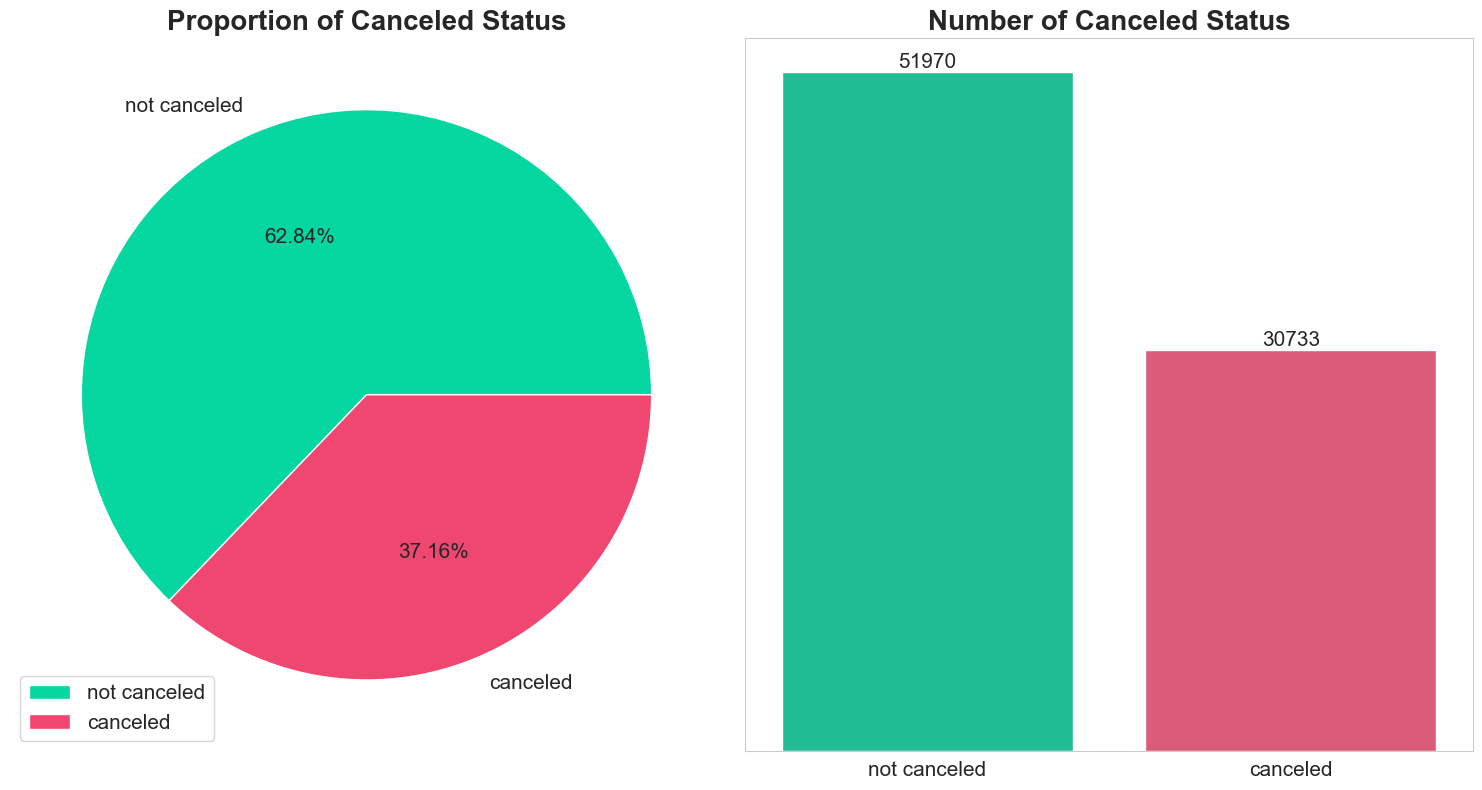

In [587]:
canceled = df_train_clean['is_canceled'].value_counts()
color = ['#06d6a0','#ef476f']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].pie(canceled.values,autopct= '%.2f%%', labels=['not canceled','canceled'], 
          textprops={'fontsize': 15}, colors= color)
ax[0].set_title('Proportion of Canceled Status', fontdict = {'fontsize':20, 'fontweight':'bold'})
ax[0].legend(loc = 'lower left', fontsize=15)


sns.barplot(x= canceled.index, y= canceled.values, palette=color, ax=ax[1])
ax[1].set_title('Number of Canceled Status', fontdict = {'fontsize':20, 'fontweight':'bold'})
ax[1].set_xticklabels(['not canceled','canceled'])
ax[1].bar_label(ax[1].containers[0], fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

**Observation**

Proporsi not canceled dan canceled imbalance, terlihat mayoritas lebih banyak not canceled tetapi jumlah canceled sebesar 37.16% dapat dikatakan cukup banyak. Dengan jumlah canceled yang cukup banyak ini dapat mempengaruhi revenue dan profit hotel.

#### Categorical Distribution

In [52]:
cats_train.remove('agent')

In [53]:
cats_train

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'is_canceled',
 'is_repeated_guest']

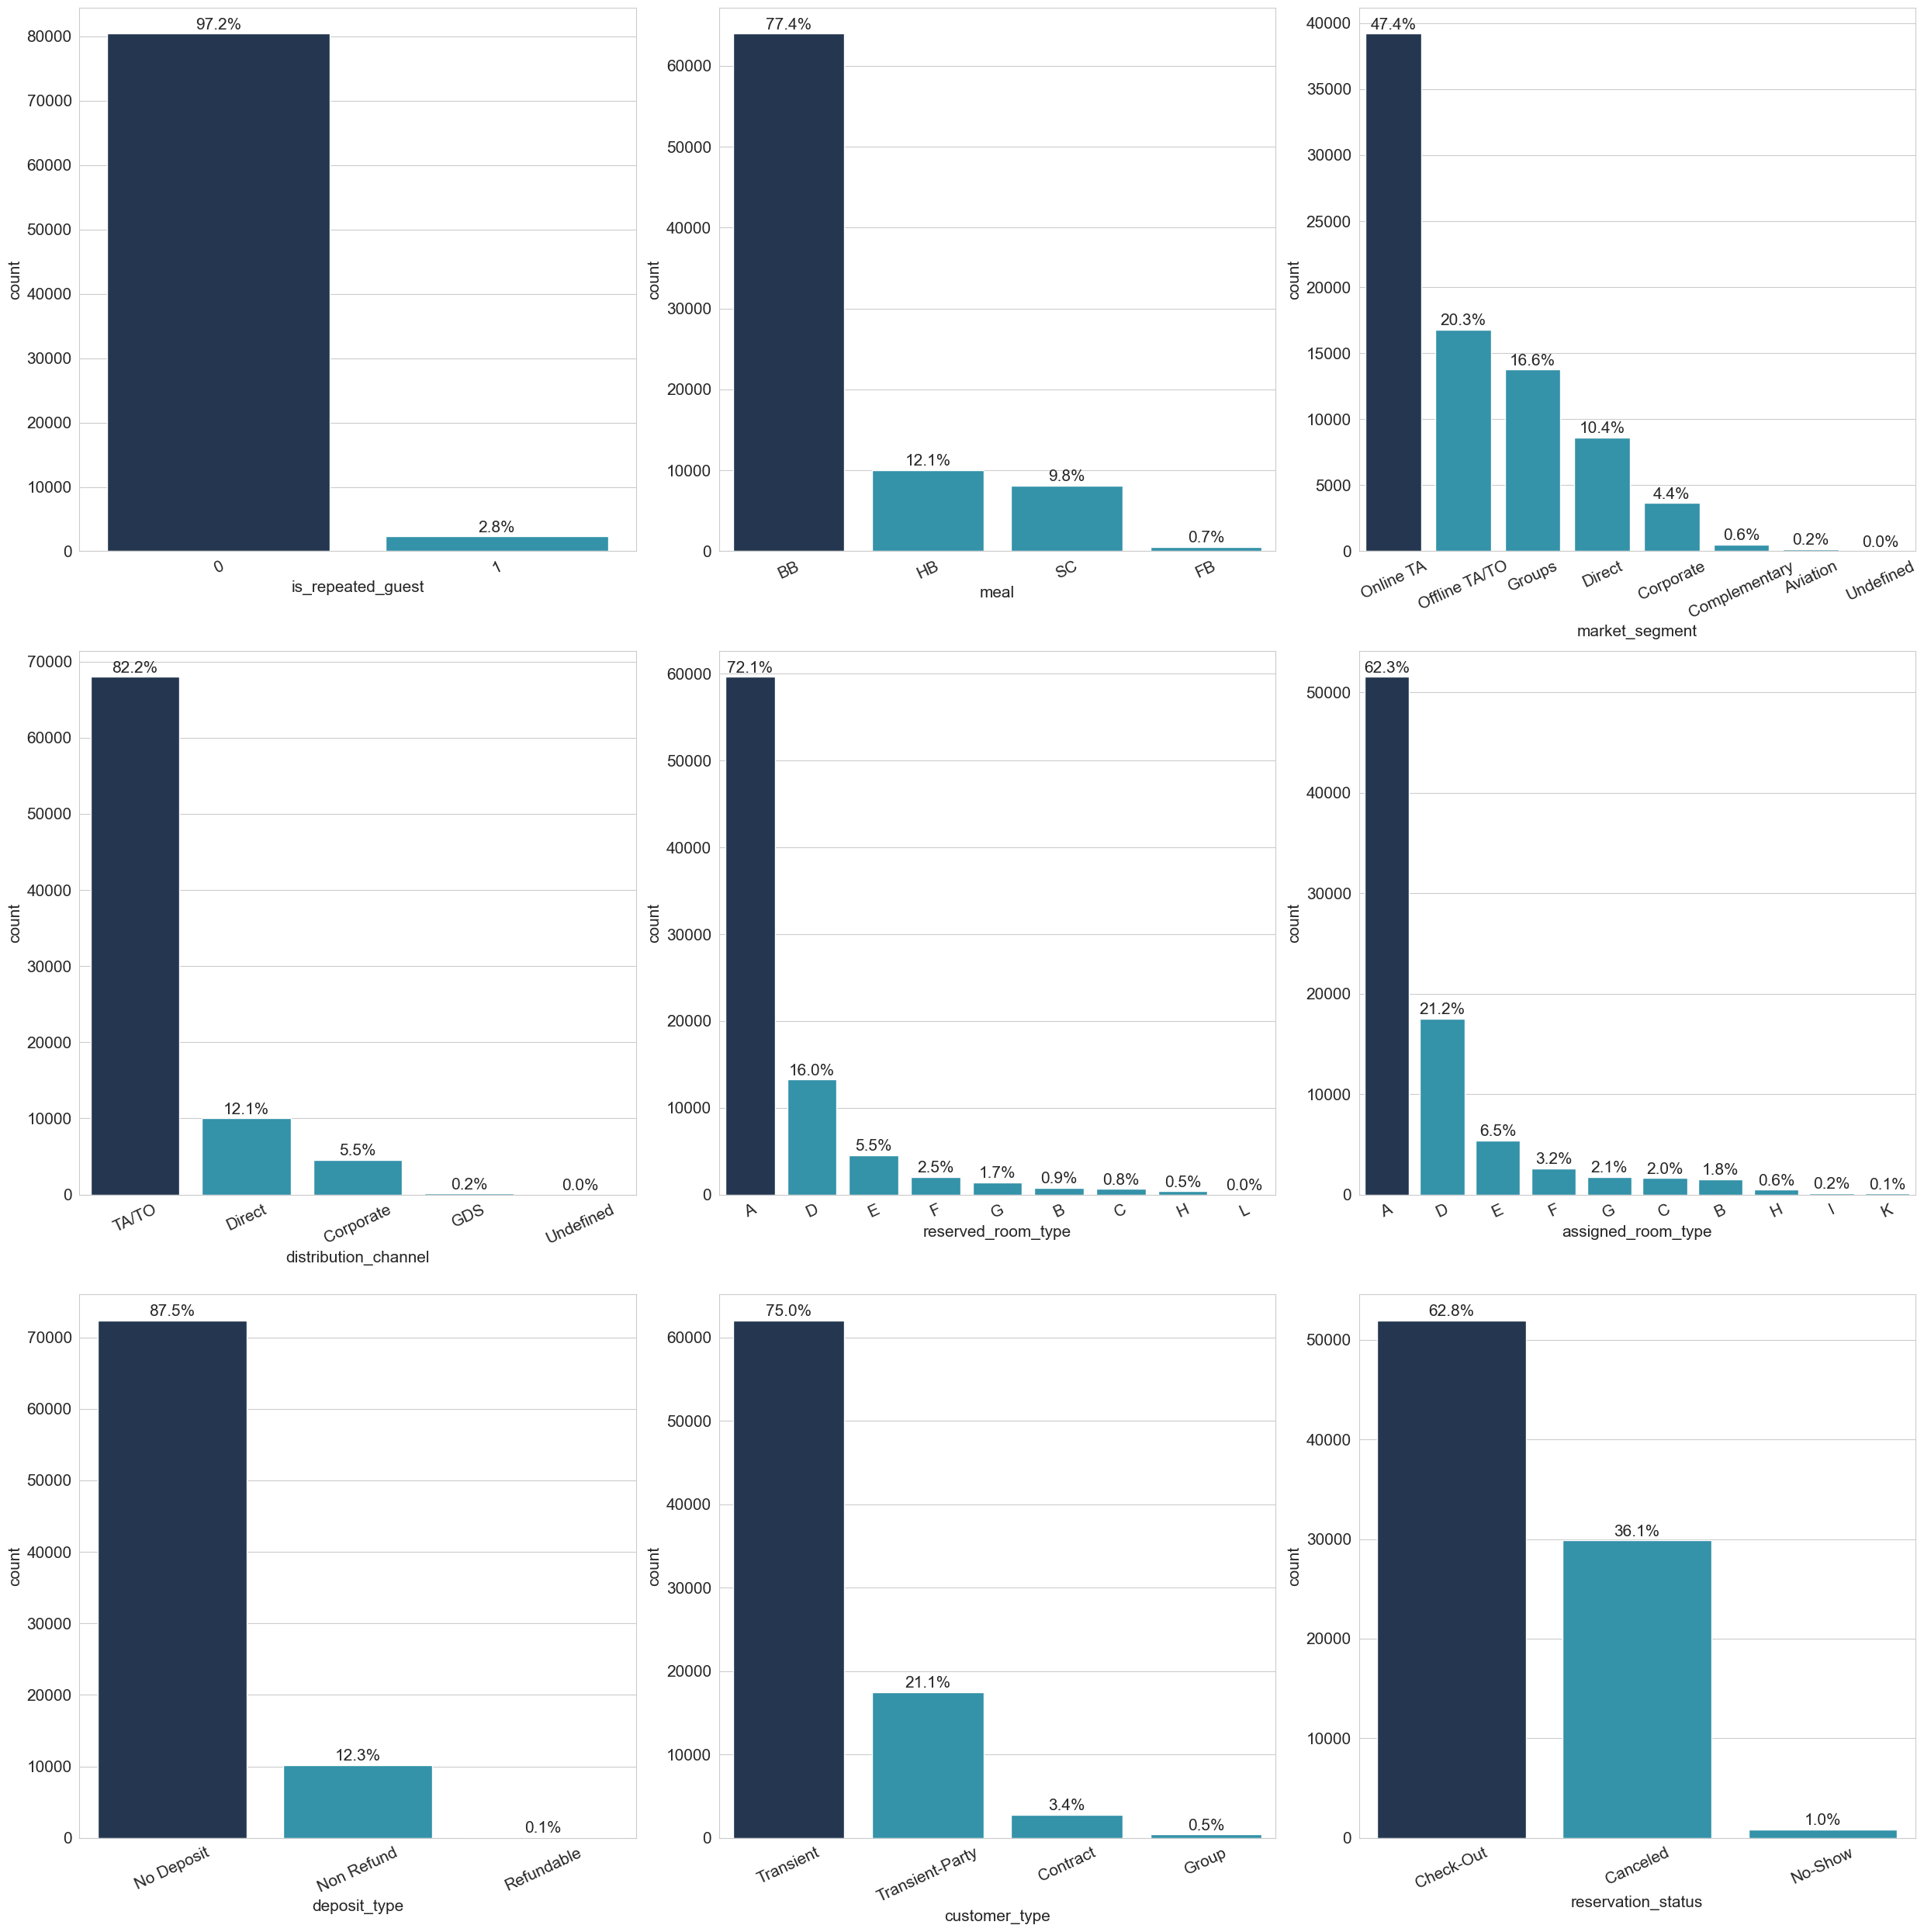

In [54]:
column = ['is_repeated_guest','meal'] + cats_train[3:-2]

plt.figure(figsize=(25,25))
for i, col in enumerate(column):
    plt.subplot(3, 3, i + 1)
    fitur = df_train_clean[col].value_counts()
    ax = sns.barplot(x=fitur.index, y=fitur.values, 
                palette=np.where(fitur.values == fitur.values.max(), '#1d3557', '#219ebc'))
    #Menampilkan persentase
    total = len(df_train_clean)
    for p in ax.patches:
        percent = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percent, (x, y), ha='center', va='center', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('count', fontsize=15)
    plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

**Observation**

1. Pada repeated guest lebih banyak yang tidak melakukan pemesanan lagi, bisa jadi merupakan customer baru atau memang customer lama yang tidak melakukan pemesanan hotel. Hal ini bisa dijadikan perhatian untuk pihak hotel dengan meningkatkan pelayanannya agar customer melakukan pemesanan lagi. Karena repeat guest artinya mereka puas terhadap fasilitas hotel, hal ini juga dapat mendatangkan pelanggan baru

2. Mayoritas customer memesan hotel dengan mengambil paket **BB (Bed - Breakfast)** selanjutnya adalah **HB (Half Board)** atau **Breakfast dan Dinner**. Hal ini bisa sebagai patokan bahan makanan yang dapat dipersiapkan untuk pengunjung terutama untuk pesanan yang memilih fasilitas Breakfast

3. Berdasarkan market segment bahwa mayoritas pemesan hotel melalui Online **Travel Agent (Online TA)** dan **offline TA/TO** sedangkan paling sedikit melalui **complementary** dan **aviation**. Dari hal tersebut pihak hotel bisa memaksimalkan transaksi melalui TA dan TO dengan memberikan promo atau voucher sehingga bisa mendapatkan pemesanan yang lebih banyak dan pelanggan baru

4. Berdasarkan distribusi channel bahwa pemesanan hotel mayoritas menggunakan TA/TO

5. Mayoritas pemesan memilih kamar Tipe A terlihat pada `reserved_room_type` kamar tipe A memiliki jumlah yang lebih banyak dibandingkan dengan kamar yang lainnya, tetapi terdapat perbedaan jumlah antara `reserved_room_type` dan `assigned_room_type` kemungkinan kamar yang dipesan overbook sehingga dialihkan ke tipe kamar lain, hal ini terlihat kamar tipe A mengalami penurunan sedangkan kamar tipe lain mengalami kenaikan pada `assigned_room_type`

6. Mayoritas pemesan memilih pembayaran dengan No Deposit yang artinya tidak membayar DP atau langsung membayar sekaligus.

7. Rata-rata pemesan yaitu Transient (pemesan individu sementara) selanjutnya Transient-Party (pemesan sementara berkelompok)

8. `reservation_status` datanya sama dengan data target `is_canceled` kemungkinan data target merupakan hasil encode dari kolom `reservation_status`.

**TOP 10 Country Origin Most Hotel Booking**

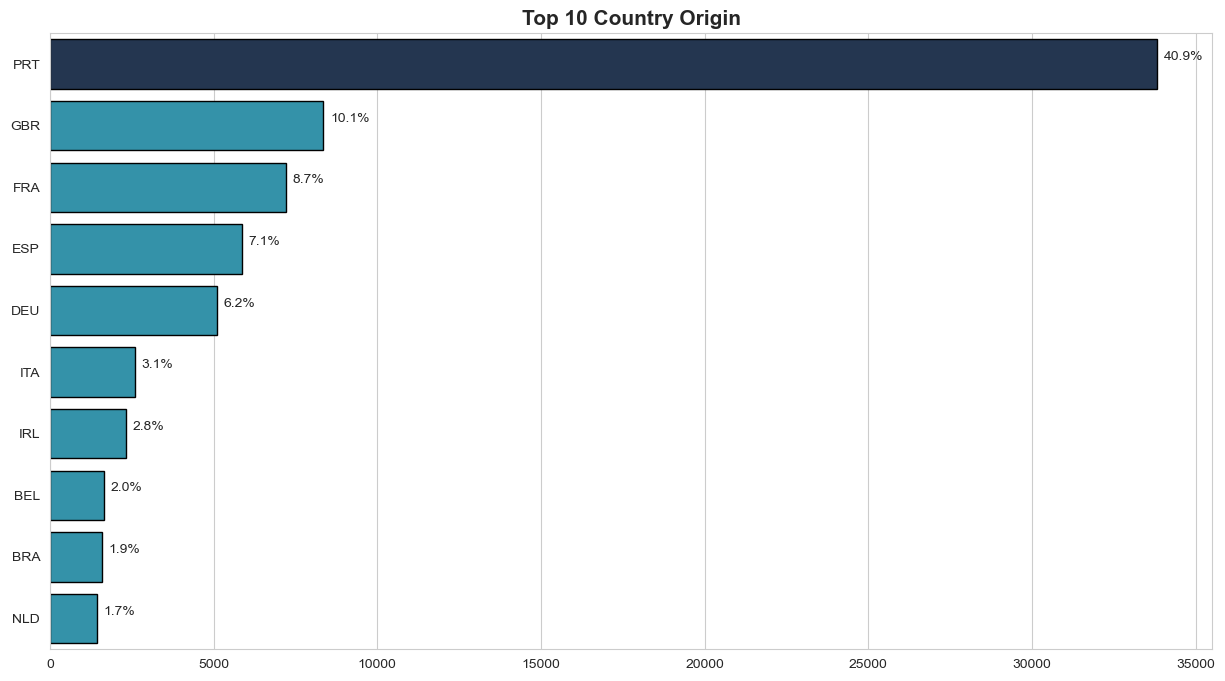

In [55]:
country_count = df_train_clean['country'].value_counts().reset_index()

plt.figure(figsize=(15,8))
ax = sns.barplot(data = country_count.head(10), y = 'index', x = 'country', 
            palette= np.where(country_count.country == country_count.country.max(),'#1d3557', '#219ebc'), edgecolor='black')

#Menampilkan persentase
total = len(df_train_clean)
for p in ax.patches:
    percent = f'{100 * p.get_width() / total:.1f}%\n'
    x = p.get_width() + 200
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percent, (x, y), ha='left', va='center', fontsize=10)
        
plt.tick_params(axis='both', labelsize=10)
plt.title('Top 10 Country Origin', fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.xlabel(None)
plt.ylabel(None)
plt.show()

**Observation**

Bahwa pemesan hotel mayoritas berasal dari PRT (portugal) kemungkinan adalah warga lokal lalu selanjutnya negara Eropa lainnya (United Kingdom, France, Spain, Germany)

**TOP 10 Travel Agent Most Hotel Booking**

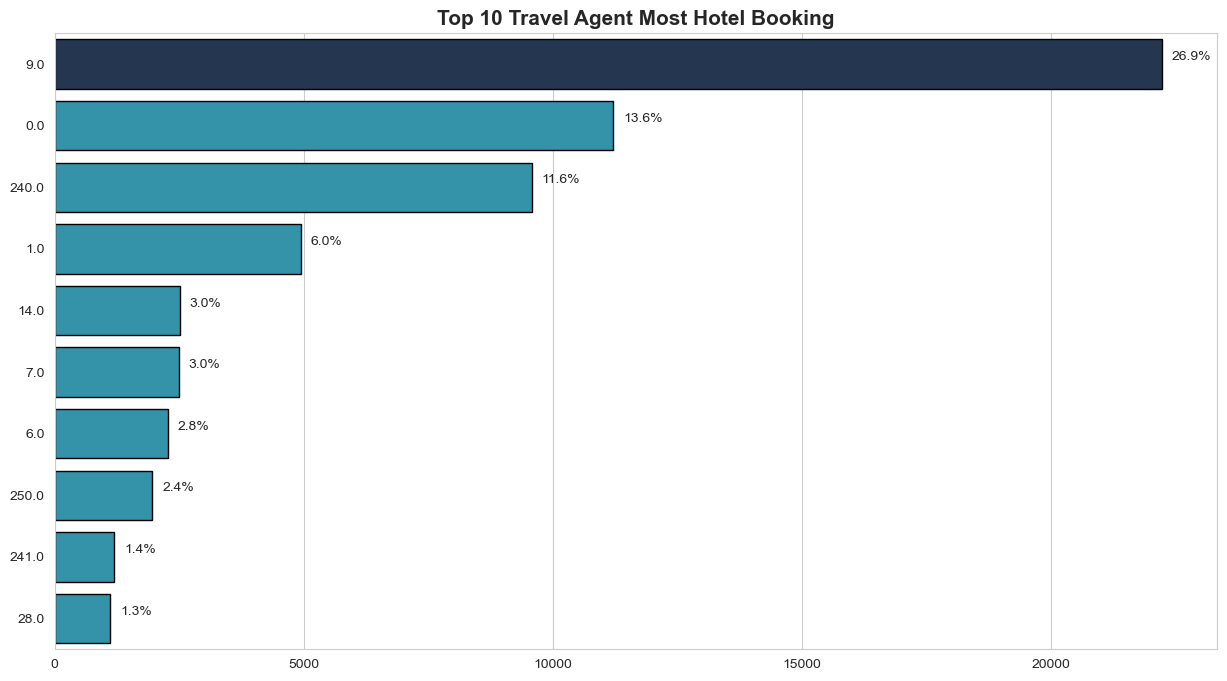

In [56]:
agent_count = df_train_clean['agent'].value_counts().reset_index()
agent_count['index'] = agent_count['index'].astype(str)

plt.figure(figsize=(15,8))
ax = sns.barplot(data = agent_count.head(10), y = 'index', x = 'agent', 
            palette= np.where(agent_count.agent == agent_count.agent.max(),'#1d3557', '#219ebc'), edgecolor='black')

#Menampilkan persentase
total = len(df_train_clean)
for p in ax.patches:
    percent = f'{100 * p.get_width() / total:.1f}%\n'
    x = p.get_width() + 200
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percent, (x, y), ha='left', va='center', fontsize=10)
        
plt.tick_params(axis='both', labelsize=10)
plt.title('Top 10 Travel Agent Most Hotel Booking', fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.xlabel(None)
plt.ylabel(None)
plt.show()

**Observation**

Untuk pemesanan hotel didominasi oleh travel agent dengan ID 9 selanjutnya Id 0 atau tidak melalui agent, 240 dan 1 sedangkan lainnya dibawah 6%. Perlu ditindaklanjuti apakah pemesanan yang banyak oleh travel agent ID 9 menyumbang jumlah cancellation yang banyak

#### Numerical Distribution

In [57]:
nums_train

['lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

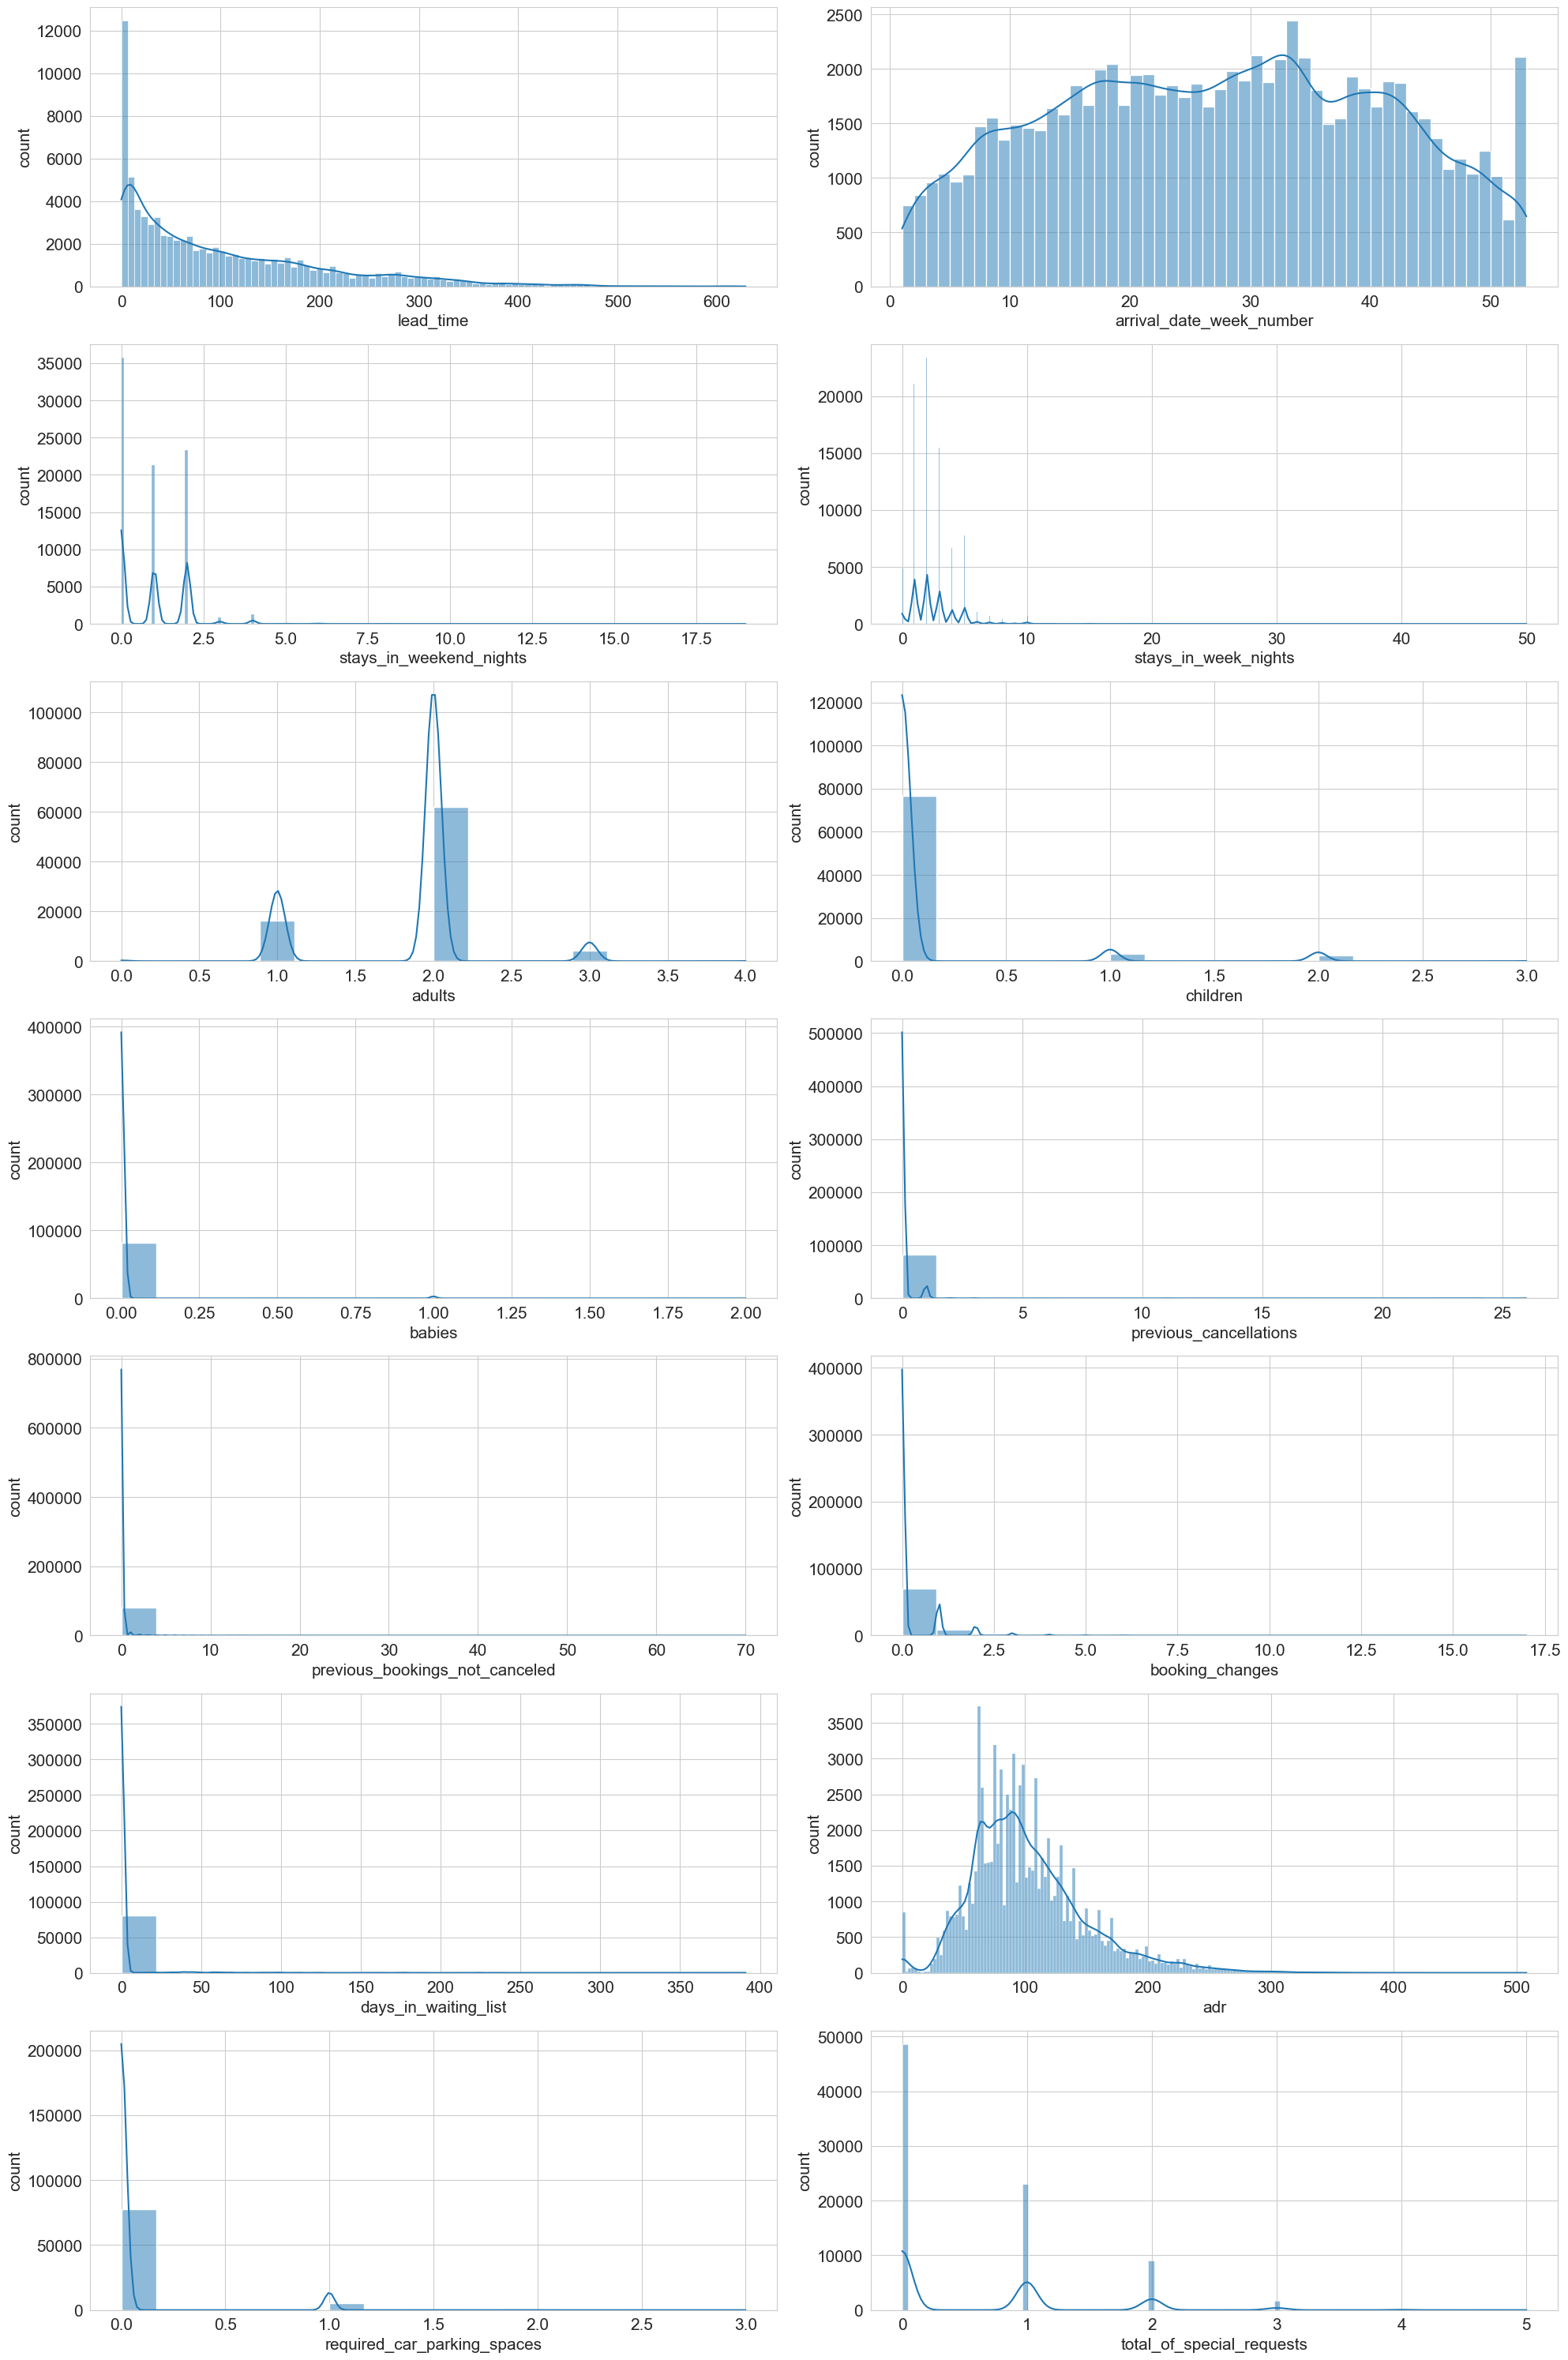

In [58]:
column = nums_train

plt.figure(figsize=(20,30))

for i in range(len(column)):
    plt.subplot(7,2,i+1)
    sns.histplot(df_train_clean[column[i]], kde=True)
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(column[i],fontsize=15)
    plt.ylabel('count',fontsize=15)
plt.tight_layout()
plt.show()

**Observation**

1. Pemesan hotel mayoritas memiliki `lead_time` sebanyak 0 artinya tidak ada waktu tunggu dari pesanan hingga kedatangan atau para pemesan hotel datang pada saat itu juga. Terdapat juga pemesan hotel yang memiliki `lead_time`, hal ini perlu dibandingkan apakah mayoritas pembatalan pesanan merupakan kategori yang memiliki `lead_time` sedikit atau besar

2. Kedatangan pemesan hotel berdasarkan mingguan bervariatif dan puncak distribusi waktu kedatangan terdapat pada minggu ke-33 

3. Pemesan menginap pada `stays_in_weekend_nights` sekitar 0 -2 hari sedangkan `stays_in_week_nights` sekitar 1 - 3 hari. Berdasarkan hal tersebut dapat ditinjau apakah mayoritas pembatalan hotel terjadi pada weekend atau weekdays

4. Pemesan hotel mayoritas 2 orang artinya pengunjung adalah couple dapat ditinjau apakah tipe pemesan ini yang memberikan kontribusi pembatalan pesanan paling tinggi

5. Pemesan hotel mayoritas tidak memiliki children, babies terlihat bahwa distribusi paling banyak yaitu 0

6. `previous_bookings_not_canceled`, `previous_cancellations` distribusi paling banyak 0 artinya bahwa mayoritas pemesan adalah customer baru. Hal ini dapat menjadi perhatian pihak hotel untuk memberikan pelayanan yang baik agar customer tersebut dapat repeat_booking

7. `booking_changes` distribusi paling banyak 0 artinya semua pesanan hotel adalah final dan tidak adanya perubahan

8. `days_in_waiting_list` distrisbusi paling banyak 0 tetapi terdapat juga waiting list cukup lama hal ini perlu diperhatikan apakah pembatalan pesanan dikarenakan waiting list yang cukup lama atau tidak

9. `adr` distribusi paling banyak sekitar 60 -100 terdapat juga adr yang cukup tinggi. Hal ini dapat ditinjau apakah adr yang tinggi berpengaruh pada pembatalan tiket

10. `required_car_parking_spaces` mayoritas pemesan tidak membawa kendaraan, hal ini dapat ditinjau apakah terdapat pengaruh pembatalan tiket dengan tamu yang membawa kendaraan

11. `total_of_special_request` distribusinya bervariatif, hal ini dapat ditinjau pembatalan pesanan dipengaruhi oleh faktor ini

#### Time Series Distribution

In [59]:
column = date_train + ['reservation_status']

**Year to Year Hotel Booking**

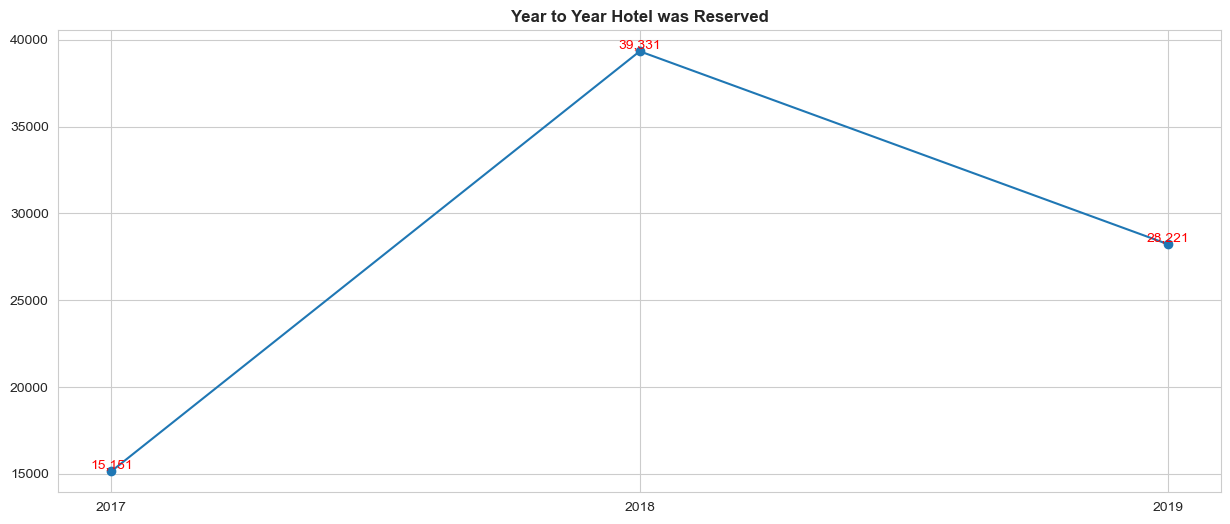

In [60]:
year = df_train_clean[column]

count_year = year.groupby('arrival_date_year').size().reset_index(name='count')

plt.figure(figsize=(15,6))

plt.plot(count_year['arrival_date_year'],count_year['count'], marker ='o')

# Add count annotations
for i in range(0, count_year.shape[0]):
    plt.text(count_year['arrival_date_year'][i], count_year['count'][i] + 0.1, 
             f'{count_year["count"][i]:,.0f}', color='red', ha='center', va='bottom')
plt.title('Year to Year Hotel was Reserved', fontweight='bold')
plt.xticks([2017,2018,2019])
plt.show()

**Observation**

Berdasarkan tahun bahwa hotel banyak dipesan pada tahun 2018 dan terjadi penurunan pada tahun 2019

**Monthly Hotel Booking**

In [61]:
month = df_train_clean[column]

month['month_year'] = pd.to_datetime(month['arrival_date_year'].astype(str) + '-' + month['arrival_date_month'].astype(str))
count_month = month.groupby('month_year').size().reset_index(name='count')
count_month['month_year'] = count_month['month_year'].dt.strftime('%B %Y')

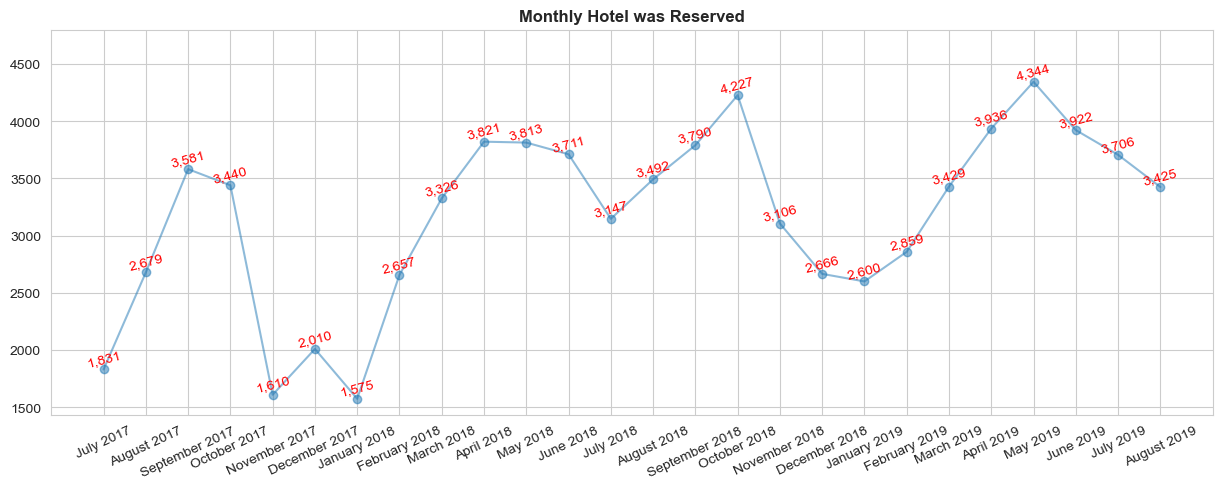

In [62]:
plt.figure(figsize=(15,5))

plt.plot(count_month['month_year'],count_month['count'], marker ='o', alpha = .5)

# Add count annotations
for i in range(0, count_month.shape[0]):
    plt.text(count_month['month_year'][i], count_month['count'][i] + 0.1, 
             f'{count_month["count"][i]:,.0f}', color='red', ha='center', va='bottom', rotation=15)

plt.title('Monthly Hotel was Reserved', fontweight='bold')
plt.ylim(ymax=4800)
plt.xticks(rotation=25)
plt.show()

**Observation**

Hotel dipesan bervariatif, Berdasarkan bulan bahwa hotel banyak dipesan pada bulan Oktober 2018 dan Mei 2019 dan terlihat terdapat pattern bahwa pesanan menurun setiap awal tahun (Januari)

**Daily Hotel Booking**

In [63]:
df_train_clean[column]

arrival_date_year arrival_date_month  arrival_date_day_of_month  \
0                   2019            January                         10   
1                   2018           December                         15   
2                   2019                May                         19   
3                   2018            October                         17   
4                   2017          September                         26   
...                  ...                ...                        ...   
83288               2018            October                         25   
83289               2017          September                         14   
83290               2019               June                         21   
83291               2018               July                         31   
83292               2018            October                         20   

      reservation_status_date reservation_status  
0                  2019-01-14          Check-Out  
1                  2017-10-21           Canceled  
2                  2018-11-25           Canceled  
3                  2018-10-18          Check-Out  
4                  2017-08-24           Canceled  
...                       ...                ...  
83288              2018-10-27          Check-Out  
83289              2017-09-18          Check-Out  
83290              2019-07-05          Check-Out  
83291              2018-08-06          Check-Out  
83292              2018-10-25          Check-Out  

[82703 rows x 5 columns]

In [64]:
daily_booking = df_train_clean[column]
daily = daily_booking.groupby('arrival_date_day_of_month').size().reset_index(name='count')

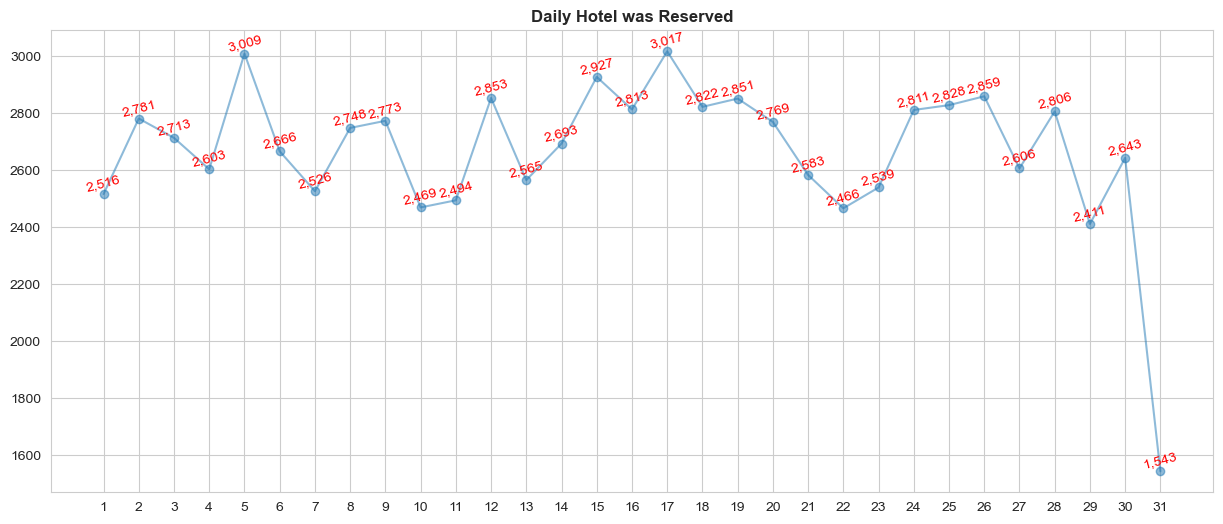

In [65]:
plt.figure(figsize=(15,6))

plt.plot(daily['arrival_date_day_of_month'],daily['count'], marker='o', alpha = 0.5)
# Add count annotations
for i in range(0, daily.shape[0]):
    plt.text(daily['arrival_date_day_of_month'][i], daily['count'][i] + 0.1, 
             f'{daily["count"][i]:,.0f}', color='red', ha='center', va='bottom', rotation=15)
plt.xticks(range(1,32))
plt.title('Daily Hotel was Reserved', fontweight='bold')
plt.show()

**Observation**

Berdasarkan tanggal bahwa hotel yang dipesan paling tinggi pada tanggal 5 dan tanggal 17 artinya hotel dipesan paling banyak pada awal dan tengah bulan sedangkan paling rendah yaitu pada tanggal 31, hal ini wajar karena dalam 1 tahun tanggal 31 hanya terdapat setengahnya

### Bivariate Analysis

#### Cancelation Based on Categorical Data

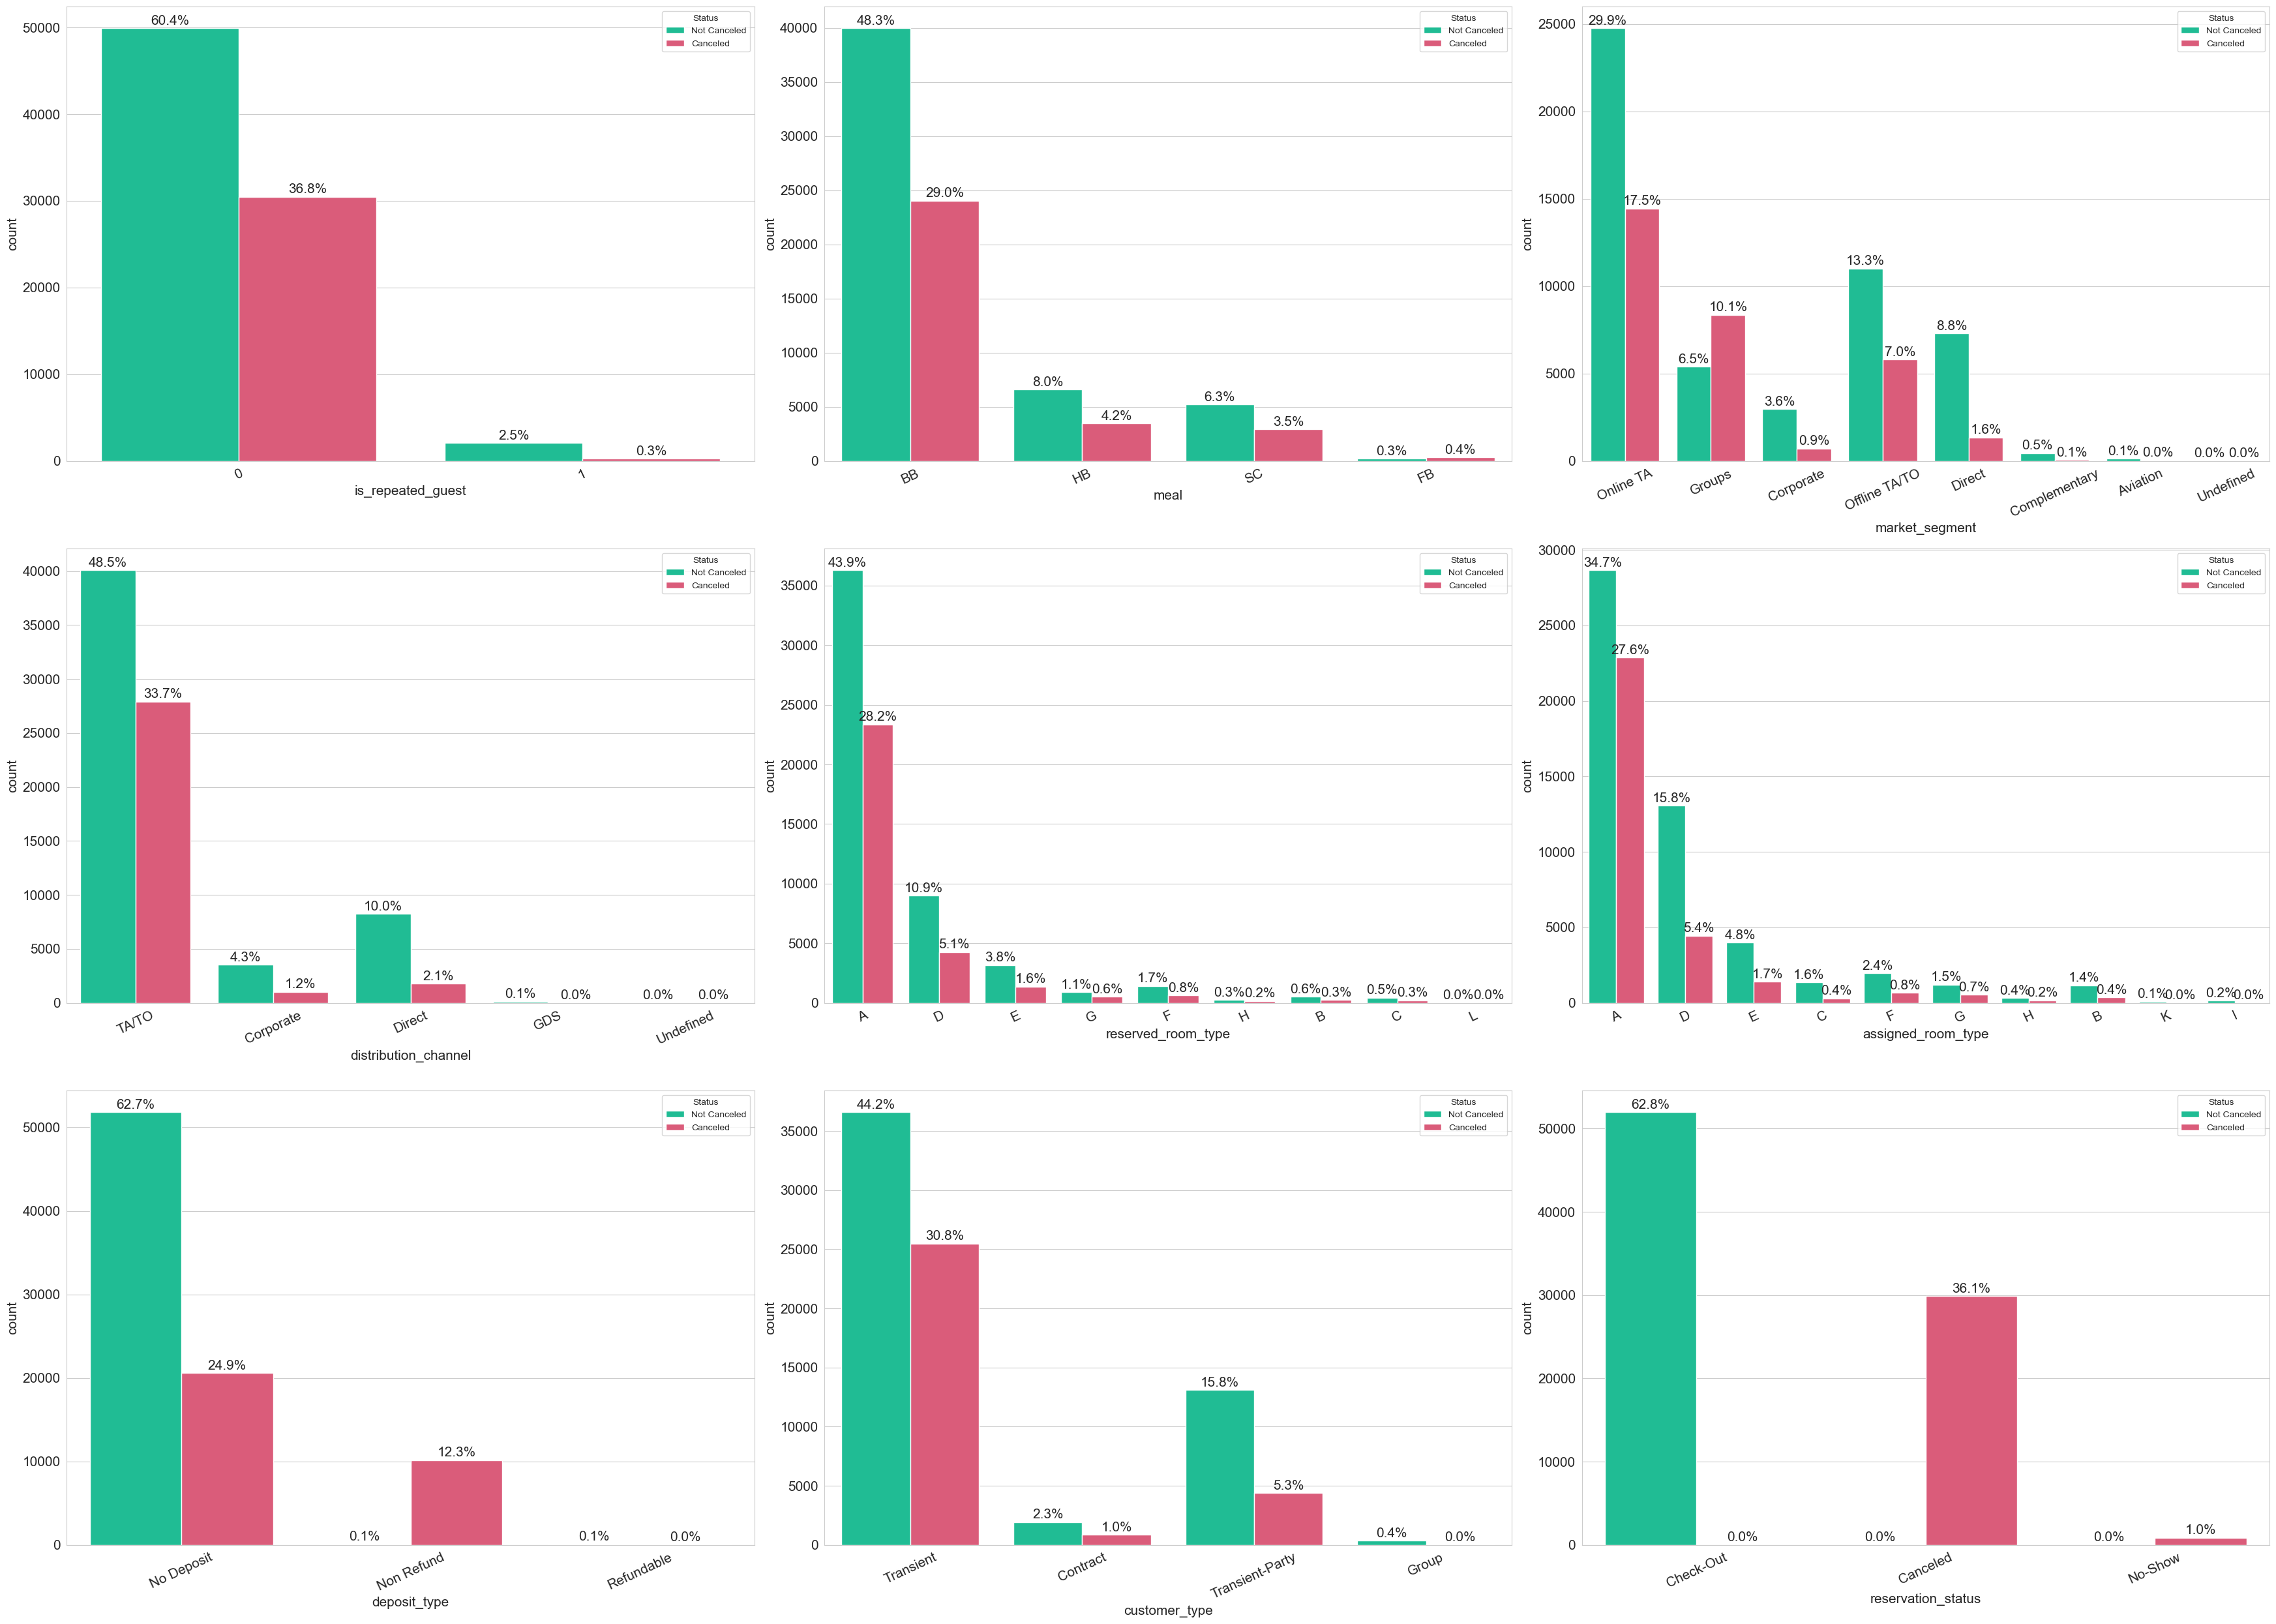

In [66]:
column = ['is_repeated_guest','meal'] + cats_train[3:-2]

plt.figure(figsize=(35,25))
for i, col in enumerate(column):
    plt.subplot(3, 3, i + 1)
    ax = sns.countplot(x=df_train_clean[col], hue=df_train_clean['is_canceled'], 
                palette=['#06d6a0','#ef476f'])
    #Menampilkan persentase
    total = len(df_train_clean)
    for p in ax.patches:
        percent = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percent, (x, y), ha='center', va='center', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('count', fontsize=15)
    plt.xticks(rotation=25)
    plt.legend(title='Status', labels=['Not Canceled','Canceled'])

plt.tight_layout()
plt.show()

#### Cancelation Based on Numerical Data

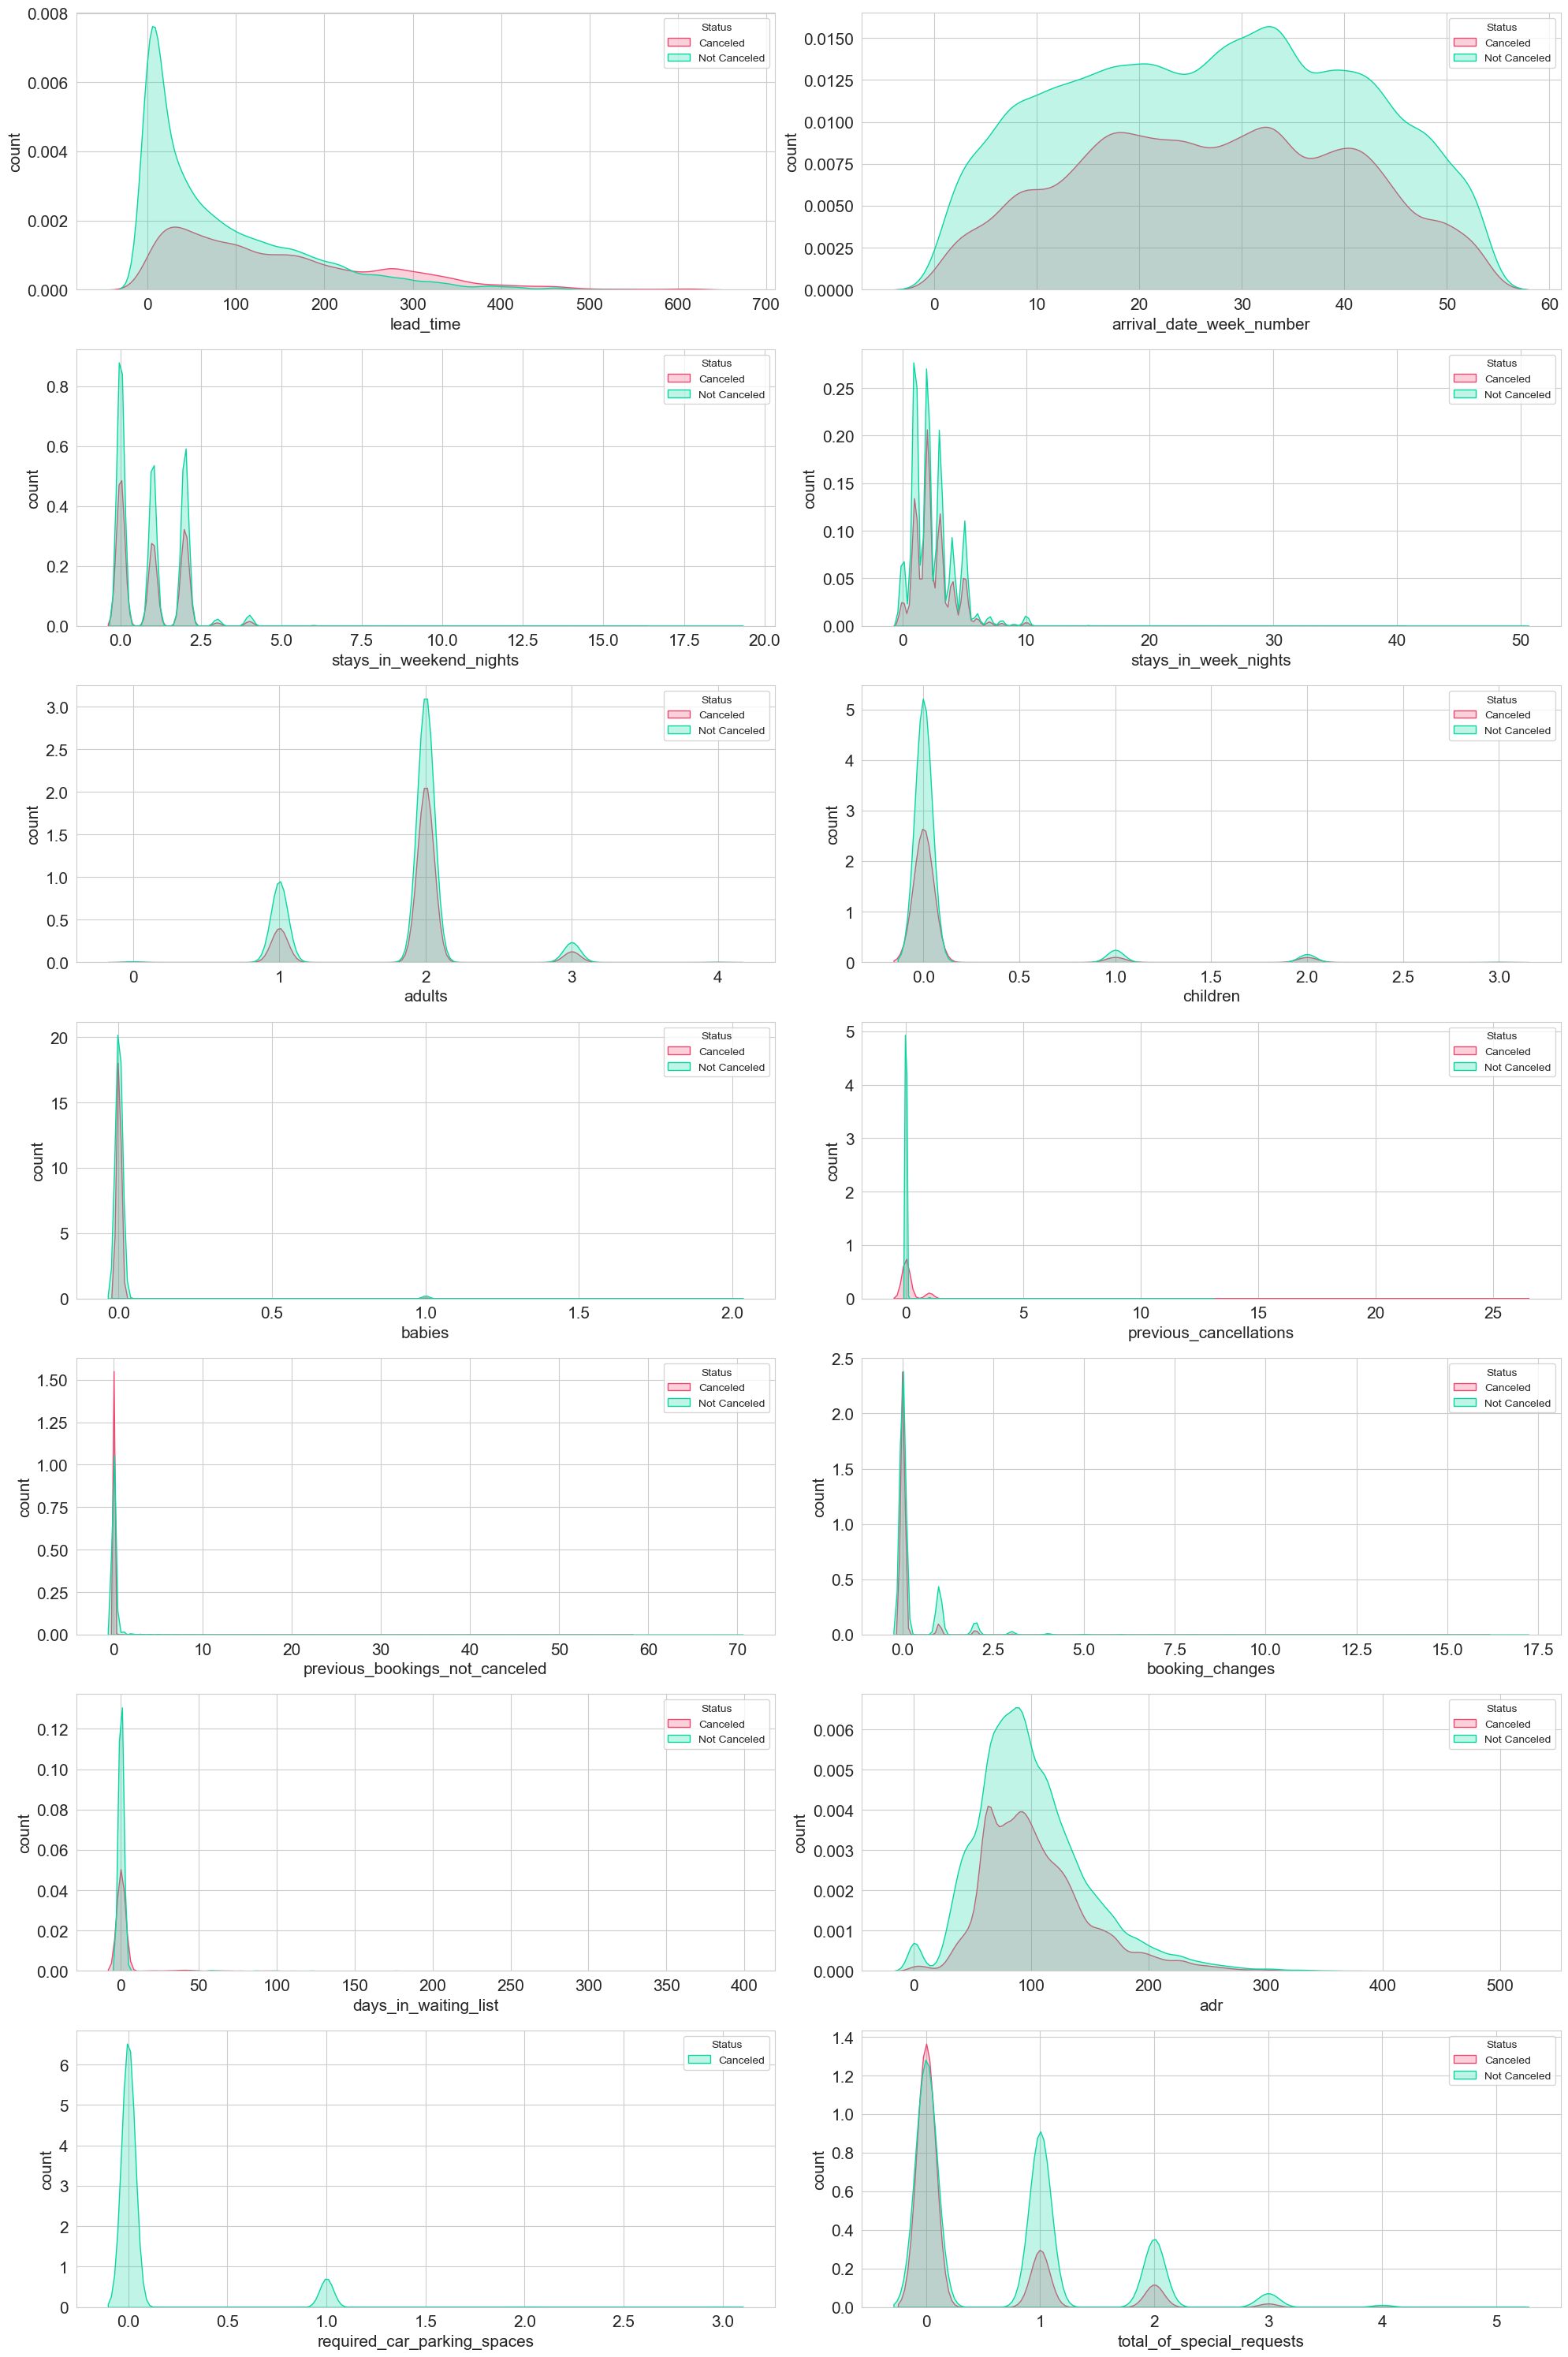

In [67]:
column = nums_train

plt.figure(figsize=(20,30))

for i in range(len(column)):
    plt.subplot(7,2,i+1)
    sns.kdeplot(x=df_train_clean[column[i]], hue=df_train_clean['is_canceled'], fill=True, palette=['#06d6a0','#ef476f'])
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(column[i],fontsize=15)
    plt.ylabel('count',fontsize=15)
    plt.legend(title='Status', labels=['Canceled','Not Canceled'])
plt.tight_layout()
plt.show()

#### Cancelation Based on Date Data

In [68]:
column = date_train + ['is_canceled']

In [69]:
year = df_train_clean[column]
count_year = year.groupby(['arrival_date_year','is_canceled'])['is_canceled'].size().reset_index(name='count')
count_year

arrival_date_year  is_canceled  count
0               2017            0   9627
1               2017            1   5524
2               2018            0  25116
3               2018            1  14215
4               2019            0  17227
5               2019            1  10994

**Year to Year Hotel Booking**

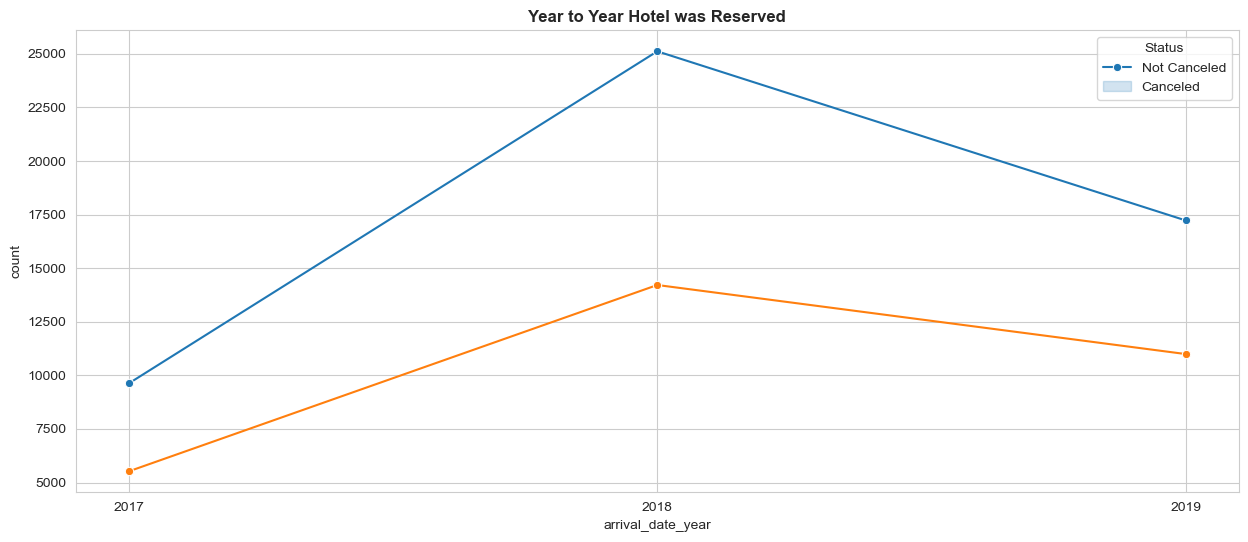

In [70]:
year = df_train_clean[column]

count_year = year.groupby(['arrival_date_year','is_canceled'])['is_canceled'].size().reset_index(name='count')

plt.figure(figsize=(15,6))

sns.lineplot(x=count_year['arrival_date_year'],y = count_year['count'], hue = count_year['is_canceled'], marker ='o')
plt.title('Year to Year Hotel was Reserved', fontweight='bold')
plt.legend(title='Status', labels=['Not Canceled','Canceled'])
plt.xticks([2017,2018,2019])
plt.show()

**Observation**

Bahwa cancelation tertinggi pada tahun 2018 seiring dengan jumlah pesanan yang tinggi pada tahun tersebut

**Monthly Hotel Booking**

In [71]:
month = df_train_clean[column]

month['month_year'] = pd.to_datetime(month['arrival_date_year'].astype(str) + '-' + month['arrival_date_month'].astype(str))
count_month = month.groupby(['month_year','is_canceled']).size().reset_index(name='count')
count_month['month_year'] = count_month['month_year'].dt.strftime('%B %Y')

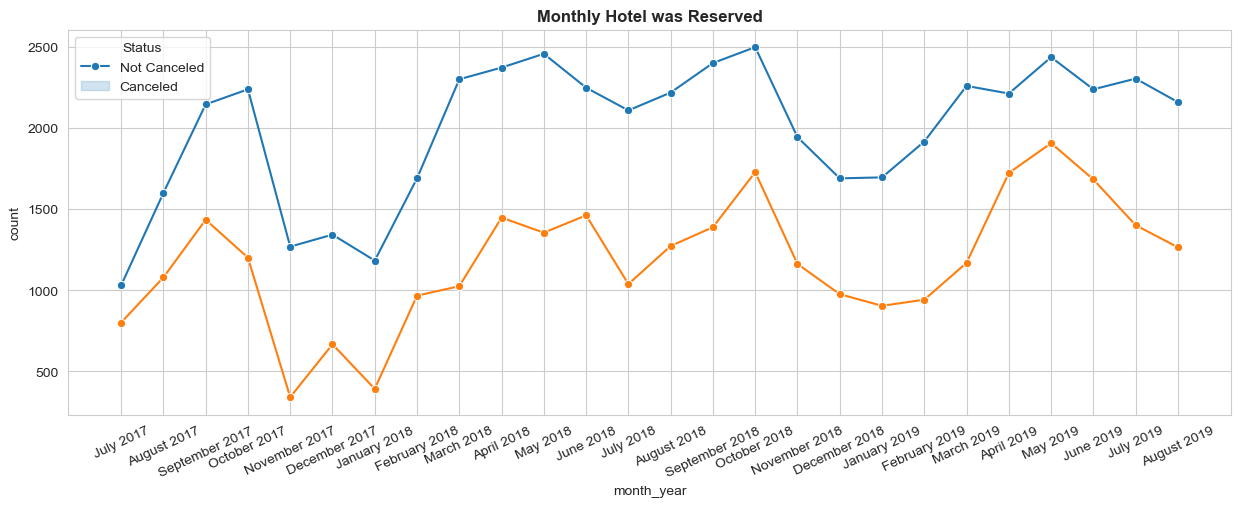

In [72]:
plt.figure(figsize=(15,5))

sns.lineplot(x=count_month['month_year'],y=count_month['count'], hue=count_month['is_canceled'], marker ='o')

plt.title('Monthly Hotel was Reserved', fontweight='bold')
plt.xticks(rotation=25)
plt.legend(title='Status', labels=['Not Canceled','Canceled'])
plt.show()

**Observation**

Terlihat cancelation tertinggi pada bulan Mei 2019 padahal pesanan tertinggi terjadi pada bulan Oktober 2018. Dan terlihat adanya pattern cancelation setiap tahunnya yaitu terjadi pada musim liburan (September, Oktober dan May)

**Daily Hotel Booking**

In [73]:
df_train_clean[column]

arrival_date_year arrival_date_month  arrival_date_day_of_month  \
0                   2019            January                         10   
1                   2018           December                         15   
2                   2019                May                         19   
3                   2018            October                         17   
4                   2017          September                         26   
...                  ...                ...                        ...   
83288               2018            October                         25   
83289               2017          September                         14   
83290               2019               June                         21   
83291               2018               July                         31   
83292               2018            October                         20   

      reservation_status_date  is_canceled  
0                  2019-01-14            0  
1                  2017-10-21            1  
2                  2018-11-25            1  
3                  2018-10-18            0  
4                  2017-08-24            1  
...                       ...          ...  
83288              2018-10-27            0  
83289              2017-09-18            0  
83290              2019-07-05            0  
83291              2018-08-06            0  
83292              2018-10-25            0  

[82703 rows x 5 columns]

In [74]:
daily_booking = df_train_clean[column]
daily = daily_booking.groupby(['arrival_date_day_of_month', 'is_canceled']).size().reset_index(name='count')

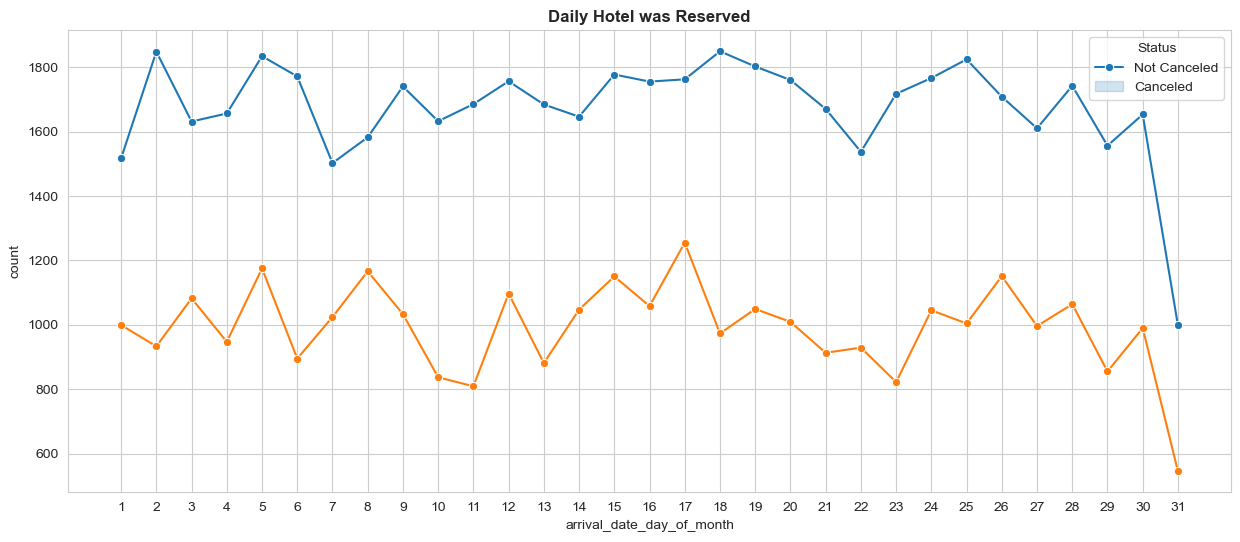

In [75]:
plt.figure(figsize=(15,6))

sns.lineplot(x=daily['arrival_date_day_of_month'],y=daily['count'], marker='o', hue=daily['is_canceled'])
plt.xticks(range(1,32))
plt.title('Daily Hotel was Reserved', fontweight='bold')
plt.legend(title='Status', labels=['Not Canceled','Canceled'])
plt.show()

**Observation**

Cancelation berdasarkan tanggal hampir stagnan kecuali pada tanggal 31 dimana tanggal tersebut jumlah cancelation lebih kecil dibandingkan tanggal lainnya. Karena tanggal 31 hanya ada setengahnya dalam 1 tahun

## Multivariate Analysis

### Heatmap Correlation 

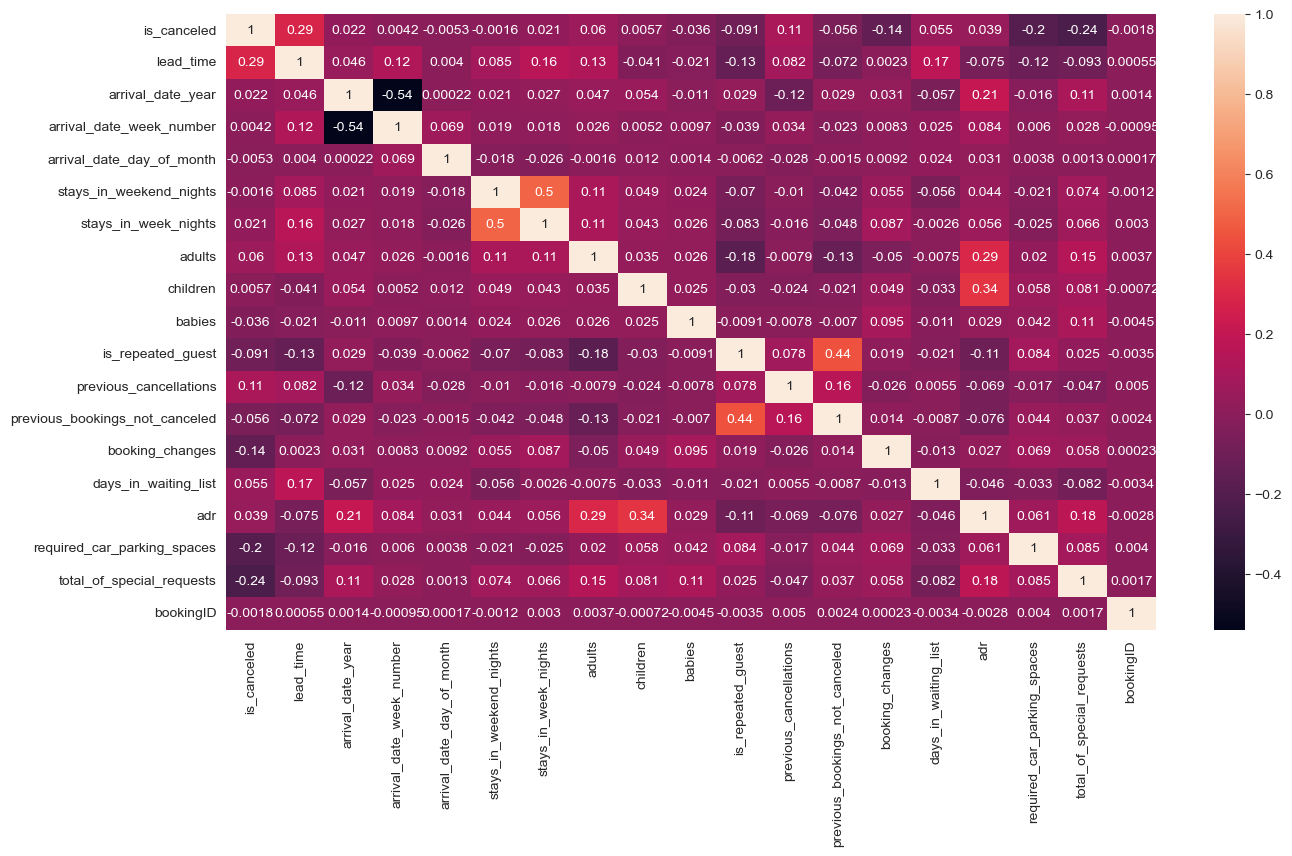

In [76]:
plt.figure(figsize=(15,8))

sns.heatmap(df_train_clean.corr(), annot=True)
plt.show()

In [77]:
df_train_clean[1:].corr()['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.289031
previous_cancellations            0.106359
adults                            0.060226
days_in_waiting_list              0.054660
adr                               0.038682
arrival_date_year                 0.021719
stays_in_week_nights              0.021007
children                          0.005650
arrival_date_week_number          0.004170
stays_in_weekend_nights          -0.001648
bookingID                        -0.001783
arrival_date_day_of_month        -0.005301
babies                           -0.035695
previous_bookings_not_canceled   -0.055560
is_repeated_guest                -0.090535
booking_changes                  -0.144033
required_car_parking_spaces      -0.196351
total_of_special_requests        -0.235488
Name: is_canceled, dtype: float64

**Observation**

Berdasarkan heatmap masing-masing fitur tidak terdapat korelasi yang sangat kuat, korelasi positif yang cukup kuat terdapat pada `previous_bookings_not_canceled` dengan `is_repeated_guest` sebesar 0.44 artinya bahwa dengan booking yang tidak cancel kemungkinan customer akan melakukan booking kembali dan juga berlaku sebaliknya. Lalu terdapat korelasi yang cukup kuat juga antara `children, adults` dan `adr` artinya dengan bertambahnya jumlah pemesan yang menginap atau membawa anak maka akan bertambah juga `adr` sedangkan untuk `is_canceled` dan `lead_time` korelasi sebesar 0.29 artinya kemungkinan cancel terjadi apabila waktu tunggu semakin tinggi dan sebaliknya.

## Deep Dive Analysis

In [78]:
df_train2 = df_train_clean.copy()

### Question 1 : Bagaimana tren pemesanan hotel? kapan terjadinya pembatalan pesanan?

#### Trend Pemesanan Hotel

In [79]:
df_train2['arrive_date'] = pd.to_datetime(df_train2['arrival_date_year'].astype(str) + '-' + df_train2['arrival_date_month'].astype(str) + '-' + df_train2['arrival_date_day_of_month'].astype(str))

In [80]:
book_trend = df_train2.groupby('arrive_date')['arrive_date'].size().reset_index(name='count')

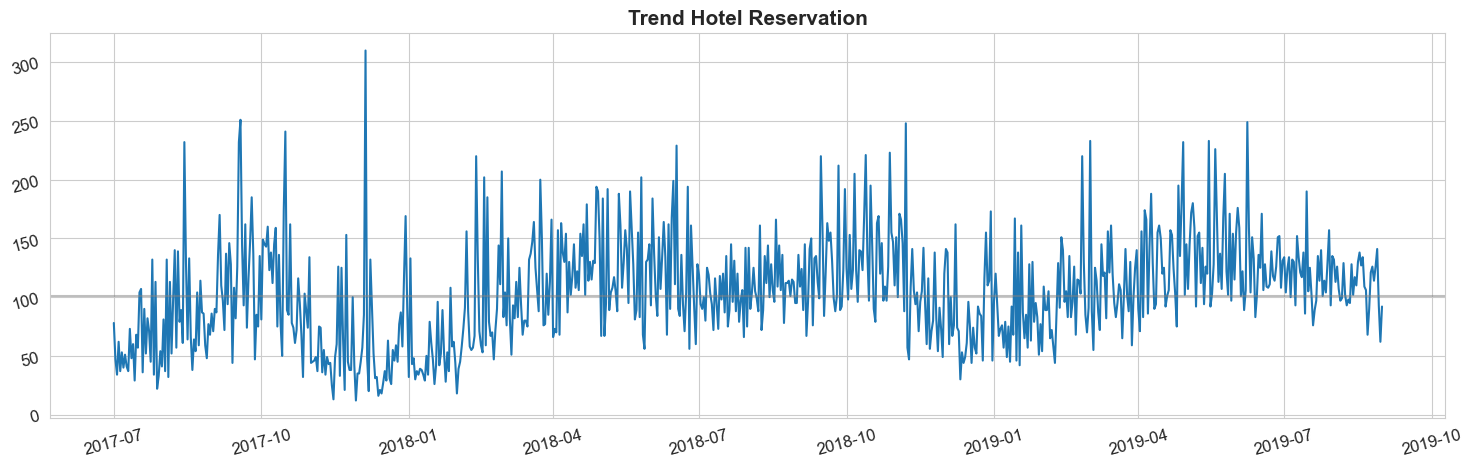

In [81]:
plt.figure(figsize=(18,5))
sns.lineplot(data=book_trend, x='arrive_date', y = 'count')

plt.axhline(y=book_trend['count'].median(), color='gray', alpha=0.5)
plt.xlabel(None)
plt.ylabel(None)
plt.tick_params(axis='both', labelsize= 12, rotation = 15)

plt.title('Trend Hotel Reservation',fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

In [82]:
print('Jumlah Pesanan Hotel Perhari :',round(book_trend['count'].median()))

Jumlah Pesanan Hotel Perhari : 101


**Observation**

Bahwa setiap harinya terdapat 101 pesanan hotel (median)

#### Trend Cancelation Booking Hotel By Year

In [83]:
df_train2['is_canceled'] = df_train2['is_canceled'].map({0:'not canceled', 1:'canceled'})

In [84]:
year_canceled = df_train2.groupby(['arrival_date_year','is_canceled'])['is_canceled'].size().reset_index(name='count')

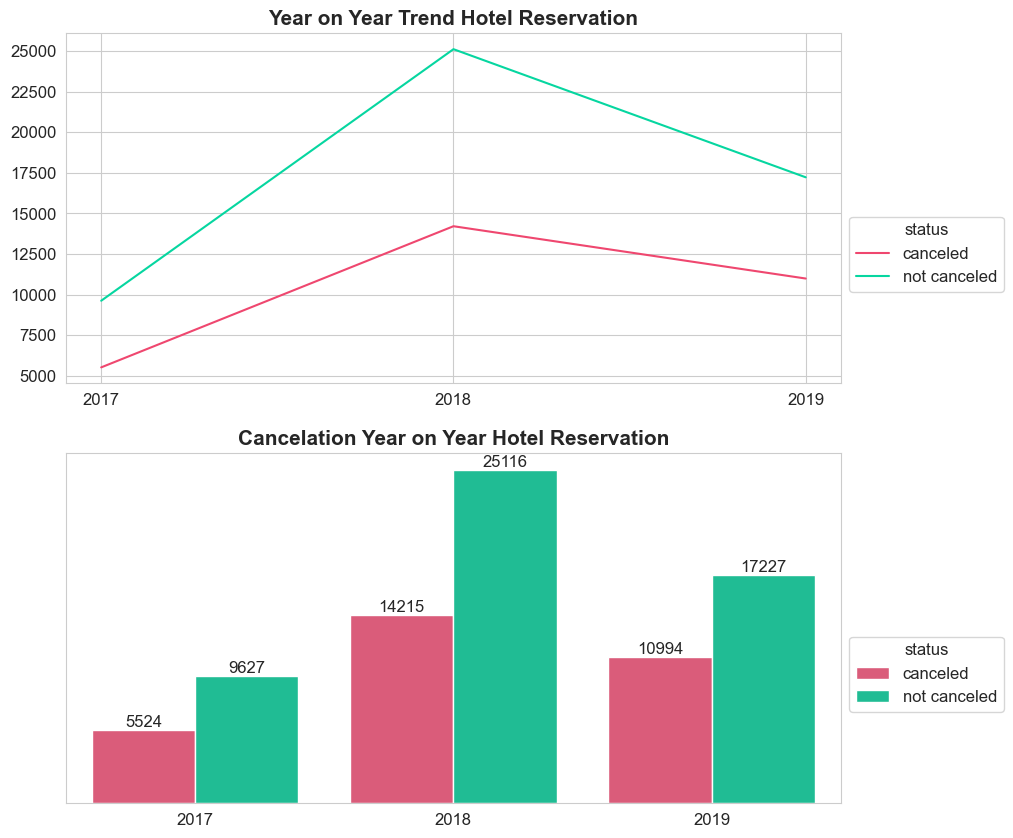

In [85]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,10))
color = ['#ef476f','#06d6a0']
sns.lineplot(x= year_canceled['arrival_date_year'], y=year_canceled['count'], hue = year_canceled['is_canceled'], 
             palette=color, ax=ax[0])
ax[0].set_xticks([2017,2018,2019])
ax[0].legend(title='status', fontsize = 12, title_fontsize=12, bbox_to_anchor=(1, 0, 0, 0.5))
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title('Year on Year Trend Hotel Reservation', fontdict={'fontsize':15,'fontweight':'bold'})

sns.barplot(data = year_canceled, x= 'arrival_date_year', y='count', hue='is_canceled', ax=ax[1], palette=color)
ax[1].bar_label(ax[1].containers[0], fontsize=12)
ax[1].bar_label(ax[1].containers[1], fontsize=12)
ax[1].legend(title='status', fontsize = 12, title_fontsize=12, bbox_to_anchor=(1, 0, 0, 0.5))
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].set_title('Cancelation Year on Year Hotel Reservation', fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

In [86]:
year_total = year_canceled.groupby('arrival_date_year')['count'].sum().reset_index()
year_percentage = year_canceled.merge(year_total, how='inner', on='arrival_date_year')
year_percentage['percentage'] = round(year_percentage['count_x'] / year_percentage['count_y'] *100,2)
year_percentage.drop('count_y', axis=1, inplace=True)
year_percentage[year_percentage['is_canceled']=='canceled']

arrival_date_year is_canceled  count_x  percentage
0               2017    canceled     5524       36.46
2               2018    canceled    14215       36.14
4               2019    canceled    10994       38.96

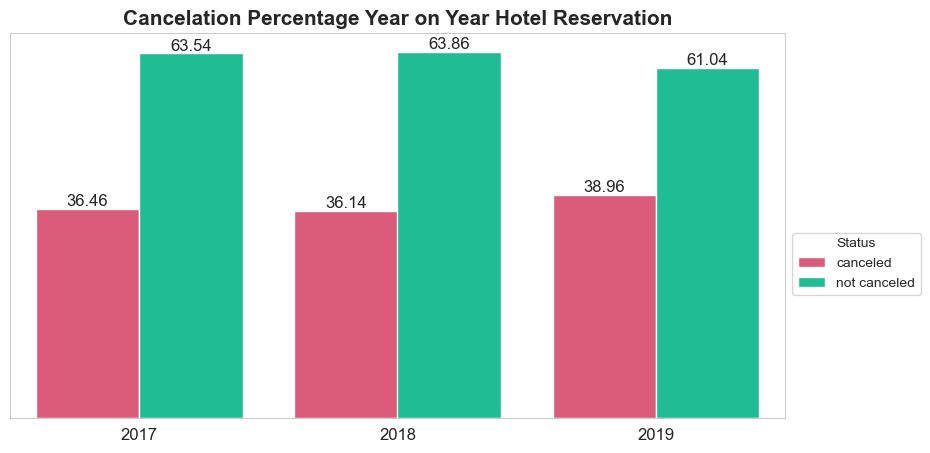

In [87]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = year_percentage, x= 'arrival_date_year', y='percentage', hue='is_canceled', palette=color)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.legend(title = 'Status', loc='best', bbox_to_anchor=(1, 0, 0, 0.5))
plt.title('Cancelation Percentage Year on Year Hotel Reservation', fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

**Observation**

Walaupun jumlah pesanan canceled tertinggi pada tahun 2018 seiring dengan pesanan hotel yang tinggi pada tahun tersebut, tetapi jumlah persentase cancelation justru meningkat setiap tahunnya

#### Trend Cancellation Booking Hotel By Month

In [88]:
df_train2['monthly_canceled'] = pd.to_datetime(df_train2['arrive_date']).dt.to_period('M')
month_canceled = df_train2.groupby(['monthly_canceled','is_canceled'])['is_canceled'].size().reset_index(name='count')
month_canceled['monthly_canceled'] = month_canceled['monthly_canceled'].dt.strftime('%B %Y')

In [89]:
month_canceled = month_canceled[month_canceled['is_canceled']=='canceled']

In [90]:
month_reserve_total = df_train2.groupby('monthly_canceled')['monthly_canceled'].size().reset_index(name='count')
month_reserve_total['monthly_canceled'] = month_reserve_total['monthly_canceled'].dt.strftime('%B %Y')

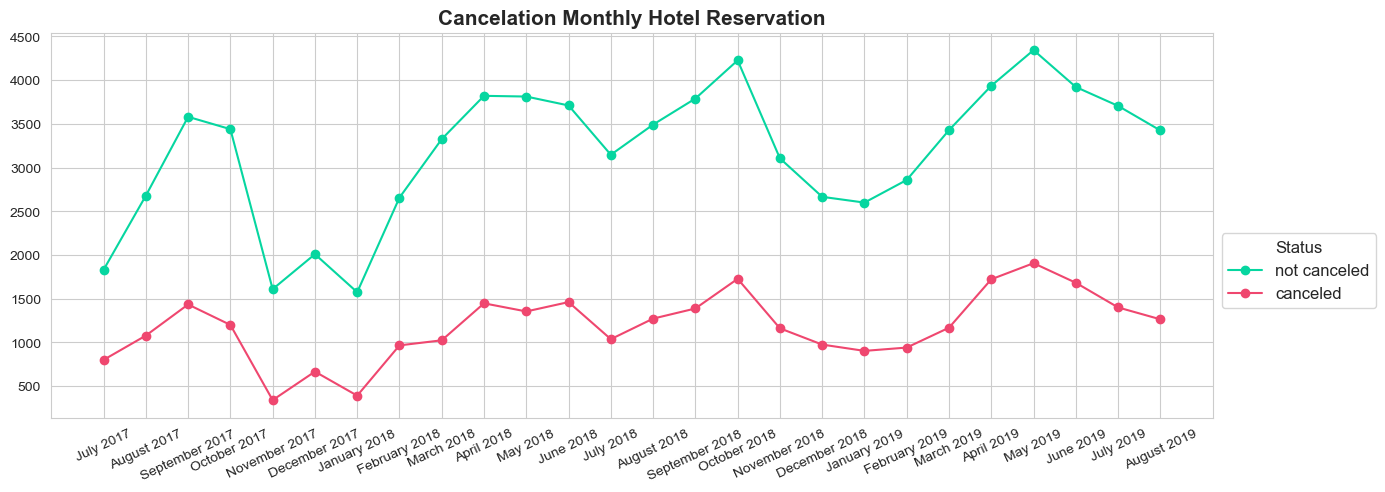

In [91]:
plt.figure(figsize=(15,5))

plt.plot(month_reserve_total['monthly_canceled'],month_reserve_total['count'], marker='o', label = 'not canceled', color='#06d6a0')
plt.plot(month_canceled['monthly_canceled'],month_canceled['count'], marker='o', label = 'canceled', color='#ef476f')
plt.xticks(rotation=25)
plt.legend(title='Status', fontsize = 12, title_fontsize=12, bbox_to_anchor=(1, 0, 0, 0.5))
plt.title('Cancelation Monthly Hotel Reservation', fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

**Observation**

Pesanan hotel tertinggi setiap tahunnya yaitu pada bulan September 2017, Oktober 2018 dan May 2019 karena bulan tersebut bulan yang tepat untuk melakukan liburan dan seiring pesanan tinggi pada bulan tersebut maka pembatalan pesanan yang tinggi pun terjadi. Selain itu terlihat juga pattern bahwa penurunan pesanan hotel terjadi pada saat memasuki awal tahun (bulan Januari)

In [92]:
month_booking = df_train2[['arrival_date_year','arrival_date_month','is_canceled']]

In [93]:
#mean total booking month
mean_booking_month = month_booking.groupby(['arrival_date_year','arrival_date_month'])['is_canceled'].size().reset_index(name='count')
mean_booking_month = mean_booking_month.groupby('arrival_date_month')['count'].mean().reset_index()
mean_booking_month['count'] = mean_booking_month['count'].astype('int64')

#mean cancel booking month
mean_cancel_booking_month = month_booking[month_booking['is_canceled'] ==  'canceled']
mean_cancel_booking_month = mean_cancel_booking_month.groupby(['arrival_date_year','arrival_date_month'])['is_canceled'].size().reset_index(name='count')
mean_cancel_booking_month = mean_cancel_booking_month.groupby('arrival_date_month')['count'].mean().reset_index()
mean_cancel_booking_month['count'] = mean_cancel_booking_month['count'].astype('int64')

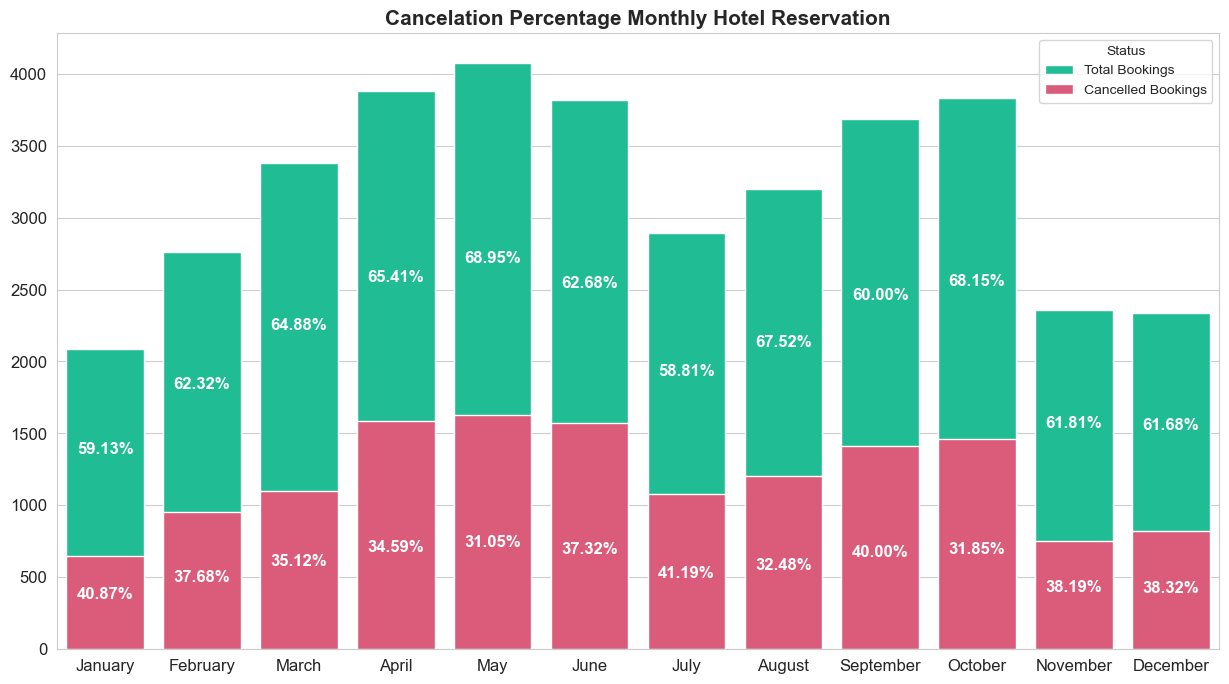

In [94]:
plt.figure(figsize=(15, 8))

order_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Assuming total_booking_month and cancel_booking_month are DataFrames with 'index' and 'count' columns
rect1 = sns.barplot(data=mean_booking_month, x='arrival_date_month', y='count', order=order_month, color='#06d6a0', label='Total Bookings')
rect2 = sns.barplot(data=mean_cancel_booking_month, x='arrival_date_month', y='count', order=order_month, color='#ef476f', label='Cancelled Bookings')

# Calculate total for each month
totals = mean_booking_month['count']

# Add percentages to the middle of each stack bar
for i, (value1, value2, total) in enumerate(zip(mean_booking_month['count'], mean_cancel_booking_month['count'], totals)):
    percentage1 = ((value1 - value2) / total) * 100
    percentage2 = (value2 / total) * 100
    plt.text(rect1.patches[i].get_x() + rect1.patches[i].get_width() / 2, rect1.patches[i].get_y() + rect1.patches[i].get_height() / 1.5,
             f'{percentage1:.2f}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    
    plt.text(rect2.patches[i].get_x() + rect2.patches[i].get_width() / 2, rect2.patches[i].get_y() + rect2.patches[i].get_height() / 5.5,
             f'{percentage2:.2f}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add legend
plt.legend(loc='upper right', title='Status')
plt.xlabel(None)
plt.ylabel(None)
plt.tick_params(axis='both', labelsize=12)
plt.title('Cancelation Percentage Monthly Hotel Reservation', fontdict={'fontsize':15,'fontweight':'bold'})

plt.show()

**Observation**

Pesanan Hotel tertinggi yaitu pada bulan Mei dan tingkat pembatalan pesanan pun rendah, pesanan tinggi tersebut terjadi karena bulan maret - mei waktu yang tepat untuk berliburan, sedangkan tingkat pembatalan pesanan tertinggi yaitu terdapat pada bulan July dan bulan Januari

#### Trend Cancellation Booking Hotel By Date

In [95]:
date_booking = df_train2[['arrive_date','is_canceled']]
date_canceled = date_booking.groupby(['arrive_date','is_canceled'])['is_canceled'].size().reset_index(name='count')

Jumlah Median canceled 34.0
Jumlah Median not canceled 65.0


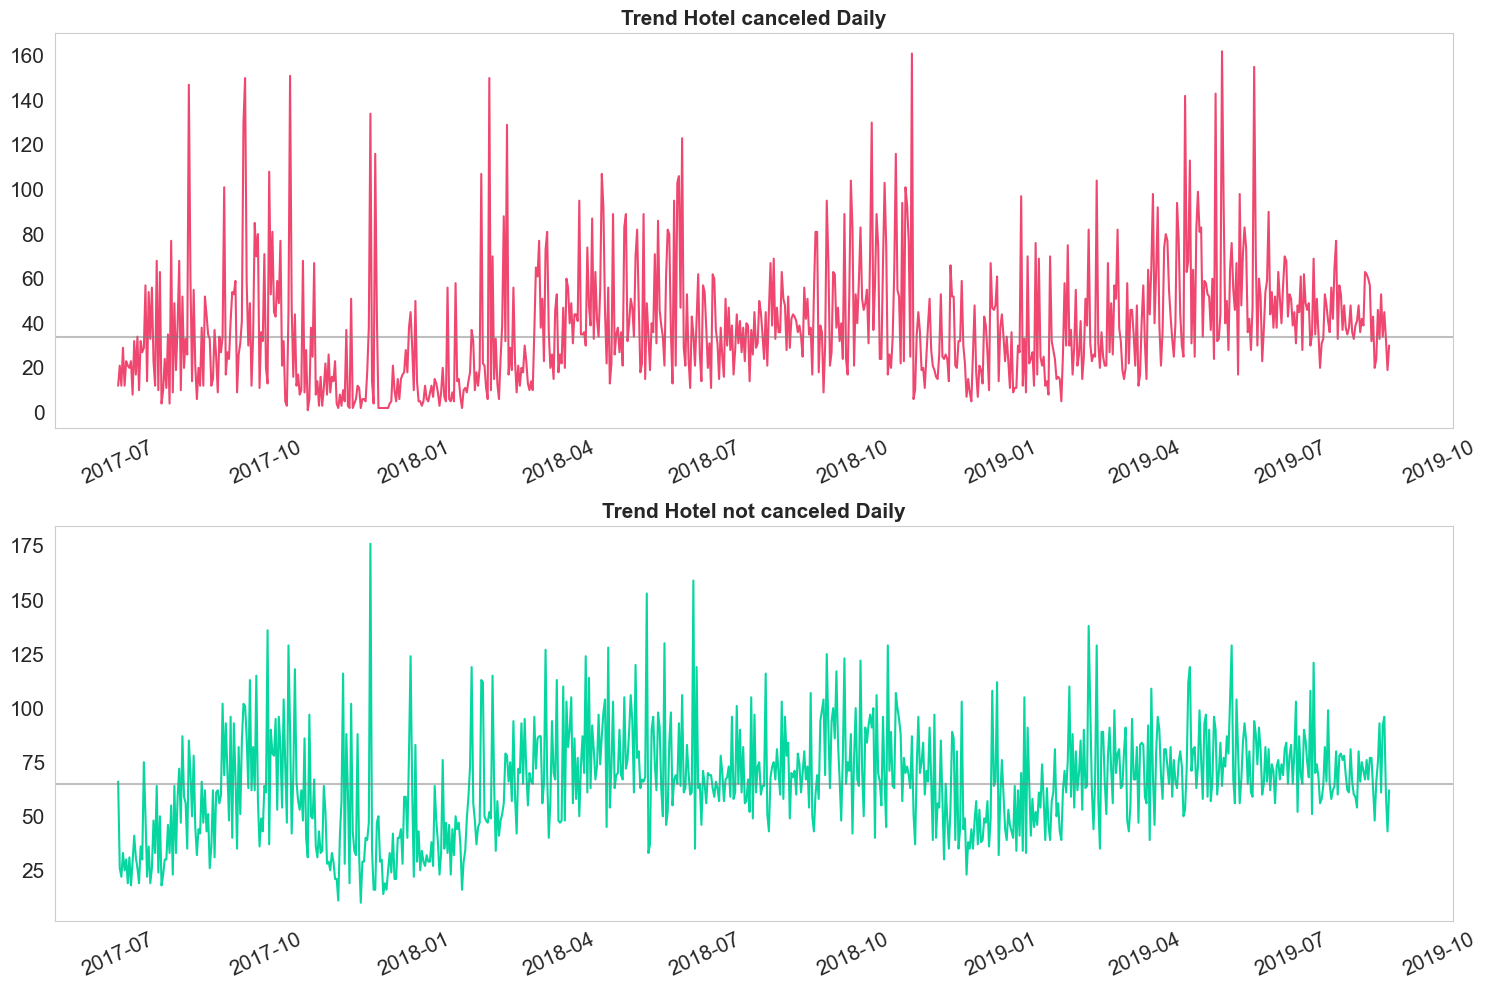

In [588]:
plt.figure(figsize=(15,10))

cancel_type = ['canceled','not canceled']
colors = ['#ef476f','#06d6a0']
for i, col in enumerate(cancel_type):
    plt.subplot(2,1,i+1)
    fitur = date_canceled[date_canceled['is_canceled'] == col]
    plt.plot(fitur['arrive_date'],fitur['count'], color = colors[i])
    plt.axhline(y=fitur['count'].median(), color='gray',alpha =.5)
    plt.title(f'Trend Hotel {col} Daily',fontdict={'fontsize':15, 'fontweight':'bold'})
    plt.xticks(rotation=25)
    plt.grid(None)
    plt.tick_params(axis='both', labelsize=15)
    print(f'Jumlah Median {col} {fitur["count"].median()}')

plt.tight_layout()
plt.show()

**Observation**

- terdapat 34 cancellation setiap harinya (median)
- terdapat 65 non cancellation setiap harinya tetapi terdapat pola bahwa hampir non cancellation menurun pada bulan setiap awal tahun (Januari)

### Question 2 : Kriteria customer seperti apa yang sering membatalkan pesanan?

#### Cancellation by Customer Category

In [97]:
df_train2['customer_category'] = np.where((df_train2['adults'] ==  1) | (df_train2['children'] == 1) & (df_train2['babies'] == 0), 'Solo', 'Group')
df_train2['customer_category'] = np.where((df_train2['adults'] ==  2) | (df_train2['children'] == 2) & (df_train2['babies'] == 0), 'Couple', df_train2['customer_category'])
df_train2['customer_category'] = np.where((df_train2['adults'] >=  1) & (df_train2['children'] > 0) | (df_train2['babies'] > 0), 'Family', df_train2['customer_category'])

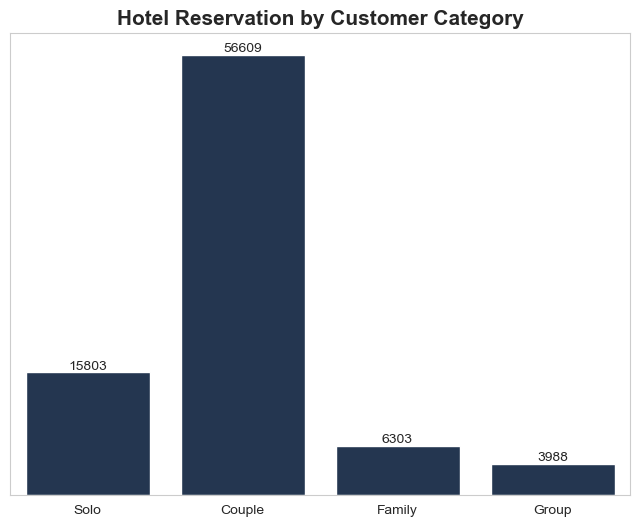

In [98]:
plt.figure(figsize=(8,6))

order_customer = ['Solo','Couple','Family','Group']
ax = sns.countplot(data = df_train2, x='customer_category', order = order_customer,palette=['#1d3557'])
ax.bar_label(ax.containers[0])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Hotel Reservation by Customer Category',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

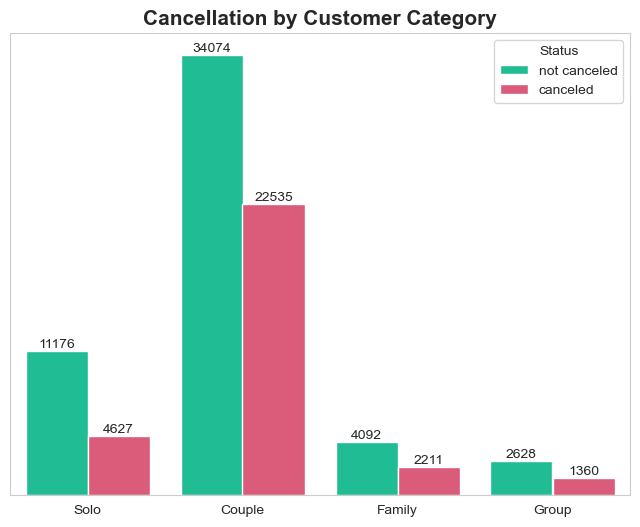

In [99]:
plt.figure(figsize=(8,6))

order_customer = ['Solo','Couple','Family','Group']
ax = sns.countplot(data = df_train2, x='customer_category', hue='is_canceled', order = order_customer,palette=['#06d6a0','#ef476f'])
ax.legend(title='Status')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Cancellation by Customer Category',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

#### Cancelation by Customer Type

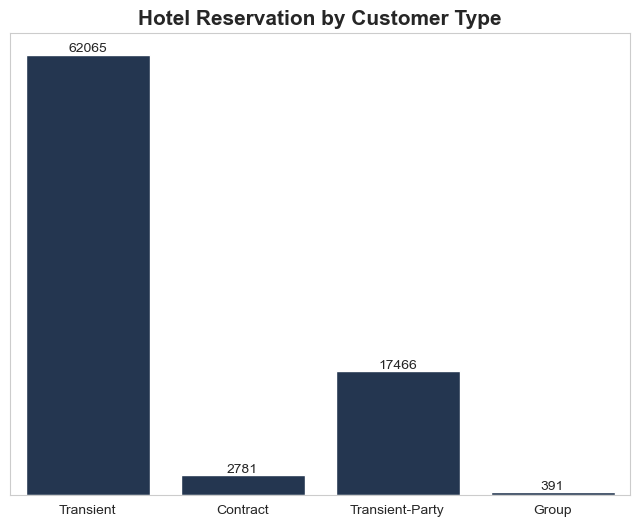

In [100]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data = df_train2, x='customer_type', palette=['#1d3557'])
ax.bar_label(ax.containers[0])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Hotel Reservation by Customer Type',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

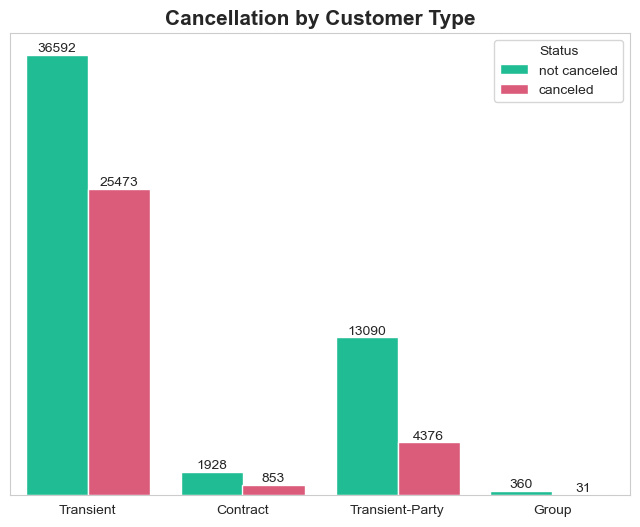

In [101]:
plt.figure(figsize=(8,6))

ax = sns.countplot(data = df_train2, x='customer_type', hue='is_canceled',palette=['#06d6a0','#ef476f'])
ax.legend(title='Status')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Cancellation by Customer Type',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

#### Cancelation by Customer Origin

In [102]:
customer_origin = df_train2[['country','bookingID','is_canceled']]
customer_country = customer_origin.groupby('country')['bookingID'].size().reset_index(name='Count')

customer_origin_canceled = customer_origin[customer_origin['is_canceled']=='canceled']
customer_origin_canceled = customer_origin_canceled.groupby('country')['bookingID'].size().reset_index(name='Canceled')


combined_customer_origin = customer_country.merge(customer_origin_canceled, how='inner', on='country')
combined_customer_origin['percentage'] = round(combined_customer_origin['Canceled'] / combined_customer_origin['Count'] * 100,2)
combined_customer_sort = combined_customer_origin.sort_values(['Count','percentage'], ascending=[False,False]).head(5)
combined_customer_sort

country  Count  Canceled  percentage
93     PRT  33819     19174       56.70
40     GBR   8357      1692       20.25
37     FRA   7225      1326       18.35
33     ESP   5879      1517       25.80
27     DEU   5105       845       16.55

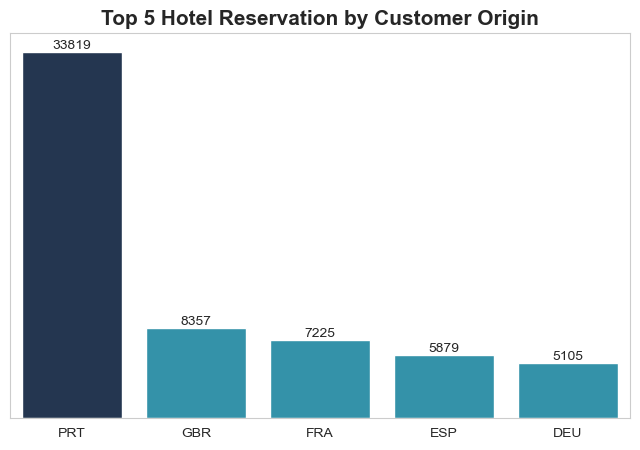

In [103]:
plt.figure(figsize=(8,5))

ax = sns.barplot(data = combined_customer_sort, x='country', y='Count',palette=np.where(combined_customer_sort.Count == combined_customer_sort.Count.max(), '#1d3557', '#219ebc'))
ax.bar_label(ax.containers[0])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Top 5 Hotel Reservation by Customer Origin',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

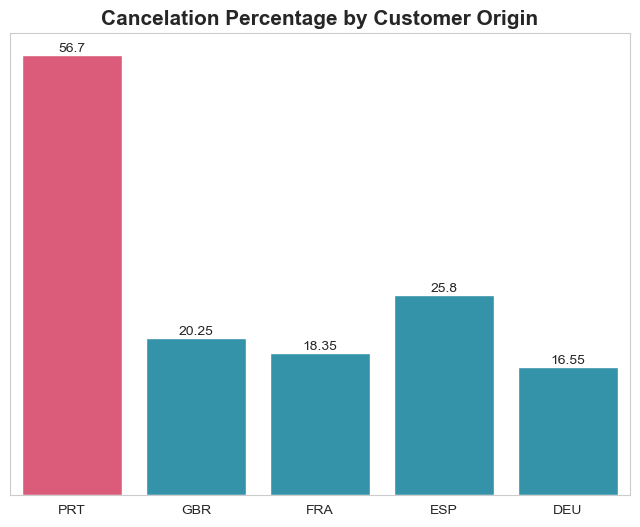

In [104]:
plt.figure(figsize=(8,6))

ax = sns.barplot(data = combined_customer_sort, x='country', y='percentage',palette=np.where(combined_customer_sort.Count == combined_customer_sort.Count.max(), '#ef476f', '#219ebc'))
ax.bar_label(ax.containers[0])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Cancelation Percentage by Customer Origin',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

**Observation**

- Bahwa berdasarkan kategori customer, customer couple cenderung melakukan pembatalan pesanan hotel lebih banyak dibandingkan dengan kategori lainnya yaitu sekitar 40% melakukan pembatalan
- Bahwa berdasarkan customer type, customer Transient lebih cenderung melakukan pembatalan pesanan hotel lebih banyak dibandingkan type lainnya yaitu sebesar 41%.
- Customer Paling banyak berasal dari Negara Portugal bisa diasumsikan bahwa adalah warga lokal dan cancelation terjadi paling banyak berdasarkan negara portugal dengan persentase 56.7%

### Question 3 : Kriteria hotel dan jenis booking apa yang sering terjadi pembatalan pesanan?

#### Most Booking Hotel

In [105]:
hotel_df = df_train2.copy()
hotel_cancel = hotel_df.groupby('hotel').size().reset_index(name='count').sort_values(by='count', ascending=False)
hotel_cancel

hotel  count
39  Renaissance New York Times Square Hotel New Yo...   1367
25                  Las Vegas Marriott Las Vegas, NV    1362
43  Sacramento Airport Natomas Courtyard Sacrament...   1353
14                    Crystal Cove, Barbados Barbados   1348
11  Courtyard by Marriott Paris Gare de Lyon Paris...   1342
..                                                ...    ...
61             W New York – Times Square New York, NY   1243
62             W New York – Union Square New York, NY   1242
42  Residence Inn Rio de Janeiro Barra da Tijuca B...   1241
46  Sheraton Grand Rio Hotel & Resort Rio de Janei...   1239
0   African Pride Melrose Arch, Autograph Collecti...   1235

[64 rows x 2 columns]

In [592]:
hotel_cancel.head(1).values

array([['Renaissance New York Times Square Hotel New York, NY', 1367]],
      dtype=object)

In [106]:
hotel_cancel.describe()

count
count    64.000000
mean   1292.234375
std      32.181402
min    1235.000000
25%    1268.500000
50%    1293.000000
75%    1312.250000
max    1367.000000

**Observation**

Hotel yang sering dipesan yaitu Renaissance New York Times Square Hotel tetapi hal tersebut tidak memperlihatkan bahwa performa hotel bagus, untuk melihat performa hotel tersebut bagus atau tidak harus dibandingkan antara cancel dan non cancelnya. Oleh karena itu akan dibuatkan ratio cancellation setiap hotel dan dilihat ratio cancel paling kecil

#### Ratio Cancel and non Cancellation

In [107]:
#hotel cancel
ratio_hotel_cancel = hotel_df[hotel_df['is_canceled']=='canceled']
ratio_hotel_cancel = ratio_hotel_cancel.groupby('hotel').size().reset_index(name='cancel')

#hotel non cancel
ratio_hotel_noncancel=  hotel_df[hotel_df['is_canceled']=='not canceled']
ratio_hotel_noncancel = ratio_hotel_noncancel.groupby('hotel').size().reset_index(name='non cancel')

#merge untuk menghitung ratio

ratio_hotel = ratio_hotel_cancel.merge(ratio_hotel_noncancel, how = 'inner', on='hotel')
ratio_hotel['ratio'] = round(ratio_hotel['cancel'] / ratio_hotel['non cancel'],2)
ratio_hotel

hotel  cancel  non cancel  \
0   African Pride Melrose Arch, Autograph Collecti...     464         771   
1       Albuquerque Airport Courtyard Albuquerque, NM     482         828   
2                        Anaheim Marriott Anaheim, CA     483         820   
3       Baltimore BWI Airport Courtyard Linthicum, MD     506         815   
4   Baton Rouge Acadian Centre/LSU Area Courtyard ...     484         841   
..                                                ...     ...         ...   
59                       W Barcelona Barcelona, Spain     479         837   
60  W London – Leicester Square London, United Kin...     482         841   
61             W New York – Times Square New York, NY     459         784   
62             W New York – Union Square New York, NY     455         787   
63                           Waves, Barbados Barbados     510         801   

    ratio  
0    0.60  
1    0.58  
2    0.59  
3    0.62  
4    0.58  
..    ...  
59   0.57  
60   0.57  
61   0.59  
62   0.58  
63   0.64  

[64 rows x 4 columns]

**Histogram Ratio Cancellation**

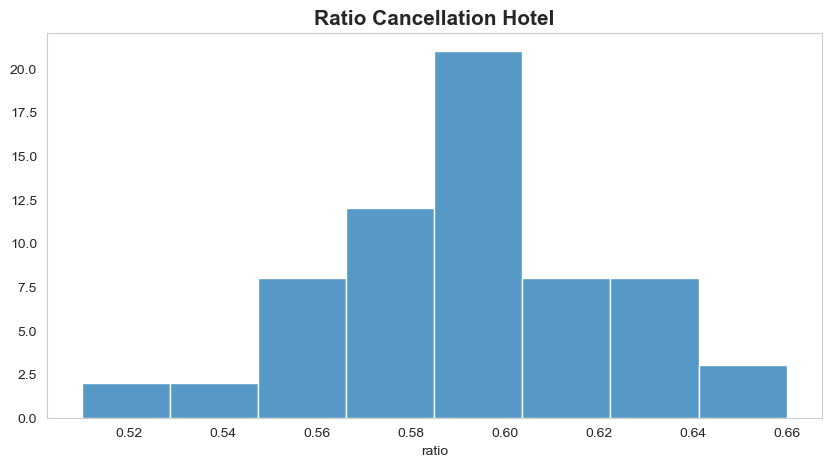

In [108]:
plt.figure(figsize=(10,5))
sns.histplot(ratio_hotel['ratio'])
plt.title(f'Ratio Cancellation Hotel',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.ylabel(None)
plt.grid(None)
plt.show()

**Observation**

terlihat ratio cancellation hotel antara 0.52 - 0.66 yang artinya apabila ada 100 pemesan maka kemungkinan terjadinya cancel yaitu sebanyak 52 - 66 pemesanan

**Hotel with lowest Cancellation Ratio**

In [109]:
ratio_hotel.sort_values('ratio', ascending=True).head(5)

hotel  cancel  non cancel  \
23    Indianapolis Airport Courtyard Indianapolis, IN     434         847   
49  Spokane Downtown at the Convention Center Cour...     434         841   
34  Protea Hotel Fire & Ice! by Marriott Johannesb...     439         817   
18                Greensboro Courtyard Greensboro, NC     439         812   
54               The Ritz-Carlton, Tokyo Tokyo, Japan     452         820   

    ratio  
23   0.51  
49   0.52  
34   0.54  
18   0.54  
54   0.55

**Observation**

Terdapat 5 hotel dengan ratio terendah terjadinya cancellation diantaranya : 
- Indianapolis Airport Courtyard 
- Spokane Downtown at the Convention Center 
- Protea Hotel Fire & Ice! by Marriott 
- Greensboro Courtyard 
- The Ritz-Carlton, Tokyo

#### Booking Details (Cancellation Based on Meal)

In [110]:
meal_cancellation = df_train2.groupby(['meal','is_canceled'])['is_canceled'].size().reset_index(name='count').sort_values(['meal','count'], ascending = [True, False])
meal_cancellation

meal   is_canceled  count
1   BB  not canceled  39973
0   BB      canceled  24021
2   FB      canceled    330
3   FB  not canceled    211
5   HB  not canceled   6588
4   HB      canceled   3453
7   SC  not canceled   5198
6   SC      canceled   2929

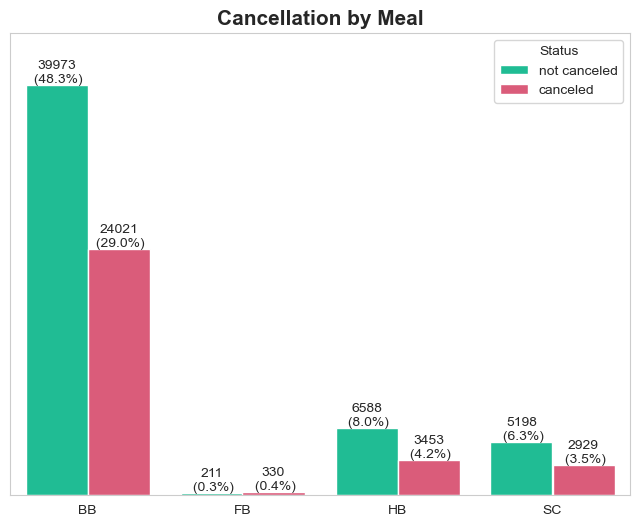

In [111]:
plt.figure(figsize=(8,6))

ax = sns.barplot(data = meal_cancellation, x='meal', y='count', hue='is_canceled', palette=['#06d6a0','#ef476f'])
#Menampilkan persentase
total = meal_cancellation['count'].sum()
for p in ax.patches:
    percent = f'{round(p.get_height())}\n ({100 * p.get_height() / total:.1f}%)\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() +500
    ax.annotate(percent, (x, y), ha='center', va='center')
plt.legend(title='Status')
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title(f'Cancellation by Meal',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.ylim(ymax=45000)
plt.show()

**Observation**

Terlihat bahwa pemesan paling banyak memesan dengan tipe BB dan seiring dengan pesanan tersebut maka cancellation terjadi paling tinggi pada tipe BB lalu perlu diperhatikan juga bahwa tipe FB justru lebih banyak cancel dibandingkan non cancel

#### Booking Details (Market & Distribution Segment)

In [112]:
market_df = df_train2.groupby(['market_segment', 'is_canceled'])['is_canceled'].size().reset_index(name='count')
market_df

market_segment   is_canceled  count
0        Aviation      canceled     40
1        Aviation  not canceled    118
2   Complementary      canceled     56
3   Complementary  not canceled    450
4       Corporate      canceled    703
5       Corporate  not canceled   2959
6          Direct      canceled   1335
7          Direct  not canceled   7286
8          Groups      canceled   8363
9          Groups  not canceled   5393
10  Offline TA/TO      canceled   5793
11  Offline TA/TO  not canceled  11005
12      Online TA      canceled  14442
13      Online TA  not canceled  24759
14      Undefined      canceled      1

In [113]:
distribution_df = df_train2.groupby(['distribution_channel', 'is_canceled'])['is_canceled'].size().reset_index(name='count')
distribution_df

distribution_channel   is_canceled  count
0            Corporate      canceled   1024
1            Corporate  not canceled   3541
2               Direct      canceled   1771
3               Direct  not canceled   8241
4                  GDS      canceled     26
5                  GDS  not canceled    105
6                TA/TO      canceled  27909
7                TA/TO  not canceled  40082
8            Undefined      canceled      3
9            Undefined  not canceled      1

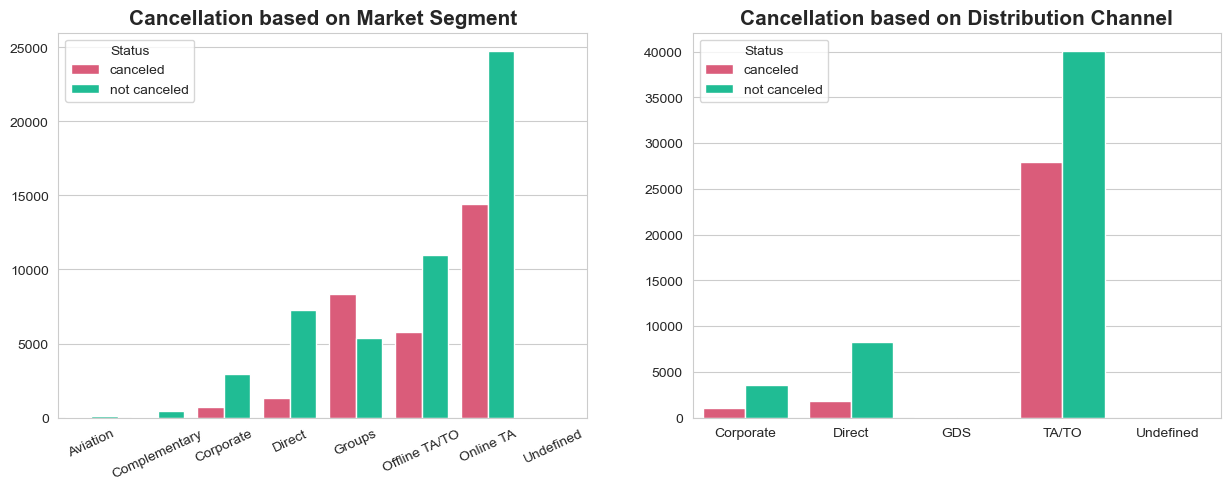

In [114]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

sns.barplot(data = market_df, x= 'market_segment', y='count', hue='is_canceled', ax=ax[0], palette=['#ef476f','#06d6a0'])
ax[0].tick_params(axis='x',rotation = 25)
ax[0].legend(title='Status')
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title('Cancellation based on Market Segment',fontdict={'fontsize':15, 'fontweight':'bold'})

sns.barplot(data = distribution_df, x= 'distribution_channel', y='count', hue='is_canceled', ax=ax[1], palette=['#ef476f','#06d6a0'])
ax[1].legend(title='Status')
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_title('Cancellation based on Distribution Channel',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.tight_layout
plt.show()

**Observation**

- Cancellation terjadi paling banyak pada market segment Online dan Groups sedangkan complementary tidak ada hal ini terdapat beberapa kemungkinan :
    - Tidak ada biaya yang harus dibayarkan oleh pemesan, sehingga mereka mungkin merasa lebih berkomitmen untuk datang ke hotel dan tidak ingin membatalkan reservasi mereka.
    - Menginap gratis biasanya diberikan kepada pemesan yang memiliki loyalitas terhadap hotel atau tamu yang sering menginap di hotel, sehingga mereka cenderung merencanakan perjalanan mereka dengan lebih hati-hati dan kecil kemungkinannya untuk membatalkan reservasi mereka.
    - Jumlah Complementary stay yang tersedia mungkin terbatas, sehingga tamu yang telah memenangkan kesempatan untuk menginap secara gratis dapat merasa lebih bersyukur dan berkomitmen untuk datang ke hotel tersebut
  
  
- Berdasarkan distribution Channel cancelation paling banyak terjadi pada Travel agent dan Tour operator hal ini seiring dengan pesanan yang banyak dilakukan melalui agent perjalanan

#### Booking Details (Repeated Guest)

In [115]:
df_train2['is_repeated_guest'] = df_train2['is_repeated_guest'].map({0:'no',1:'yes'})
cancel_repeated = df_train2.groupby(['is_repeated_guest','is_canceled'])['is_canceled'].count().reset_index(name='count')

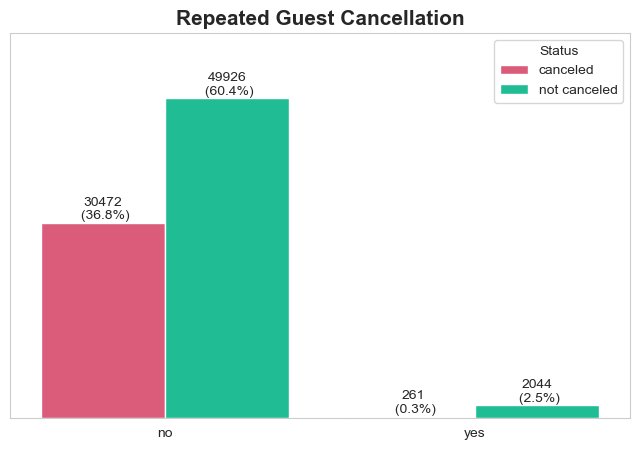

In [116]:
plt.figure(figsize=(8,5))
ax= sns.barplot(data= cancel_repeated, x= 'is_repeated_guest', y = 'count', hue='is_canceled', palette=['#ef476f','#06d6a0'])
for p in ax.patches:
    percent = f'{round(p.get_height())}\n ({100 * p.get_height() / total:.1f}%)\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() +1000
    ax.annotate(percent, (x, y), ha='center', va='center')
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.ylim(ymax=60000)
plt.legend(title='Status')
plt.title(f'Repeated Guest Cancellation',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

**Observation**

- Pelanggan sebelumnya cenderung menjadi pelanggan yang lebih loyal, dengan tingkat pembatalan reservasi yang sangat rendah, yaitu 0,3%. Hal ini dapat mengindikasikan bahwa pelayanan hotel sudah baik, sehingga pelanggan yang sudah pernah menginap cenderung tidak membatalkan reservasi.
- Pelanggan baru cenderung lebih mudah membatalkan reservasi mereka, dengan tingkat pembatalan reservasi sebesar 36,8% kemungkinan karena belum menemukan hotel yang cocok dengan keinginan mereka, pihak perusahaan bisa meningkatkan pelayanan dan memberikan promo sehingga berkurangnya cancellation.

#### Accomodation Details (Cancellation Based on Room)

In [117]:
df_train2['room_different'] = np.where(df_train2['reserved_room_type'] == df_train2['assigned_room_type'],'No','Yes')

**Different between Reserved and Assigned Room**

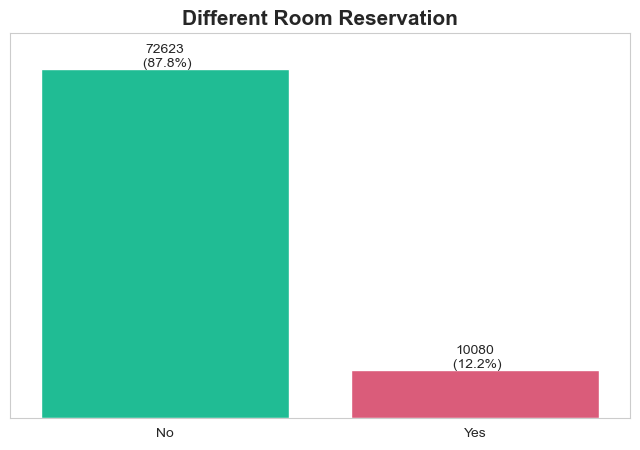

In [118]:
diff_room = df_train2.groupby('room_different').size().reset_index(name='count')
plt.figure(figsize=(8,5))
ax= sns.barplot(data= diff_room, x= 'room_different', y = 'count', palette=['#06d6a0','#ef476f'])
for p in ax.patches:
    percent = f'{round(p.get_height())}\n ({100 * p.get_height() / total:.1f}%)\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() +1000
    ax.annotate(percent, (x, y), ha='center', va='center')
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.ylim(ymax=80000)
plt.title(f'Different Room Reservation',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

**Observation**

Sebanyak 12.2% terjadi perbedaan kamar yang dipesan dengan yang ditempati maka perlu ditinjau apakah hal tersebut menyebabkan cancellation atau tidak

In [119]:
room_cancellation = df_train2.groupby(['reserved_room_type','room_different','is_canceled'])['is_canceled'].size().reset_index(name='count').sort_values(['reserved_room_type','count'], ascending = [True, False])

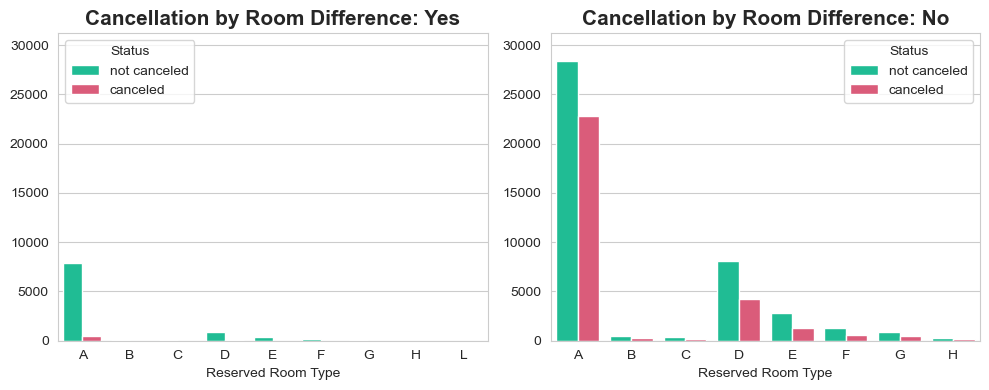

In [120]:
# Assuming room_cancellation is your DataFrame
plt.figure(figsize=(10, 4))
column = ['Yes','No']

max_count = room_cancellation['count'].max()  # Calculate the maximum count across both 'Yes' and 'No'

for i, col in enumerate(column, 1):
    plt.subplot(1, 2, i)
    feature = room_cancellation[room_cancellation['room_different'] == col]
    sns.barplot(data=feature, x='reserved_room_type', y='count', hue='is_canceled', palette=['#06d6a0','#ef476f'])
    plt.title(f'Cancellation by Room Difference: {col}', fontdict={'fontsize': 15, 'fontweight': 'bold'})
    plt.legend(title='Status')
    plt.xlabel('Reserved Room Type')
    plt.ylabel(None)
    plt.ylim(0, max_count * 1.1)  # Set the y-axis limit based on the calculated maximum count

plt.tight_layout()
plt.show()


In [121]:
not_canceled_data = df_train2[df_train2['is_canceled'] == 'canceled']
not_canceled_counts = not_canceled_data.groupby('reserved_room_type')['bookingID'].count().reset_index(name='Canceled')
canceled_counts = df_train2.groupby('reserved_room_type')['bookingID'].count().reset_index(name='Total Guests')

combined_data = pd.merge(not_canceled_counts, canceled_counts, on='reserved_room_type')
combined_data['Cancellation Percentage'] = round((combined_data['Total Guests'] - combined_data['Canceled']) / combined_data['Total Guests'] * 100,2)

sorted_data = combined_data.sort_values(by='Cancellation Percentage', ascending=False)
sorted_data

reserved_room_type  Canceled  Total Guests  Cancellation Percentage
4                  E      1351          4528                    70.16
5                  F       627          2039                    69.25
3                  D      4250         13241                    67.90
2                  C       211           649                    67.49
1                  B       254           774                    67.18
8                  L         1             3                    66.67
6                  G       529          1420                    62.75
7                  H       156           406                    61.58
0                  A     23354         59643                    60.84

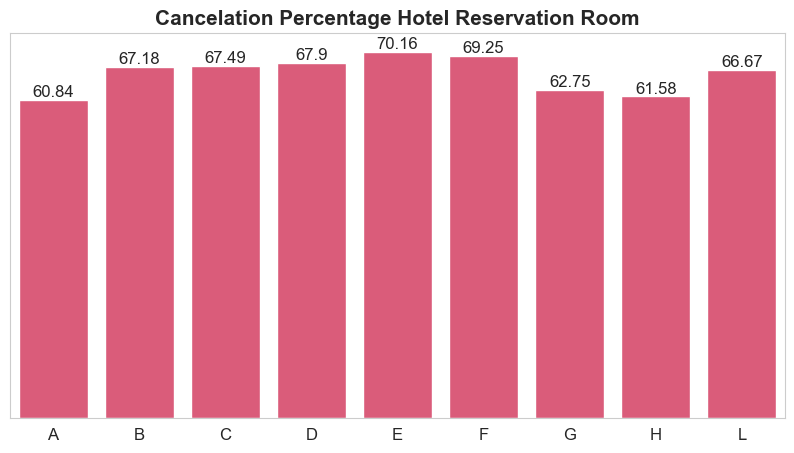

In [122]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = combined_data, x= 'reserved_room_type', y='Cancellation Percentage', palette=['#ef476f'])
ax.bar_label(ax.containers[0], fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title('Cancelation Percentage Hotel Reservation Room', fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

**Observation**
- Terjadi cancellation pada kamar yang berubah tetapi perbandingan sangat kecil sehingga dapat dikatakan cancellation tidak dipengaruhi dengan perubahan type kamar karena kamar yang tidak berubah justru lebih banyak terjadinya cancellation
- Walaupun jumlah cancel pada pesanan kamar A sangat tinggi tetapi berdasarkan persentase cancel justru yang tinggi adalah jenis kamar E sebesar 70.18% dan terendah kamar A sebesar 60.84%

#### Accomodation Details (Cancellation Based on Deposit Type)

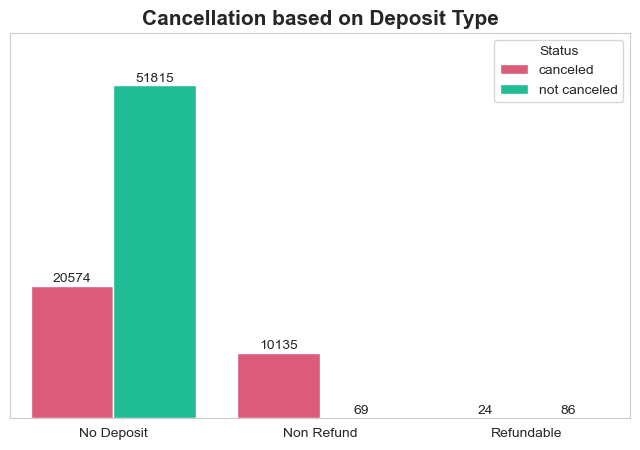

In [123]:
deposit_cancel = df_train2.groupby(['deposit_type','is_canceled'])['is_canceled'].size().reset_index(name='count')

plt.figure(figsize=(8,5))
ax= sns.barplot(data= deposit_cancel, x= 'deposit_type', y = 'count', hue='is_canceled', palette=['#ef476f','#06d6a0'])
for p in ax.patches:
    percent = f'{round(p.get_height())}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(percent, (x, y), ha='center', va='center')
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.ylim(ymax=60000)
plt.legend(title='Status')
plt.title(f'Cancellation based on Deposit Type',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

**Observation**

berdasarkan deposit type jumlah pesanan dan cancelation paling tinggi pada tipe No Deposit tetapi dibandingkan dengan tipe Non Refund persentase cancelation tertinggi justru terdapat pada tipe Non Refund dimana hampir 100% pesanan dibatalkan, hal ini merupakan wajar karena pemesan tidak ingin uangnya hangus karena pembatalan pesanan dan pasti memilih opsi lain. Untuk cancellation pada No Deposit bisa menjadi perhatian oleh pihak hotel untuk memberitahu mereka yang ingin memesan hotel untuk melakukan pembayaran uang muka (DP) terlebih dahulu sehingga dapat mengurangi kerugian dan para pemesan tidak akan merasa kecewa apabila pemesanannya dibatalkan secara sepihak.

#### Cancellation by Lead Time

In [124]:
def category_leadtime(lead_time):
    if lead_time ==0:
        return "Walk in Booking"
    elif lead_time <= 30:
        return "Advanced Booking"
    elif lead_time <= 180:
        return "Early Booking"
    elif lead_time >= 180:
        return "Very Early Booking"

In [125]:
df_train2['lead_time_category'] = df_train2['lead_time'].apply(category_leadtime)

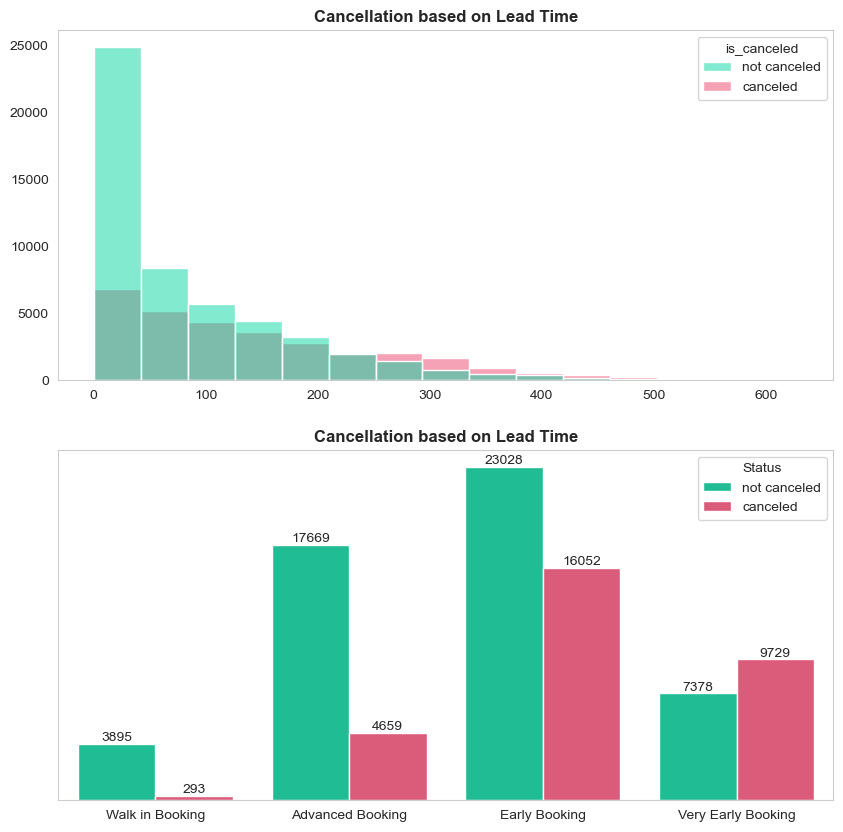

In [126]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.histplot(x=df_train2['lead_time'], hue=df_train2['is_canceled'], bins=15, ax=ax[0], palette=['#06d6a0','#ef476f'])
ax[0].set_title(f'Cancellation based on Lead Time',fontdict={'fontsize':12, 'fontweight':'bold'})
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].grid(None)

order_lead_time = ['Walk in Booking','Advanced Booking','Early Booking','Very Early Booking']
sns.countplot(x=df_train2['lead_time_category'], hue=df_train2['is_canceled'], order=order_lead_time, ax=ax[1], 
              palette=['#06d6a0','#ef476f'])
ax[1].legend(title='Status')
ax[1].set_title(f'Cancellation based on Lead Time',fontdict={'fontsize':12, 'fontweight':'bold'})
ax[1].bar_label(ax[1].containers[0])
ax[1].bar_label(ax[1].containers[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
plt.show()

In [127]:
# Separating the data into two groups based on cancellation status
not_canceled = df_train2[df_train2['is_canceled'] == 'not canceled']
canceled = df_train2[df_train2['is_canceled'] == 'canceled']

# Descriptive analysis for Not Canceled Reservations:
print("Descriptive for Not Canceled Reservations:")
print("Mean lead_time:", not_canceled['lead_time'].mean())
print("Median lead_time:", not_canceled['lead_time'].median())
print("Lead_time variance:", not_canceled['lead_time'].var())

# Descriptive analysis for Canceled Reservations:
print("\nDescriptive for Canceled Reservations:")
print("Mean lead_time:", canceled['lead_time'].mean())
print("Median lead_time:", canceled['lead_time'].median())
print("Lead_time variance:", canceled['lead_time'].var())

Descriptive for Not Canceled Reservations:
Mean lead_time: 80.61121801039062
Median lead_time: 46.0
Lead_time variance: 8370.003995842424

Descriptive for Canceled Reservations:
Mean lead_time: 144.54234861549475
Median lead_time: 113.0
Lead_time variance: 14021.878372161818


**Obsservation**

Jika kita lihat, semakin lama waktu tunggu, semakin tinggi jumlah pembatalan reservasi dibandingkan dengan yang tidak dibatalkan. Menawarkan harga khusus atau diskon bagi pelanggan yang memesan jauh-jauh hari dapat menjadi cara yang efektif untuk memberikan insentif bagi mereka untuk memesan lebih awal dan berpotensi mengurangi pembatalan. Menerapkan sistem penetapan harga berjenjang yang menawarkan harga lebih tinggi untuk pemesanan yang lebih dekat dengan waktu tunggu juga dapat membantu memastikan bahwa pelanggan yang memesan lebih dekat dengan tanggal perjalanan mereka mengetahui adanya biaya tambahan.

Mengirimkan pengingat kepada pelanggan tentang reservasi mereka juga dapat menjadi cara yang efektif untuk mengurangi pembatalan. Dengan mengingatkan pelanggan tentang reservasi mereka jauh sebelum tanggal perjalanan mereka, mereka lebih cenderung mengingat dan memprioritaskan rencana mereka, sehingga mengurangi kemungkinan pembatalan di menit-menit terakhir. Pengingat dapat dikirim melalui email, SMS, atau saluran komunikasi lainnya, tergantung pada preferensi dan informasi kontak pelanggan

Mengenai waktu reservasi maksimum, jika ada pembatalan untuk reservasi yang dilakukan lebih dari satu tahun sebelumnya, mungkin ada baiknya mempertimbangkan untuk mengubah kebijakan waktu reservasi maksimum. Hal ini dapat dilakukan dengan menetapkan waktu reservasi maksimum menjadi satu tahun dari tanggal saat ini untuk mengurangi kemungkinan pembatalan reservasi yang dilakukan terlalu jauh sebelumnya.

#### Cancellation by Required Parking Spaces dan Total Special Request

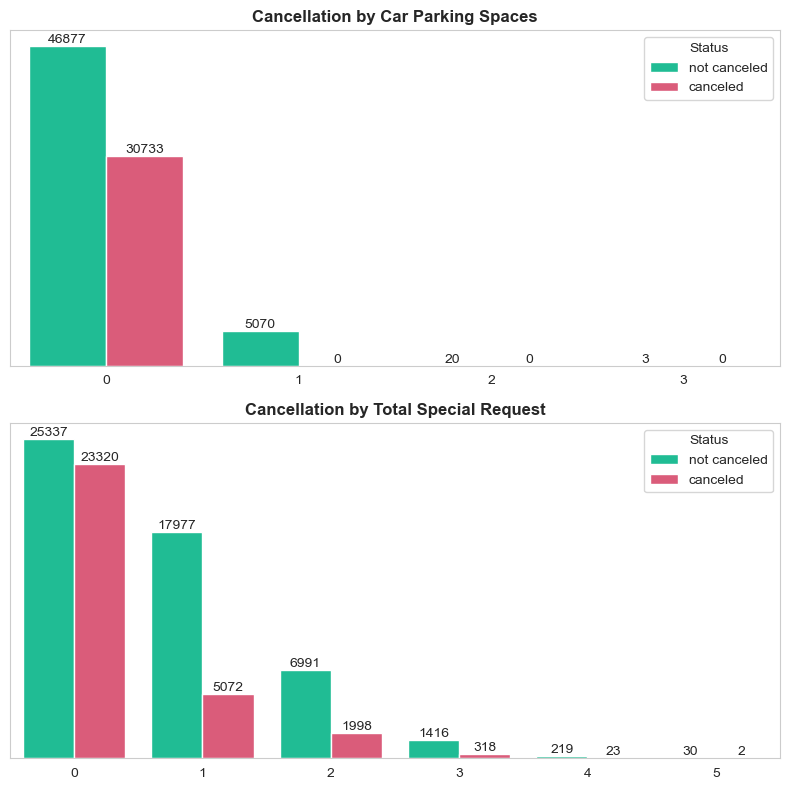

In [128]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
sns.countplot(x=df_train2['required_car_parking_spaces'], hue=df_train2['is_canceled'], ax=ax[0],palette=['#06d6a0','#ef476f'])
ax[0].legend(title='Status')
ax[0].set_title('Cancellation by Car Parking Spaces',fontdict={'fontsize':12, 'fontweight':'bold'})
ax[0].bar_label(ax[0].containers[0])
ax[0].bar_label(ax[0].containers[1])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_yticks([])

sns.countplot(x=df_train2['total_of_special_requests'], hue=df_train2['is_canceled'], ax=ax[1], palette=['#06d6a0','#ef476f'])
ax[1].legend(title='Status')
ax[1].set_title('Cancellation by Total Special Request',fontdict={'fontsize':12, 'fontweight':'bold'})
ax[1].bar_label(ax[1].containers[0])
ax[1].bar_label(ax[1].containers[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

**Observation**

- Bahwa pesanan hotel lebih banyak cancel pada customer yang tidak membawa kendaraan.
- Pembatalan pesanan hotel paling banyak terjadi ketika customer tidak meminta special request. Hal ini kemungkinan pelanggan yang sudah memesan hotel dan meminta special request sudah membayar lebih mahal pesanan hotel nya sehingga kemungkinan pembatalan sangat kecil

### Question 4 : Bagaimana status pemesanan terkait dengan kinerja hotel, khususnya dengan ADR (Average Daily Rate)?

In [129]:
adr_year = round(df_train2.groupby('arrival_date_year')['adr'].mean().reset_index(name='mean'),2)

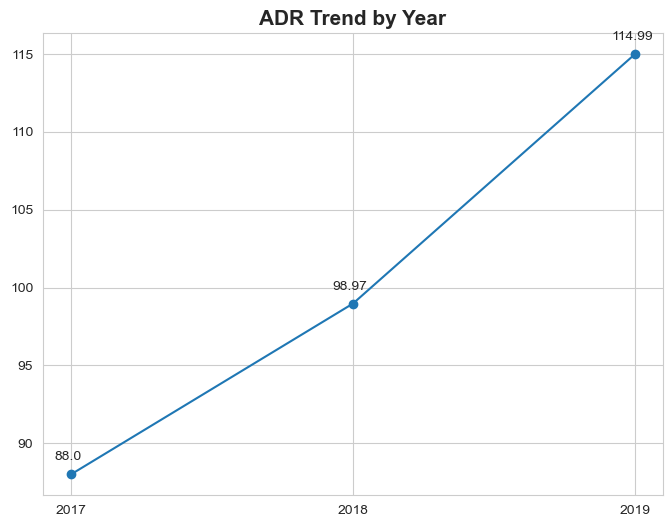

In [130]:
plt.figure(figsize=(8,6))
plt.plot(adr_year['arrival_date_year'], adr_year['mean'], marker='o')
plt.xticks([2017,2018,2019])
for i, count in enumerate(adr_year['mean']):
    plt.annotate(str(count), [adr_year['arrival_date_year'][i], count], textcoords="offset points", xytext=(-2, 10),
                  ha='center')
plt.title('ADR Trend by Year',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

In [131]:
df_train2['adr'].describe()

count    82703.000000
mean       102.424407
std         47.503033
min          0.000000
25%         70.000000
50%         95.000000
75%        126.000000
max        508.000000
Name: adr, dtype: float64

In [132]:
adr_monthly = df_train2[['adr','monthly_canceled']]
adr_monthly = round(adr_monthly.groupby('monthly_canceled')['adr'].mean().reset_index(name='mean_adr'),2)
adr_monthly['monthly_canceled'] = adr_monthly['monthly_canceled'].dt.strftime('%B %Y')
adr_monthly

monthly_canceled  mean_adr
0         July 2017    100.04
1       August 2017    106.54
2    September 2017     95.24
3      October 2017     79.89
4     November 2017     60.99
5     December 2017     74.91
6      January 2018     65.83
7     February 2018     71.00
8        March 2018     79.06
9        April 2018     89.24
10         May 2018     97.06
11        June 2018    107.49
12        July 2018    126.91
13      August 2018    143.45
14   September 2018    114.70
15     October 2018     95.60
16    November 2018     81.44
17    December 2018     88.17
18     January 2019     74.66
19    February 2019     77.02
20       March 2019     83.00
21       April 2019    110.94
22         May 2019    119.66
23        June 2019    126.44
24        July 2019    143.08
25      August 2019    164.55

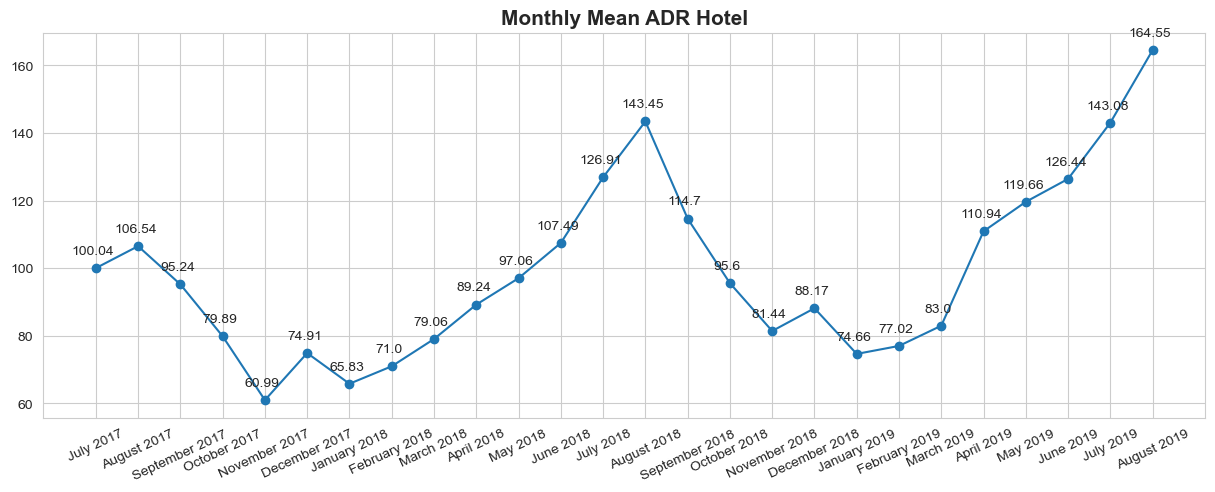

In [133]:
plt.figure(figsize=(15,5))
plt.plot(adr_monthly['monthly_canceled'], adr_monthly['mean_adr'], marker='o')

for i, count in enumerate(adr_monthly['mean_adr']):
    plt.annotate(str(count), [adr_monthly['monthly_canceled'][i], count], textcoords="offset points", xytext=(-2, 10),
                  ha='center')
plt.xticks(rotation=25)
plt.title('Monthly Mean ADR Hotel', fontdict={'fontsize':15,'fontweight':'bold'})
plt.show()

In [134]:
rates_per_night = df_train2[df_train2['is_canceled']=='not canceled'].groupby('reserved_room_type')['adr'].mean().reset_index(name='Mean Adr Pernight')
rates_per_night

reserved_room_type  Mean Adr Pernight
0                  A          90.235970
1                  B          86.852731
2                  C         153.833356
3                  D         117.581797
4                  E         119.666018
5                  F         160.910786
6                  G         170.009675
7                  H         184.123520
8                  L         175.000000

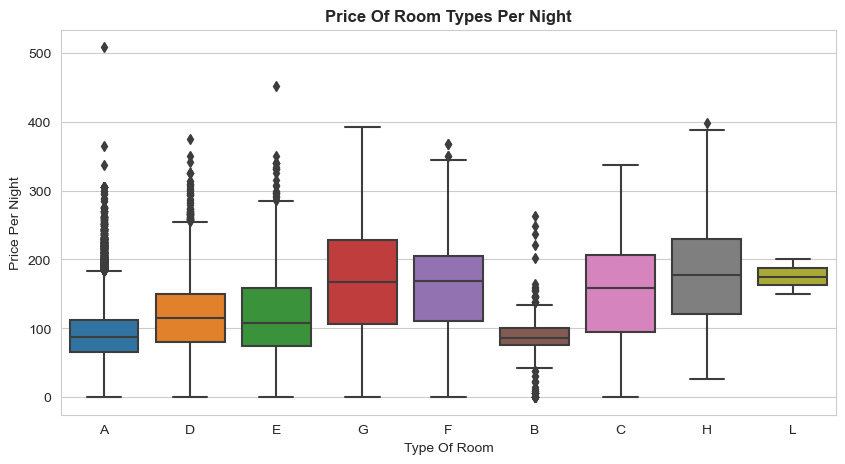

In [135]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_train2[df_train2['is_canceled'] == 'not canceled'],x='reserved_room_type',y='adr')
plt.title('Price Of Room Types Per Night',fontdict={'fontsize':12, 'fontweight':'bold'})
plt.xlabel('Type Of Room')
plt.ylabel('Price Per Night')
plt.show()

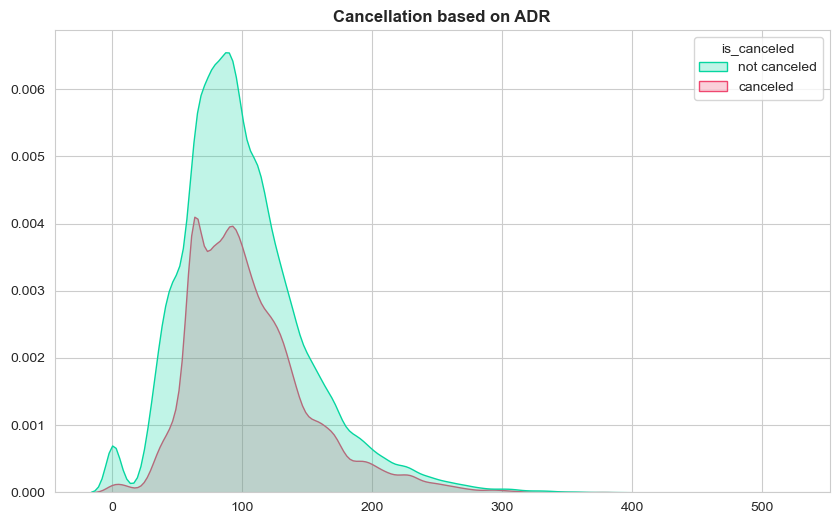

In [136]:
plt.figure(figsize=(10,6))
sns.kdeplot(x=df_train2['adr'],shade=True, hue=df_train2['is_canceled'], palette=['#06d6a0','#ef476f'] )
plt.title(f'Cancellation based on ADR',fontdict={'fontsize':12, 'fontweight':'bold'})
plt.xlabel(None)
plt.ylabel(None)
plt.show()

**Observation**

- Setiap tahunnya harga ADR hotel meningkat
- Berdasarkan monthly mean adr terlihat bahwa adr paling tinggi terjadi setiap bulan agustus. Disarankan agar pihak hotel dapat meningkatkan harga sewa kamar rata-rata pada saat puncak pesanan hotel dan menerapkan kebijakan pembatalan selama sepi pemesanan dengan hanya pengembalian dana sebagian untuk meminimalkan kerugian ketika pelanggan membatalkan reservasi mereka. Namun, selama pemesanan ramai, pembatalan reservasi tidak dikenakan biaya karena tingginya permintaan, dan jika ada pembatalan, mereka dapat dengan cepat digantikan oleh pelanggan lain.
- Rata-rata harga kamar bervariasi untuk harga kamar terendah yaitu pada kamar tipe A dan B sedangkan tertinggi kamar tipe G, H, L 
- Pelanggan yang tidak mengeluarkan uang untuk biaya kamar cenderung lebih sedikit melakukan pembatalan pesanan, dan puncak pembatalan pesanan yaitu pada pelanggan yang mengeluarkan uang antara 70-100 euro untuk biaya kamar.


# Data Preprocessing

In [456]:
df_train_model = df_train_clean.copy()

## Feature Engineering

**Drop Data Distribution Channel and Market Segment Undefined**

In [457]:
filter_data = (df_train_model['distribution_channel'] == 'Undefined') | (df_train_model['market_segment'] =='Undefined')
df_train_model = df_train_model[~filter_data]

Dilakukan drop karena jumlah data undefined hanya sedikit dan kemungkinan memang salah input atau outlier

In [458]:
df_train_model.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'bookingID'],
      dtype='object')

**add new column offspring & room_change**

In [459]:
df_train_model['kids'] = df_train_model['children'] + df_train_model['babies']
df_train_model['room_change'] = np.where(df_train_model['reserved_room_type'] == df_train_model['assigned_room_type'], 0,1)

In [460]:
df_train_model[['reserved_room_type','assigned_room_type','room_change']].tail(5)

reserved_room_type assigned_room_type  room_change
83288                  A                  A            0
83289                  A                  A            0
83290                  E                  E            0
83291                  A                  D            1
83292                  A                  A            0

**add new column total_stays**

In [461]:
df_train_model['total_stays'] = df_train_model['stays_in_week_nights'] + df_train_model['stays_in_weekend_nights']

**Observation**

Dilakukan untuk mengurangi kompleksitas model dalam training serta fitur tersebut bisa digabungkan sehingga mengurangi jumlah fitur yang ditrain

**add new colum total_guest**

In [462]:
df_train_model['total_guest'] = df_train_model['adults'] + df_train_model['kids']

## Encoding

**Ordinal Encoding arrival_date_month**

In [463]:
#encode arrival_date_month

month = {'January':0, 
       'February':1,
       'March':2,
       'April':3,
       'May':4,
       'June':5,
       'July':6,
       'August':7,
       'September':8,
       'October':9,
       'November':10,
       'December':11}

df_train_model['arrival_date_month'] = df_train_model['arrival_date_month'].map(month)

**Observation**

Dilakukan karena Ordinal Encoding pada `arrival_date_month` karena bulan memang berurut

**Frequency Encoding hotel, country, meal, market_segment, distribution_channel, deposit_type, customer_type**

In [464]:
# #encoding meal
freq_meal = df_train_model['meal'].value_counts().reset_index()
freq_meal.rename(columns= {'index':'meal', 'meal':'freq_meal'}, inplace=True)
freq_meal['pct_meal'] = round(freq_meal['freq_meal'] / freq_meal['freq_meal'].sum() *100,2)

# #encoding market_segment
freq_market_segment = df_train_model['market_segment'].value_counts().reset_index()
freq_market_segment.rename(columns= {'index':'market_segment', 'market_segment':'freq_market_segment'}, inplace=True)
freq_market_segment['pct_market_segment'] = round(freq_market_segment['freq_market_segment'] / freq_market_segment['freq_market_segment'].sum() *100,2)

# #encoding distribution_channel
freq_distribution_channel = df_train_model['distribution_channel'].value_counts().reset_index()
freq_distribution_channel.rename(columns= {'index':'distribution_channel', 'distribution_channel':'freq_distribution_channel'}, inplace=True)
freq_distribution_channel['pct_distribution_channel'] = round(freq_distribution_channel['freq_distribution_channel'] / freq_distribution_channel['freq_distribution_channel'].sum() *100,2)

# #encoding deposit_type
freq_deposit_type = df_train_model['deposit_type'].value_counts().reset_index()
freq_deposit_type.rename(columns= {'index':'deposit_type', 'deposit_type':'freq_deposit_type'}, inplace=True)
freq_deposit_type['pct_deposit_type'] = round(freq_deposit_type['freq_deposit_type'] / freq_deposit_type['freq_deposit_type'].sum() *100,2)

# #encoding customer_type
freq_customer_type = df_train_model['customer_type'].value_counts().reset_index()
freq_customer_type.rename(columns= {'index':'customer_type', 'customer_type':'freq_customer_type'}, inplace=True)
freq_customer_type['pct_customer_type'] = round(freq_customer_type['freq_customer_type'] / freq_customer_type['freq_customer_type'].sum() *100,2)

df_train_model = df_train_model.merge(freq_meal[['meal','pct_meal']], on='meal', how='inner')
df_train_model = df_train_model.merge(freq_market_segment[['market_segment','pct_market_segment']], on='market_segment', how='inner')
df_train_model = df_train_model.merge(freq_distribution_channel[['distribution_channel','pct_distribution_channel']], on='distribution_channel', how='inner')
df_train_model = df_train_model.merge(freq_deposit_type[['deposit_type','pct_deposit_type']], on='deposit_type', how='inner')
df_train_model = df_train_model.merge(freq_customer_type[['customer_type','pct_customer_type']], on='customer_type', how='inner')

In [465]:
df_train_model.drop(['meal','market_segment', 'distribution_channel', 'deposit_type', 'customer_type'], axis=1, inplace=True)
df_train_model.rename(columns={
                               'pct_meal':'meal',
                               'pct_market_segment':'market_segment',
                               'pct_distribution_channel':'distribution_channel',
                               'pct_deposit_type':'deposit_type',
                               'pct_customer_type':'customer_type'}, inplace=True)
df_train_model.head(3)

hotel  is_canceled  lead_time  \
0         Crystal Cove, Barbados Barbados            0          8   
1  W New York – Times Square New York, NY            0        205   
2    The Ritz-Carlton, Tokyo Tokyo, Japan            0         52   

   arrival_date_year  arrival_date_month  arrival_date_week_number  \
0               2019                   0                         2   
1               2019                   5                        24   
2               2018                   6                        29   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                         10                        0                     4   
1                         13                        0                     4   
2                         12                        0                     2   

   adults  ...  bookingID  kids room_change  total_stays  total_guest   meal  \
0       2  ...          1     0           0            4            2  77.38   
1       2  ...          7     0           0            4            2  77.38   
2       3  ...          8     0           1            2            3  77.38   

  market_segment distribution_channel  deposit_type customer_type  
0           47.4                82.22         87.53         75.05  
1           47.4                82.22         87.53         75.05  
2           47.4                82.22         87.53         75.05  

[3 rows x 36 columns]

**Observation**

Dilakukan Frequency Encoding untuk menghindari terjadinya multicolinearitas apabila menggunakan One Hot Encoding serta menghindari terjadinya curse of dimensionality dikarenakan fitur yang di encode oleh one hot encoding akan membuat fitur baru sesuai jumlah category

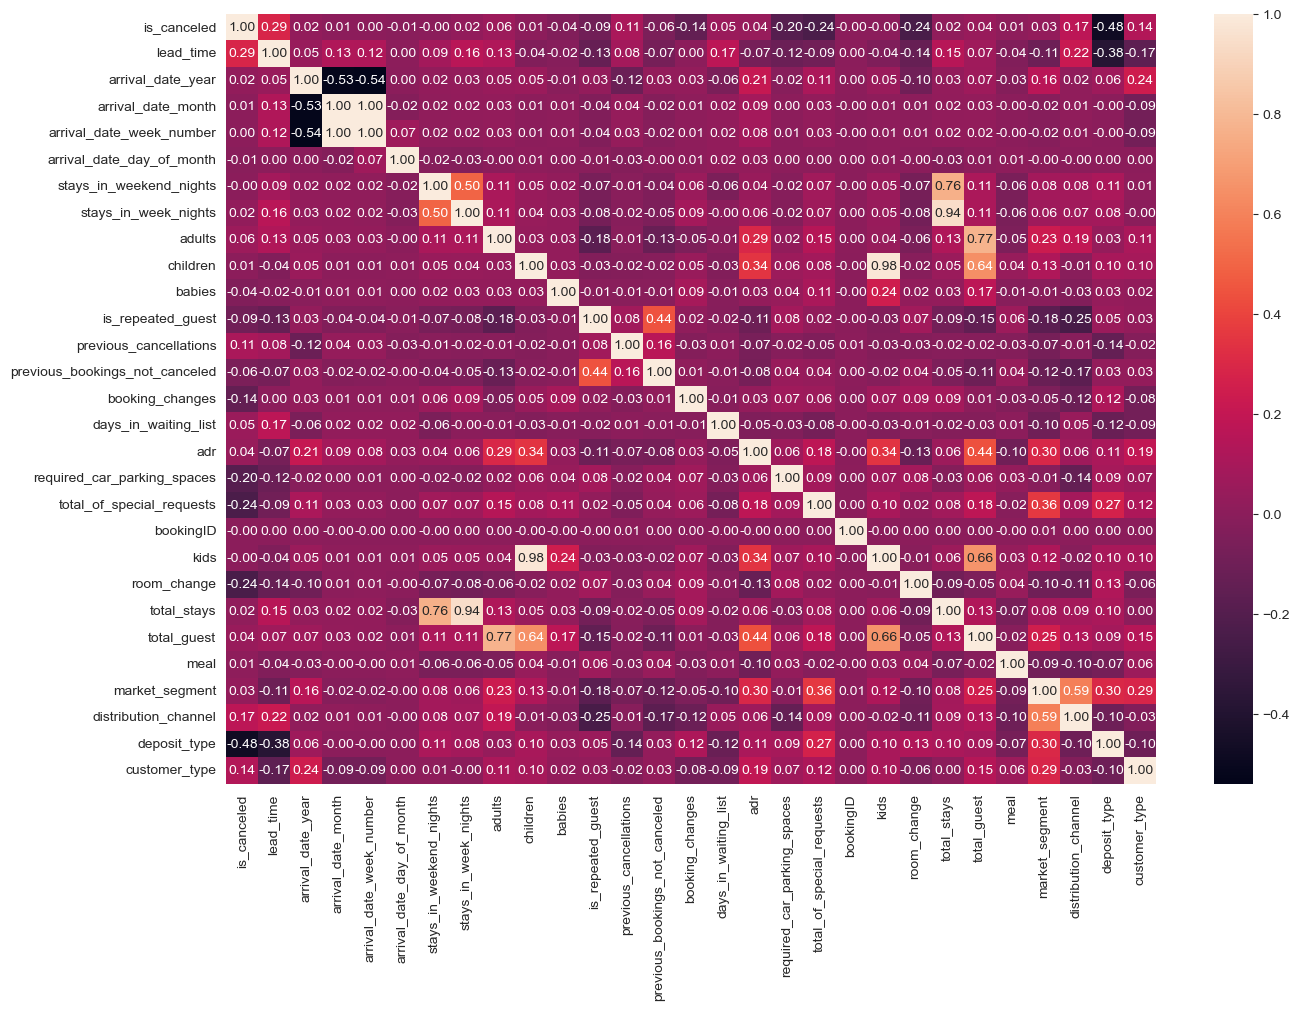

In [466]:
correlation = df_train_model.corr()

plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.show()

In [467]:
df_train_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82699 entries, 0 to 82698
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           82699 non-null  object        
 1   is_canceled                     82699 non-null  int64         
 2   lead_time                       82699 non-null  int64         
 3   arrival_date_year               82699 non-null  int64         
 4   arrival_date_month              82699 non-null  int64         
 5   arrival_date_week_number        82699 non-null  int64         
 6   arrival_date_day_of_month       82699 non-null  int64         
 7   stays_in_weekend_nights         82699 non-null  int64         
 8   stays_in_week_nights            82699 non-null  int64         
 9   adults                          82699 non-null  int64         
 10  children                        82699 non-null  int64         
 11  ba

**Observation**

Setelah dilakukan encoding jumlah fitur menjadi 36 kolom

## Drop not useful Feature

In [468]:
df_train_model.drop(['bookingID','reservation_status','reservation_status_date',
                     'arrival_date_year','assigned_room_type','reserved_room_type','babies','children',
                     'hotel','country','agent','days_in_waiting_list','stays_in_weekend_nights','stays_in_week_nights'],axis=1, inplace=True)

**Observation**

- Drop `bookingID` karena fitur tersebut memiliki unique value yang banyak dan tidak ada korelasi dengan terjadinya pembatalan pesanan hotel
- Drop `reservation_status` karena fitur tersebut merupakan duplikasi dari target (No-Show dan Canceled :1, Check-Out:0)
- Drop `reservation_status_date` karena fitur reservation_status_date berasosiasi dengan reservation_status dan reservation_status_date merupakan tanggal terakhir reservation_status diupdate. Dengan demikian, apabila reservation_status adalah check-out, tanggal dari reservation_status_date akan lebih besar daripada arrival_date, sedangkan apabila reservation_status adalah no show, tanggal dari reservation_status_date = tanggal dari arrival_date, dan apabila status cancel, maka tanggal dari reservation_status_date akan lebih kecil dari arrival_date.
- Drop `arrival_date_year` karena ingin membuat model yang dapat memprediksi kejadian cancelation di masa akan datang. Selain itu, apa yang telah terjadi sebelumnya belum tentu terjadi lagi
- Drop `assigned_room_type, reserved_room_type` karena sebelumnya sudah digabungkan pada fitur baru `room_change`
- Drop `babies, children` karena sebelumnya sudah digabungkan pada fitur baru `offspring`
- Drop `hotel, country, agent` untuk generalisasi model agar dapat digunakan untuk semua hotel, maka kolom ini dibuang
- Drop `days_in_waiting_list` karena pesanan yang masuk ke waiting list belum dianggap sebagai pesanan yang memotong jumlah kamar hotel, sehingga apabila cancel pun tidak akan mempengaruhi jumlah kamar hotel. Hal ini didukung dengan melihat pada nilai korelasi antara days_in_waiting list dengan target variable yang = 0
- Drop `stays_in_weekend_nights, stays_in_week_nights` karena sebelumnya sudah digabungkan pada fitur baru `total_stays`

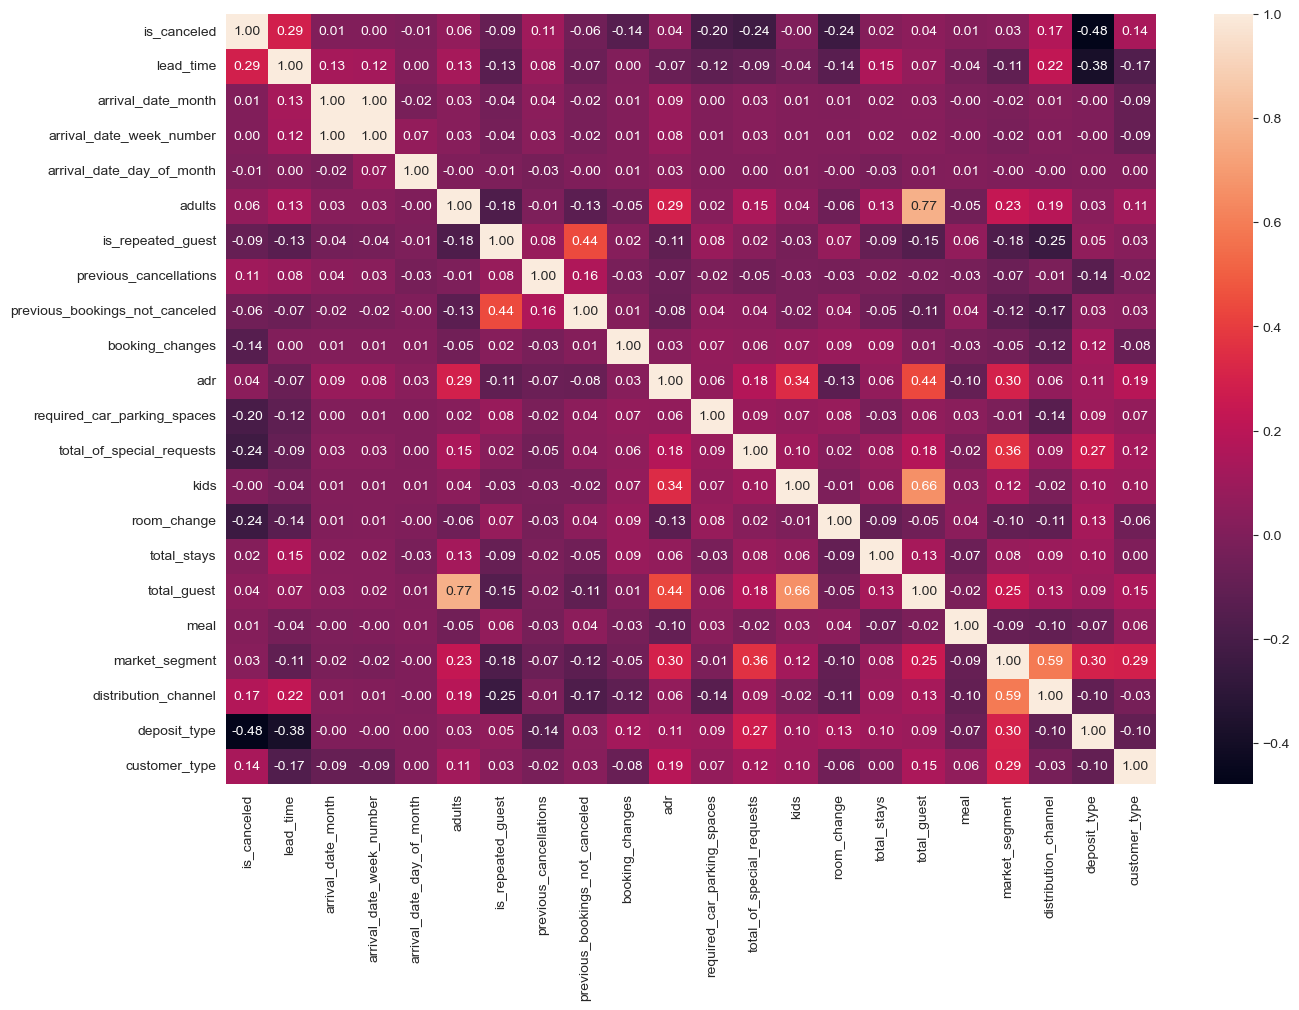

In [469]:
correlation = df_train_model.corr()

plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.show()

In [470]:
df_train_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82699 entries, 0 to 82698
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     82699 non-null  int64  
 1   lead_time                       82699 non-null  int64  
 2   arrival_date_month              82699 non-null  int64  
 3   arrival_date_week_number        82699 non-null  int64  
 4   arrival_date_day_of_month       82699 non-null  int64  
 5   adults                          82699 non-null  int64  
 6   is_repeated_guest               82699 non-null  int64  
 7   previous_cancellations          82699 non-null  int64  
 8   previous_bookings_not_canceled  82699 non-null  int64  
 9   booking_changes                 82699 non-null  int64  
 10  adr                             82699 non-null  float64
 11  required_car_parking_spaces     82699 non-null  int64  
 12  total_of_special_requests       

# Scoring Metrics

In [471]:
df_train_model['is_canceled'].value_counts()

0    51969
1    30730
Name: is_canceled, dtype: int64

In [593]:
fitur = df_train_model['is_canceled'].value_counts()
sns.barplot(x= fitur.index, y= fitur.values, palette=color, ax=ax[1])
ax[1].set_title('Number of Canceled Status', fontdict = {'fontsize':20, 'fontweight':'bold'})
ax[1].set_xticklabels(['not canceled','canceled'])
ax[1].bar_label(ax[1].containers[0], fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

**Observation**

0 : not canceled
1 : canceled

Karena data antara canceled dan tidak canceled imbalance maka untuk scoring metric yang digunakan yaitu F1 Score karena apabila menggunakan accuracy hasil prediksi yang dihasilkan tidak reliable karena cenderung memilih data mayoritas. Selain F1 Score scoring metric yang digunakan juga akan menggunakan recall karena lebih baik memilih untuk salah saat mengklasifikasikan customer yang tidak melakukan canceled daripada mengklasifikasikan customer yang melakukan canceled karena dampaknya akan berpengaruh pada pendapatan perusahaan.

# Modelling

## Split Fitur dan Target

In [472]:
fitur = df_train_model.drop('is_canceled', axis=1)
target = df_train_model['is_canceled']

In [473]:
fitur

lead_time  arrival_date_month  arrival_date_week_number  \
0              8                   0                         2   
1            205                   5                        24   
2             52                   6                        29   
3             18                   6                        30   
4            122                   7                        33   
...          ...                 ...                       ...   
82694          9                   4                        21   
82695          9                   4                        21   
82696          9                   4                        21   
82697          0                   4                        21   
82698          0                   4                        21   

       arrival_date_day_of_month  adults  is_repeated_guest  \
0                             10       2                  0   
1                             13       2                  0   
2                             12       3                  0   
3                             27       2                  0   
4                             14       3                  0   
...                          ...     ...                ...   
82694                         15       2                  0   
82695                         15       2                  0   
82696                         15       2                  0   
82697                         15       2                  1   
82698                         15       2                  1   

       previous_cancellations  previous_bookings_not_canceled  \
0                           0                               0   
1                           0                               0   
2                           0                               0   
3                           0                               0   
4                           0                               0   
...                       ...                             ...   
82694                       0                               0   
82695                       0                               0   
82696                       0                               0   
82697                       0                               0   
82698                       0                               0   

       booking_changes     adr  ...  total_of_special_requests  kids  \
0                    0   38.40  ...                          0     0   
1                    0  150.75  ...                          2     0   
2                    1  137.70  ...                          1     0   
3                    0  169.00  ...                          1     0   
4                    0  195.00  ...                          0     0   
...                ...     ...  ...                        ...   ...   
82694                0   76.00  ...                          0     0   
82695                0   70.00  ...                          0     0   
82696                0   70.00  ...                          0     0   
82697                0   70.00  ...                          0     0   
82698                0   70.00  ...                          0     0   

       room_change  total_stays  total_guest   meal  market_segment  \
0                0            4            2  77.38           47.40   
1                0            4            2  77.38           47.40   
2                1            2            3  77.38           47.40   
3                0            3            2  77.38           47.40   
4                0            3            3  77.38           47.40   
...            ...          ...          ...    ...             ...   
82694            0            1            2  77.38           16.63   
82695            0            1            2  77.38           16.63   
82696            0            1            2  77.38           16.63   
82697            1            1            2  77.38           10.42   
82698            1            

In [474]:
target

0        0
1        0
2        0
3        0
4        1
        ..
82694    0
82695    0
82696    0
82697    0
82698    0
Name: is_canceled, Length: 82699, dtype: int64

## Scaling Fitur

In [475]:
fitur_std = fitur.copy()
column = fitur_std.columns

scaler = RobustScaler()
fitur_std[column] = scaler.fit_transform(fitur_std[column])
fitur_std

lead_time  arrival_date_month  arrival_date_week_number  \
0      -0.426573                -1.2                 -1.136364   
1       0.951049                -0.2                 -0.136364   
2      -0.118881                 0.0                  0.090909   
3      -0.356643                 0.0                  0.136364   
4       0.370629                 0.2                  0.272727   
...          ...                 ...                       ...   
82694  -0.419580                -0.4                 -0.272727   
82695  -0.419580                -0.4                 -0.272727   
82696  -0.419580                -0.4                 -0.272727   
82697  -0.482517                -0.4                 -0.272727   
82698  -0.482517                -0.4                 -0.272727   

       arrival_date_day_of_month  adults  is_repeated_guest  \
0                      -0.400000     0.0                0.0   
1                      -0.200000     0.0                0.0   
2                      -0.266667     1.0                0.0   
3                       0.733333     0.0                0.0   
4                      -0.133333     1.0                0.0   
...                          ...     ...                ...   
82694                  -0.066667     0.0                0.0   
82695                  -0.066667     0.0                0.0   
82696                  -0.066667     0.0                0.0   
82697                  -0.066667     0.0                1.0   
82698                  -0.066667     0.0                1.0   

       previous_cancellations  previous_bookings_not_canceled  \
0                         0.0                             0.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         0.0                             0.0   
4                         0.0                             0.0   
...                       ...                             ...   
82694                     0.0                             0.0   
82695                     0.0                             0.0   
82696                     0.0                             0.0   
82697                     0.0                             0.0   
82698                     0.0                             0.0   

       booking_changes       adr  ...  total_of_special_requests  kids  \
0                  0.0 -1.010714  ...                        0.0   0.0   
1                  0.0  0.995536  ...                        2.0   0.0   
2                  1.0  0.762500  ...                        1.0   0.0   
3                  0.0  1.321429  ...                        1.0   0.0   
4                  0.0  1.785714  ...                        0.0   0.0   
...                ...       ...  ...                        ...   ...   
82694              0.0 -0.339286  ...                        0.0   0.0   
82695              0.0 -0.446429  ...                        0.0   0.0   
82696              0.0 -0.446429  ...                        0.0   0.0   
82697              0.0 -0.446429  ...                        0.0   0.0   
82698              0.0 -0.446429  ...                        0.0   0.0   

       room_change  total_stays  total_guest  meal  market_segment  \
0              0.0          0.5          0.0   0.0        0.880403   
1              0.0          0.5          0.0   0.0        0.880403   
2              1.0         -0.5          1.0   0.0        0.880403   
3              0.0          0.0          0.0   0.0        0.880403   
4              0.0          0.0          1.0   0.0        0.880403   
...            ...          ...          ...   ...             ...   
82694          0.0         -1.0          0.0   0.0       -0.119597   
82695          0.0         -1.0          0.0   0.0       -0.119597   
82696          0.0         -1.0          0.0   0.0       -0.119597   
82697          1.0         -1.0          0.0   0.0       -0.321417   
82698          1.

**Observation**

Scaler yang digunakan adalah Robust Scaler karena terlihat data kebanyakan memiliki outlier sehingga, scaler ini digunakan dengan harapan mendapatkan hasil performa yang baik

## Multicolinearity Checking

In [476]:
#menghitung VIF Score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = fitur_std
X_vif = add_constant(X)
vif_df = pd.DataFrame([vif(X_vif.values, i)
                      for i in range(X_vif.shape[1])],
                     index=X_vif.columns).reset_index()
vif_df.columns = ["feature","vif_score"]
vif_df = vif_df.loc[vif_df.feature!="const"]
vif_df

feature   vif_score
1                        lead_time    1.449343
2               arrival_date_month  918.589140
3         arrival_date_week_number  919.969760
4        arrival_date_day_of_month    8.963352
5                           adults         inf
6                is_repeated_guest    1.334945
7           previous_cancellations    1.062862
8   previous_bookings_not_canceled    1.287067
9                  booking_changes    1.060733
10                             adr    1.447710
11     required_car_parking_spaces    1.053439
12       total_of_special_requests    1.244177
13                            kids         inf
14                     room_change    1.085408
15                     total_stays    1.098757
16                     total_guest         inf
17                            meal    1.044034
18                  market_segment    2.816529
19            distribution_channel    2.211395
20                    deposit_type    1.717157
21                   customer_type    1.386815

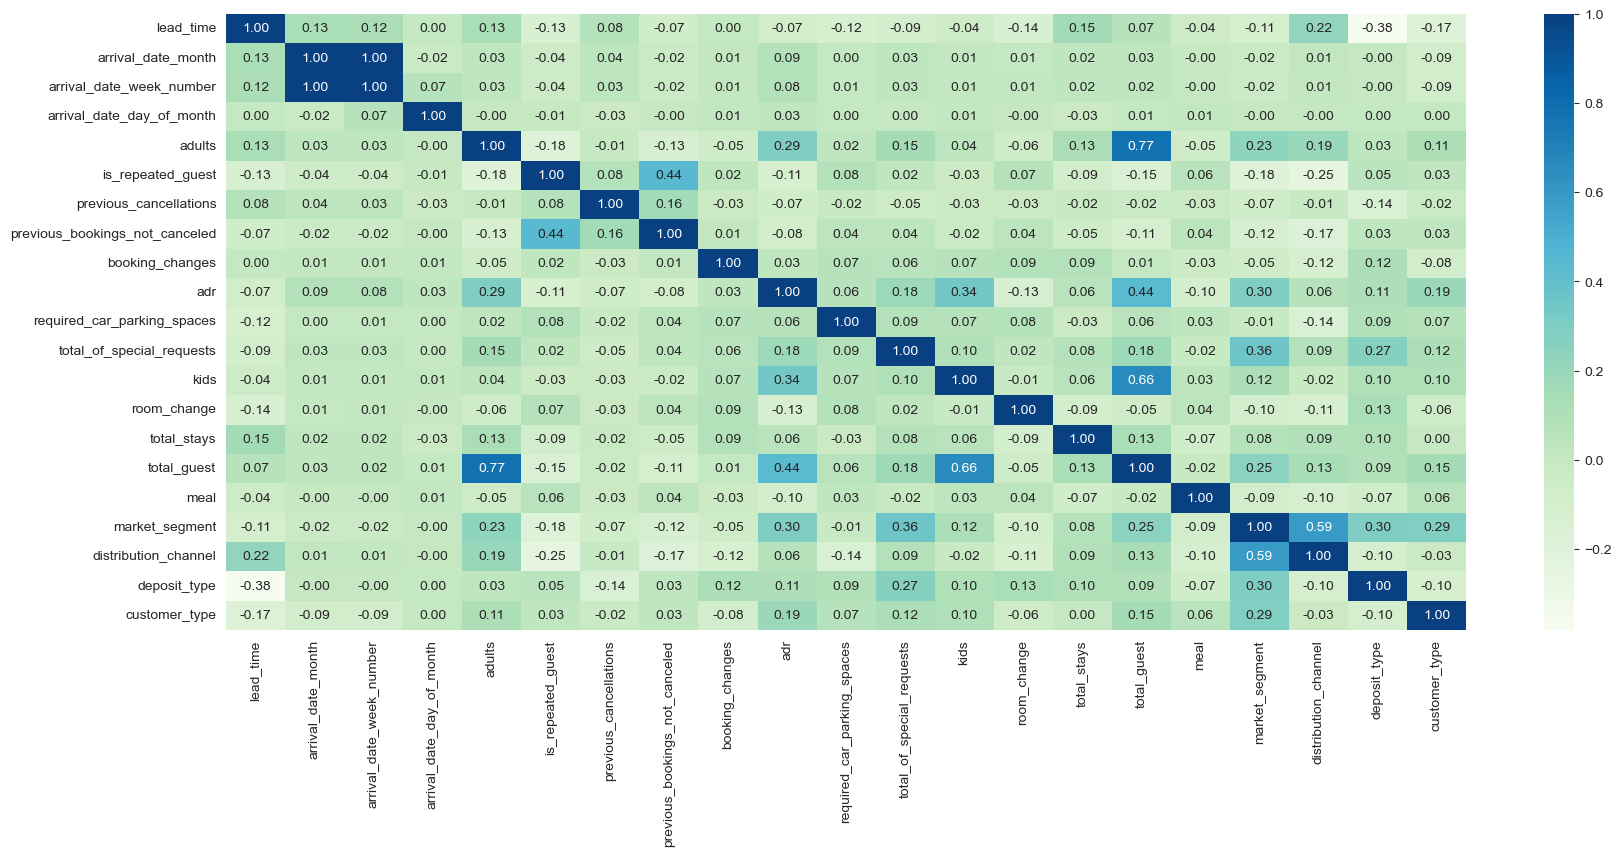

In [477]:
plt.figure(figsize=(20,8))

sns.heatmap(fitur_std.corr(), fmt='.2f',annot=True, cmap= 'GnBu')
plt.show()

**Observation**

Setelah dilakukan multicolinearity checking terdapat korelasi yang kuat antara `arrival_date_month` dan `arrival_date_week_number` sebesar 1 artinya informasi yang dimiliki kedua fitur tersebut sama atau redundan dan setelah dicek korelasi dengan target fitur `arrival_date_month` memiliki korelasi yang lebih kuat dibandingkan `arrival_date_week_number` oleh karena itu fitur `arrival_date_week_number` akan di drop

**Drop fitur arrival_date_week_number**

In [478]:
fitur_std.drop('arrival_date_week_number', axis=1, inplace=True)

**Rechecking Multicolinearity**

In [479]:
X = fitur_std
X_vif = add_constant(X)
vif_df = pd.DataFrame([vif(X_vif.values, i)
                      for i in range(X_vif.shape[1])],
                     index=X_vif.columns).reset_index()
vif_df.columns = ["feature","vif_score"]
vif_df = vif_df.loc[vif_df.feature!="const"]
vif_df

feature  vif_score
1                        lead_time   1.417292
2               arrival_date_month   1.042632
3        arrival_date_day_of_month   1.003941
4                           adults        inf
5                is_repeated_guest   1.334890
6           previous_cancellations   1.062583
7   previous_bookings_not_canceled   1.287066
8                  booking_changes   1.060721
9                              adr   1.402605
10     required_car_parking_spaces   1.052769
11       total_of_special_requests   1.241950
12                            kids        inf
13                     room_change   1.084737
14                     total_stays   1.096511
15                     total_guest        inf
16                            meal   1.043595
17                  market_segment   2.815642
18            distribution_channel   2.211352
19                    deposit_type   1.714710
20                   customer_type   1.386771

sudah tidak terdapat fitur yang berkorelasi tinggi

## Model Train

In [480]:
X = fitur_std.to_numpy()
y = target.to_numpy()
y = y.reshape(len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [481]:
models = [LogisticRegression(random_state=42),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42)]

list_all_f1 = []
list_all_recall = []
list_mean_f1 = []
list_mean_recall = []

f1_scores = make_scorer(f1_score)
recall_scores = make_scorer(recall_score)

for i, model in enumerate(models):
    y_pred = cross_val_predict(estimator=model, X = X_train, y = y_train, cv=5)
    cv_score_f1 = cross_val_score(estimator=model, X = X_train, y = y_train, cv=5, scoring=f1_scores)
    cv_score_recall = cross_val_score(estimator=model, X = X_train, y = y_train, cv=5, scoring=recall_scores)
    
    list_all_f1.append(cv_score_f1.round(2))
    list_mean_f1.append(cv_score_f1.mean())
    
    list_all_recall.append(cv_score_recall.round(2))
    list_mean_recall.append(cv_score_recall.mean())
    
    print(f"Model {i + 1} ({type(model).__name__}):")
    for fold, (f1, recall) in enumerate(zip(cv_score_f1, cv_score_recall), start=1):
        print(f"  Fold {fold}: F1={f1}, Recall={recall} \n")
        
    # Classification report
    report = classification_report(y_train, y_pred, target_names=['Class 0', 'Class 1'])
    print(f"\nClassification Report:\n{report}\n{'='*40}\n")

hasil_train = pd.DataFrame({
    'model': models,
    'f1_score_mean': list_mean_f1,
    'f1_score_all': list_all_f1,
    'recall_mean': list_mean_recall,
    'recall_all': list_all_recall
})

Model 1 (LogisticRegression):
  Fold 1: F1=0.7134610944354652, Recall=0.6281764586298028 

  Fold 2: F1=0.7128370592302374, Recall=0.628786338686725 

  Fold 3: F1=0.6984387838948233, Recall=0.6047977231144541 

  Fold 4: F1=0.7012655288517358, Recall=0.6139459239682863 

  Fold 5: F1=0.7024947540219165, Recall=0.6125228705021346 


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.92      0.86     41564
     Class 1       0.82      0.62      0.71     24595

    accuracy                           0.81     66159
   macro avg       0.81      0.77      0.78     66159
weighted avg       0.81      0.81      0.80     66159


Model 2 (KNeighborsClassifier):
  Fold 1: F1=0.7417344459702123, Recall=0.7137629599512096 

  Fold 2: F1=0.732566885140217, Recall=0.6930270380158569 

  Fold 3: F1=0.7291822955738935, Recall=0.6916039845497052 

  Fold 4: F1=0.7339859544583954, Recall=0.701158772108152 

  Fold 5: F1=0.7328, Recall=0.6983126651

[LightGBM] [Info] Number of positive: 19676, number of negative: 33251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 52927, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371757 -> initscore=-0.524685
[LightGBM] [Info] Start training from score -0.524685
[LightGBM] [Info] Number of positive: 19676, number of negative: 33251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 52927, number of used features: 20
[LightGBM] [Info] [b

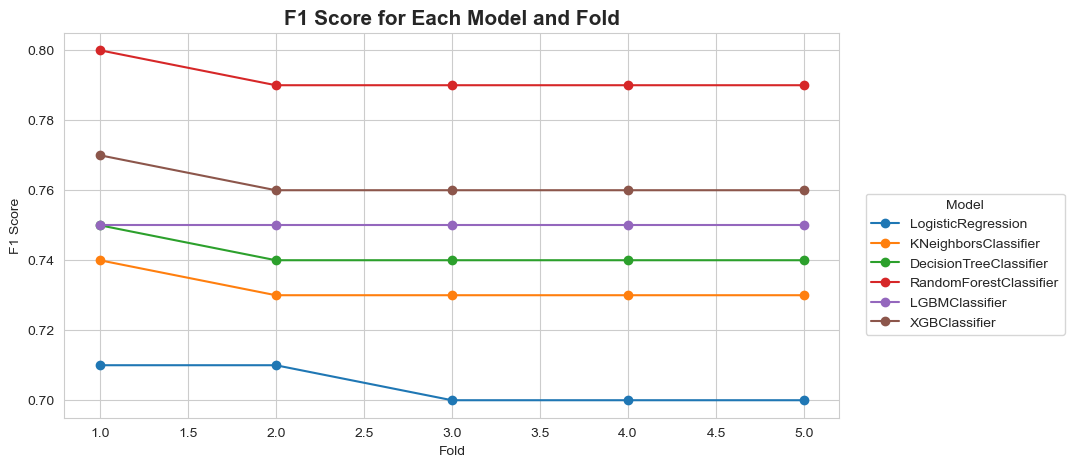

In [482]:
# Line plot for F1 scores
plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.plot(range(1, 6), hasil_train['f1_score_all'][i], marker='o', label=f"{type(model).__name__}")

plt.title('F1 Score for Each Model and Fold', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend(title = 'Model',loc = 'best',bbox_to_anchor=(0.8, 0, 0.5, 0.6))
plt.show()

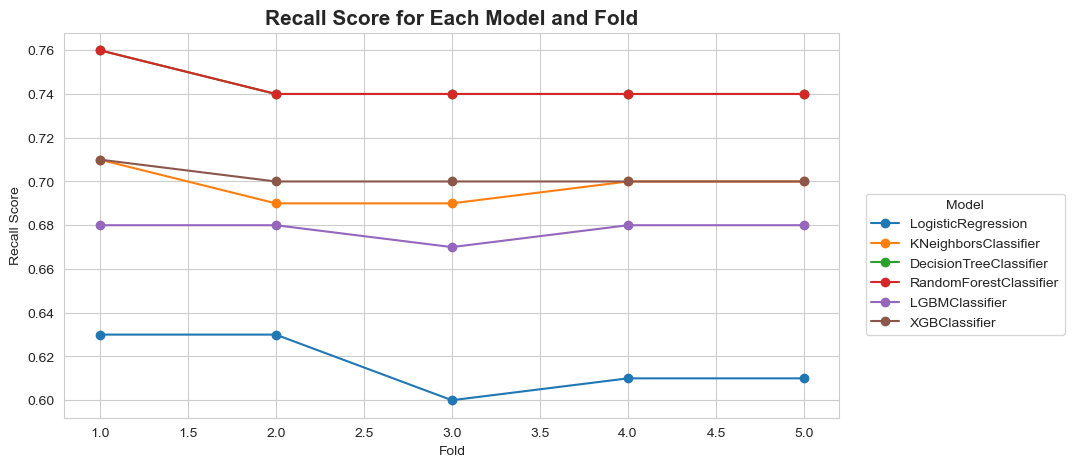

In [483]:
# Line plot for recall scores
plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.plot(range(1, 6), hasil_train['recall_all'][i], marker='o', label=f"{type(model).__name__}")

plt.title('Recall Score for Each Model and Fold', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel('Fold')
plt.ylabel('Recall Score')
plt.legend(title = 'Model',loc = 'best',bbox_to_anchor=(0.8, 0, 0.5, 0.6))
plt.show()

In [484]:
hasil_train

model  f1_score_mean  \
0                LogisticRegression(random_state=42)       0.705699   
1                             KNeighborsClassifier()       0.734054   
2            DecisionTreeClassifier(random_state=42)       0.739613   
3            RandomForestClassifier(random_state=42)       0.792145   
4                    LGBMClassifier(random_state=42)       0.753505   
5  XGBClassifier(base_score=None, booster=None, c...       0.763227   

                     f1_score_all  recall_mean                      recall_all  
0     [0.71, 0.71, 0.7, 0.7, 0.7]     0.617646   [0.63, 0.63, 0.6, 0.61, 0.61]  
1  [0.74, 0.73, 0.73, 0.73, 0.73]     0.699573    [0.71, 0.69, 0.69, 0.7, 0.7]  
2  [0.75, 0.74, 0.74, 0.74, 0.74]     0.744867  [0.76, 0.74, 0.74, 0.74, 0.74]  
3   [0.8, 0.79, 0.79, 0.79, 0.79]     0.743362  [0.76, 0.74, 0.74, 0.74, 0.74]  
4  [0.75, 0.75, 0.75, 0.75, 0.75]     0.677617  [0.68, 0.68, 0.67, 0.68, 0.68]  
5  [0.77, 0.76, 0.76, 0.76, 0.76]     0.700468      [0.71, 0.7, 0.7, 0.7, 0.7]

**Observation**

Berdasarkan hasil cross validation bahwa model yang memiliki performa bagus adalah Random Forest, LGBM dan XGB Classifier. Selanjutnya akan dibandingkan pada hasil test 

## Evaluation

Classification Report : LogisticRegression
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     10405
           1       0.83      0.62      0.71      6135

    accuracy                           0.81     16540
   macro avg       0.82      0.77      0.78     16540
weighted avg       0.81      0.81      0.80     16540



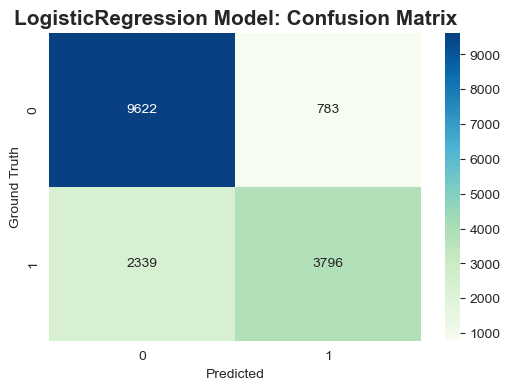

Classification Report : KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.83      0.88      0.86     10405
           1       0.77      0.71      0.74      6135

    accuracy                           0.81     16540
   macro avg       0.80      0.79      0.80     16540
weighted avg       0.81      0.81      0.81     16540



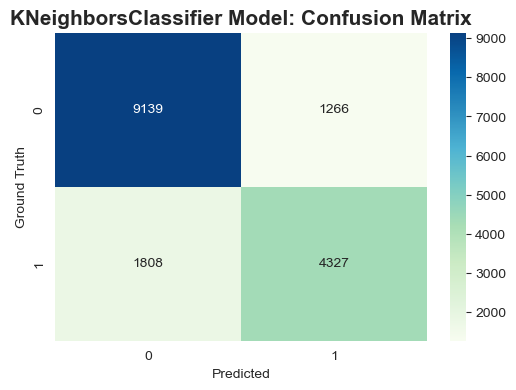

Classification Report : DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10405
           1       0.75      0.75      0.75      6135

    accuracy                           0.81     16540
   macro avg       0.80      0.80      0.80     16540
weighted avg       0.81      0.81      0.81     16540



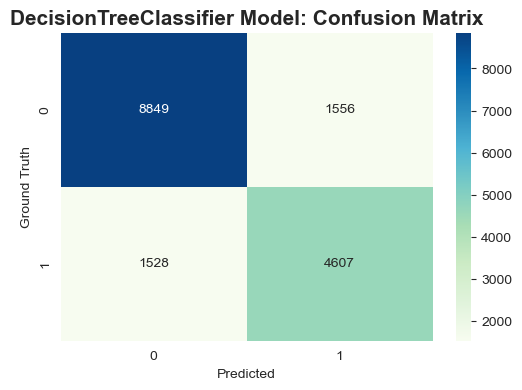

Classification Report : RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     10405
           1       0.85      0.75      0.80      6135

    accuracy                           0.86     16540
   macro avg       0.86      0.84      0.84     16540
weighted avg       0.86      0.86      0.86     16540



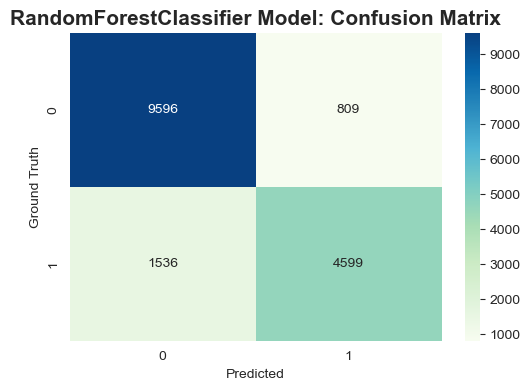

[LightGBM] [Info] Number of positive: 24595, number of negative: 41564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 66159, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371756 -> initscore=-0.524691
[LightGBM] [Info] Start training from score -0.524691
Classification Report : LGBMClassifier
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     10405
           1       0.85      0.68      0.76      6135

    accuracy                           0.84     16540
   macro avg       0.84      0.80      0.82     16540
weighted avg       0.84      0.84      0.83     16540



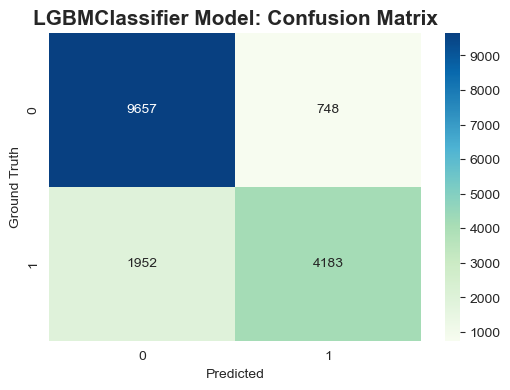

Classification Report : XGBClassifier
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     10405
           1       0.84      0.71      0.77      6135

    accuracy                           0.84     16540
   macro avg       0.84      0.82      0.83     16540
weighted avg       0.84      0.84      0.84     16540



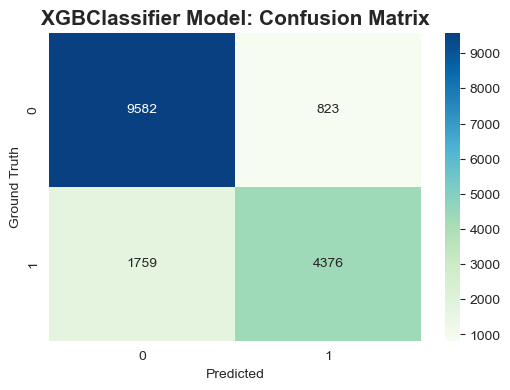

In [559]:
models = [LogisticRegression(random_state=42),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42)]

list_precision = []
list_recall = []
list_f1score = []
auc_list = []
fpr_list = []
tpr_list = []

hasil_test = pd.DataFrame()

for model in models:
    method = str(type(model)).split(".")[-1][:-2]
    
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    print('Classification Report :',method)
    print('='*60)
    print(classification_report(y_test, y_pred_test))
    
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1_scores = f1_score(y_test, y_pred_test)
    
    list_precision.append(precision)
    list_recall.append(recall)
    list_f1score.append(f1_scores)
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(f'{method} Model: Confusion Matrix', fontdict={'fontsize':15, 'fontweight':'bold'})
    plt.show()
    
    # Calculate ROC AUC score
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Compute ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Store fpr, tpr, and AUC for each model
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)
    
    hasil_test = hasil_test.append({
        'model':method,
        'precision':precision,
        'recall':recall,
        'f1_score':f1_scores,
        'AUC_score':round(roc_auc,3)
    }, ignore_index=True)


In [569]:
hasil_test

model  precision    recall  f1_score  AUC_score
0      LogisticRegression   0.829002  0.618745  0.708606      0.858
1    KNeighborsClassifier   0.773646  0.705297  0.737892      0.869
2  DecisionTreeClassifier   0.747526  0.750937  0.749228      0.803
3  RandomForestClassifier   0.850407  0.749633  0.796847      0.926
4          LGBMClassifier   0.848307  0.681826  0.756009      0.907
5           XGBClassifier   0.841700  0.713284  0.772190      0.912

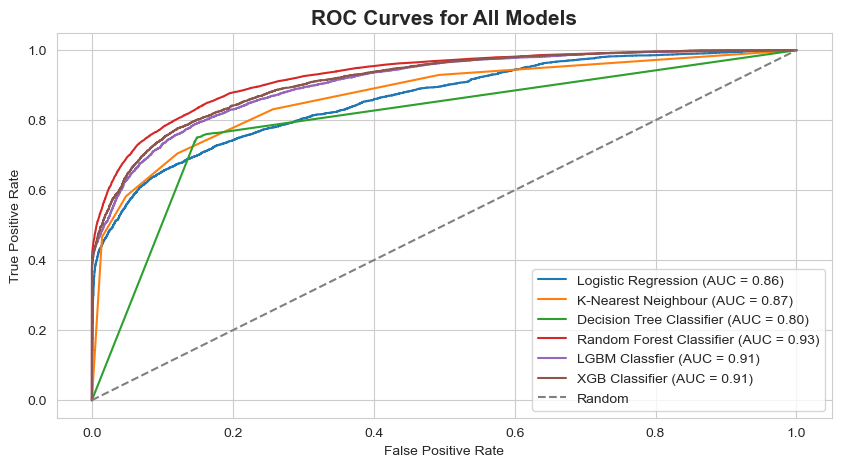

In [561]:
# Plot ROC curves for all models in a single plot
plt.figure(figsize=(10, 5))
models = ['Logistic Regression','K-Nearest Neighbour','Decision Tree Classifier',
          'Random Forest Classifier', 'LGBM Classfier','XGB Classifier']
for i in range(len(models)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'{models[i]} (AUC = {auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.legend(loc='lower right')
plt.show()

**Observation**

- Pada saat di evaluasi menggunakan data test bahwa performa yang baik adalah Random Forest dan XGB Classifier dengan F1 score dan recall diatas 0.70
- Berdasarkan ROC AUC bahwa model yang memiliki performa terbaik yaitu random forest dengan threshold 0.93, semakin tinggi threshold mendekati angka 1 maka semakin baik performa dan prediksinya

Ketiga model terbaik (Random Forest, LGBM, XGB) akan dilakukan hyperparameter Tuning dan dicari yang terbaik

## Hyperparameter Tuning Best Model

In [488]:
def model_hyperparameter(model, parameter, X_train, y_train, X_test, y_test):
    method_test = str(type(model)).split(".")[-1][:-2]  # for the name of the model

    # Train Model
    model_hyper_gridcv = GridSearchCV(model, parameter, cv=5, scoring='f1', n_jobs=-1)
    model_hyper_gridcv.fit(X_train, y_train)

    # Show best estimator
    cv_result = pd.DataFrame(model_hyper_gridcv.cv_results_)
    retain_cols = ['params', 'mean_test_score', 'rank_test_score']
    display(cv_result[retain_cols].sort_values('rank_test_score').head())

    print(f'Best Estimator {(method_test)}: {model_hyper_gridcv.best_params_}')
    

    # Show Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    y_pred = model_hyper_gridcv.best_estimator_.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=model_hyper_gridcv.best_estimator_.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=model_hyper_gridcv.best_estimator_.classes_)
    disp.plot(ax=ax)
    plt.title(f'{method_test} : ConfusionMatrix')
    plt.grid(None)
    plt.show()

    # Calculate ROC AUC score
    y_pred_proba = model_hyper_gridcv.best_estimator_.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{method_test} Model: ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Classification report
    y_preds = model_hyper_gridcv.best_estimator_.predict(X_test)
    print(f'Classification Report : {method_test}')
    print('#' * 60)
    print(classification_report(y_test, y_preds, digits=4))

    return y_preds, fpr, tpr, roc_auc, model_hyper_gridcv

### Random Forest

params  mean_test_score  \
69  {'max_depth': 50, 'min_samples_split': 2, 'n_e...         0.793360   
87  {'max_depth': 100, 'min_samples_split': 2, 'n_...         0.793313   
7   {'max_depth': None, 'min_samples_split': 2, 'n...         0.793313   
86  {'max_depth': 100, 'min_samples_split': 2, 'n_...         0.793216   
6   {'max_depth': None, 'min_samples_split': 2, 'n...         0.793216   

    rank_test_score  
69                1  
87                2  
7                 2  
86                4  
6                 4

Best Estimator RandomForestClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 500}


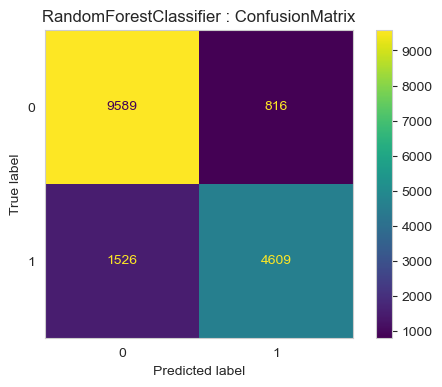

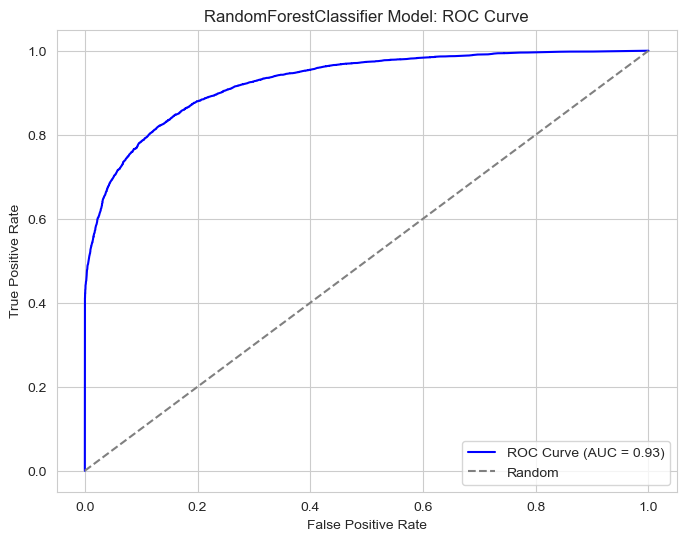

Classification Report : RandomForestClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8627    0.9216    0.8912     10405
           1     0.8496    0.7513    0.7974      6135

    accuracy                         0.8584     16540
   macro avg     0.8561    0.8364    0.8443     16540
weighted avg     0.8578    0.8584    0.8564     16540



In [492]:
parameter = {
        'n_estimators': [100,200,300,400,500],
        'max_depth': [None, 10, 20, 50, 100],
        'min_samples_split': [0, 2, 5, 10]
    }


y_preds, fpr, tpr, roc_auc, model_hyper_gridcv = model_hyperparameter(RandomForestClassifier(random_state=42), parameter, X_train, y_train, X_test, y_test)

In [493]:
y_pred_rf = y_preds
rf_hyper_gridcv = model_hyper_gridcv
fpr_rf, tpr_rf, roc_auc_rf = fpr, tpr, roc_auc

### LGBM Classifier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24595, number of negative: 41564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 66159, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371756 -> initscore=-0.524691
[LightGBM] [Info] Start training from score -0.524691


params  mean_test_score  \
703  {'learning_rate': 0.5, 'max_depth': 9, 'min_ch...         0.779192   
707  {'learning_rate': 0.5, 'max_depth': 9, 'min_ch...         0.779192   
691  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.779128   
687  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.778993   
683  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.778993   

     rank_test_score  
703                1  
707                1  
691                3  
687                4  
683                4

Best Estimator LGBMClassifier: {'learning_rate': 0.5, 'max_depth': 9, 'min_child_weight': 0.001, 'n_estimators': 400, 'objective': 'binary'}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


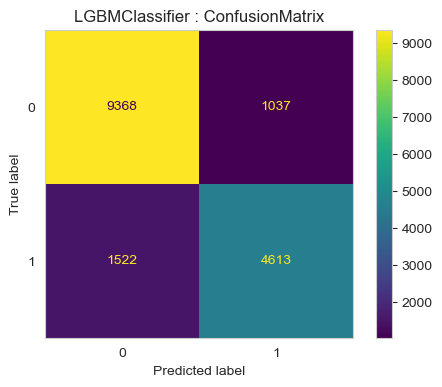

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


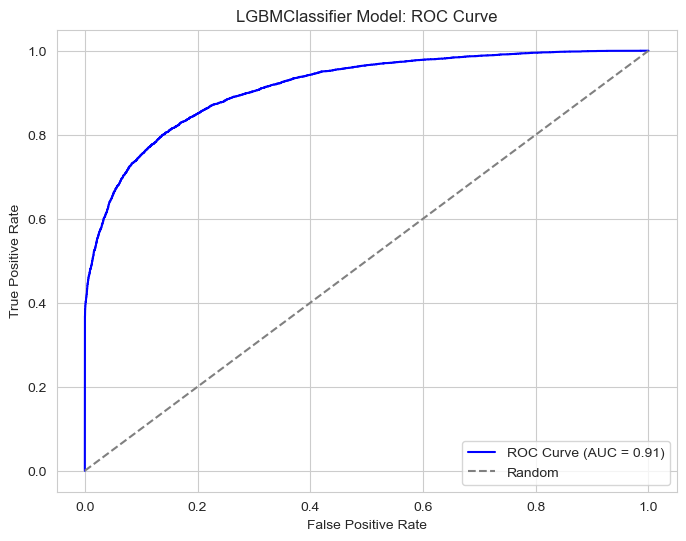

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Classification Report : LGBMClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8602    0.9003    0.8798     10405
           1     0.8165    0.7519    0.7829      6135

    accuracy                         0.8453     16540
   macro avg     0.8383    0.8261    0.8313     16540
weighted avg     0.8440    0.8453    0.8439     16540



In [494]:
parameter = {
        'max_depth': range(1,10),
        'learning_rate': [0.05, 0.01, 0.1, 0.5],
        'n_estimators': range(100,500,100),
        'min_child_weight' : [1e-3, 1e-2, 1e-1, 1, 10],
        'objective': ['binary']
    }


y_preds, fpr, tpr, roc_auc,model_hyper_gridcv = model_hyperparameter(LGBMClassifier(random_state=42), parameter, X_train, y_train, X_test, y_test)

In [495]:
y_pred_lgbm = y_preds
lgbm_hyper_gridcv = model_hyper_gridcv
fpr_lgbm, tpr_lgbm, roc_auc_lgbm = fpr, tpr, roc_auc

### XGB Classifier

params  mean_test_score  \
523  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.787115   
531  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.786762   
527  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.786103   
535  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.785365   
526  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.784866   

     rank_test_score  
523                1  
531                2  
527                3  
535                4  
526                5

Best Estimator XGBClassifier: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 0.001, 'n_estimators': 400, 'objective': 'binary:logistic'}


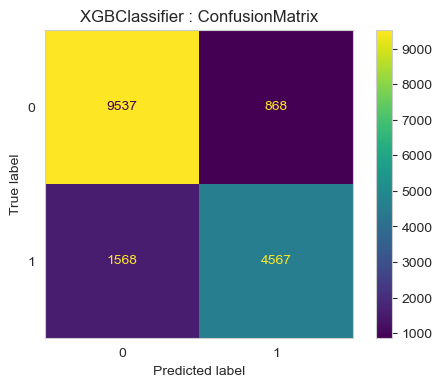

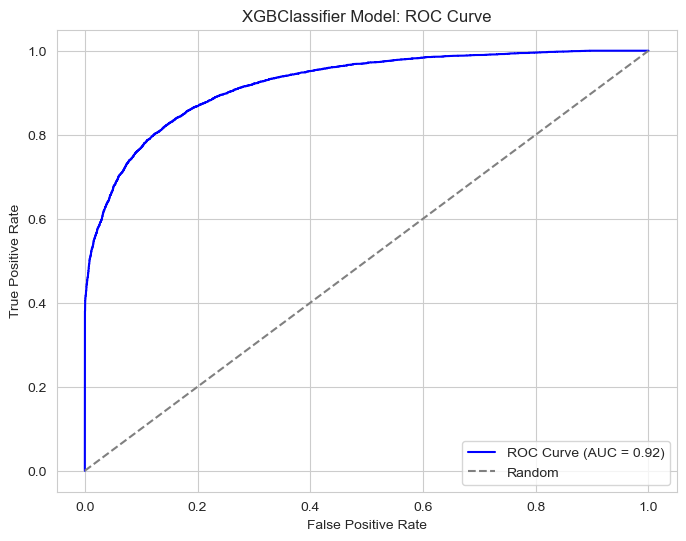

Classification Report : XGBClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8588    0.9166    0.8868     10405
           1     0.8403    0.7444    0.7895      6135

    accuracy                         0.8527     16540
   macro avg     0.8495    0.8305    0.8381     16540
weighted avg     0.8519    0.8527    0.8507     16540



In [496]:
parameter = {
         'max_depth': range(1,10),
        'learning_rate': [0.05, 0.01, 0.1, 0.5],
        'n_estimators': range(100,500,100),
        'min_child_weight' : [1e-3, 1e-2, 1e-1, 1, 10],
        'objective': ['binary:logistic']
    }


y_preds, fpr, tpr, roc_auc, model_hyper_gridcv = model_hyperparameter(XGBClassifier(random_state=42), parameter, X_train, y_train, X_test, y_test)

In [497]:
y_pred_xgb = y_preds
xgb_hyper_gridcv = model_hyper_gridcv
fpr_xgb, tpr_xgb, roc_auc_xgb = fpr, tpr, roc_auc

### Evaluation Hyperparameter Tuning

In [546]:
y_preds= [y_pred_rf,y_pred_lgbm, y_pred_xgb]
roc_auc_list = [roc_auc_rf, roc_auc_lgbm, roc_auc_xgb]
models = ['Random Forest Classifier','LGBM Classifier','XGB Classifier']

hasil_test_hyper = pd.DataFrame(columns= ['Model','Precision Score','Recall Score','F1 Score', 'AUC Score'])

for model, preds, auc in zip(models,y_preds, roc_auc_list):
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1_scores = f1_score(y_test, preds)
    
    hasil_test_hyper = hasil_test_hyper.append({
        'Model' : model,
        'Precision Score' : precision,
        'Recall Score' : recall,
        'F1 Score' : f1_scores,
        'AUC Score' : auc
        }, ignore_index=True)
    
hasil_test_hyper

Model  Precision Score  Recall Score  F1 Score  \
0  Random Forest Classifier         0.849585      0.751263  0.797405   
1           LGBM Classifier         0.816460      0.751915  0.782860   
2            XGB Classifier         0.840294      0.744417  0.789455   

   AUC Score  
0   0.927440  
1   0.914261  
2   0.922708

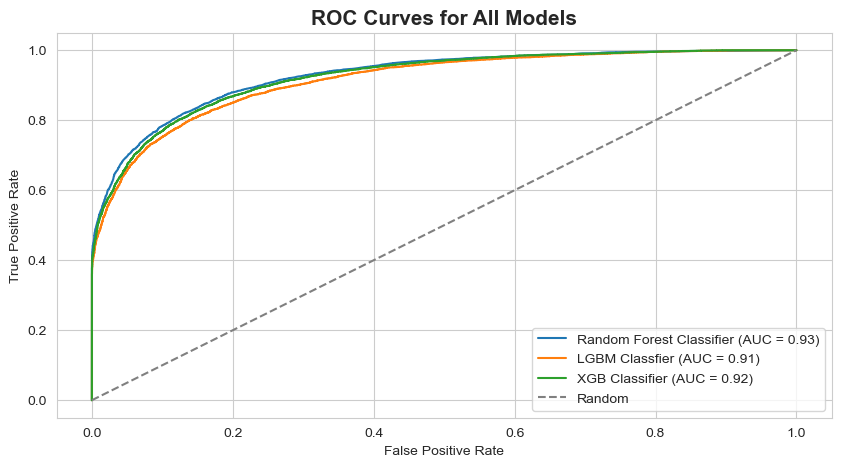

In [547]:
# Plot ROC curves for all models in a single plot
plt.figure(figsize=(10, 5))
models = ['Random Forest Classifier', 'LGBM Classfier','XGB Classifier']
fpr_list_hyper = [fpr_rf,fpr_lgbm,fpr_xgb]
tpr_list_hyper = [tpr_rf, tpr_lgbm, tpr_xgb]
for i in range(len(models)):
    plt.plot(fpr_list_hyper[i], tpr_list_hyper[i], label=f'{models[i]} (AUC = {roc_auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.legend(loc='lower right')
plt.show()

**Observation**

Setelah dilakukan Hyperparameter Tuning ke 3 model (Random Forest, LGBM dan XGB Classifier) bahwa terdapat peningkatan performa dalam prediksi dan dihasilkan bahwa Random Forest memiliki performa yang lebih baik dengan F1 Score 0.798 (0.80) sedangkan LGBM memiliki score recall yang lebih baik yaitu 0.755 dibandingkan Random Forest tetapi selisih hanya 0.01 sehingga disimpulkan model dengan performa terbaik yaitu Random Forest

### Feature Important

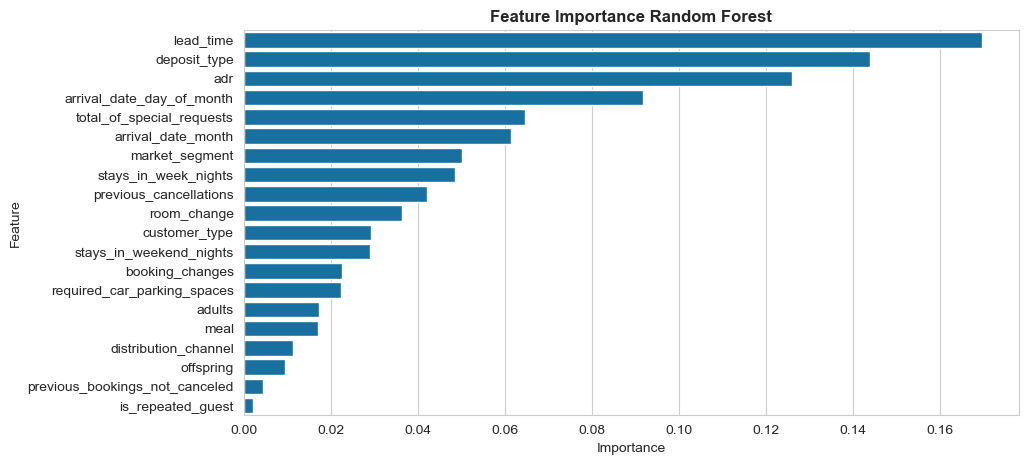

In [178]:
feature_importances = pd.DataFrame(rf_hyper_gridcv.best_estimator_.feature_importances_,
                                   index = fitur_std.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(x='importance', y='index', color='#0077b6',data=feature_importances.reset_index())
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Random Forest', fontdict={'fontweight':'bold'})
plt.show()

**Observation**

Terlihat bahwa 5 fitur yang penting dalam cancelation yaitu `lead_time, deposit_type, adr, arrival_date_day_of_month, total_of_special_requests`. Dari hal tersebut dapat disimpulkan:

- bahwa 

# Modeling Undersampling

In [506]:
from imblearn import under_sampling

In [507]:
X_train_under, y_train_under = under_sampling.RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

Classification Report : LogisticRegression
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     10405
           1       0.71      0.72      0.71      6135

    accuracy                           0.79     16540
   macro avg       0.77      0.77      0.77     16540
weighted avg       0.79      0.79      0.79     16540



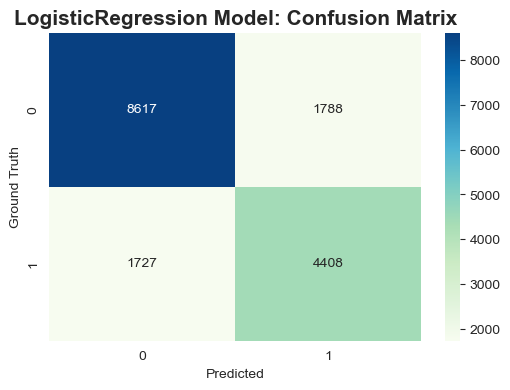

Classification Report : KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     10405
           1       0.69      0.78      0.73      6135

    accuracy                           0.79     16540
   macro avg       0.78      0.79      0.78     16540
weighted avg       0.80      0.79      0.79     16540



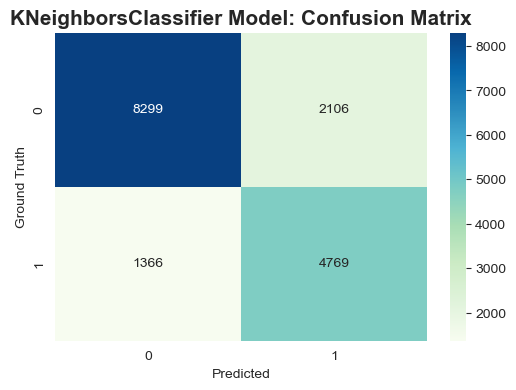

Classification Report : DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.87      0.79      0.83     10405
           1       0.69      0.79      0.74      6135

    accuracy                           0.79     16540
   macro avg       0.78      0.79      0.78     16540
weighted avg       0.80      0.79      0.79     16540



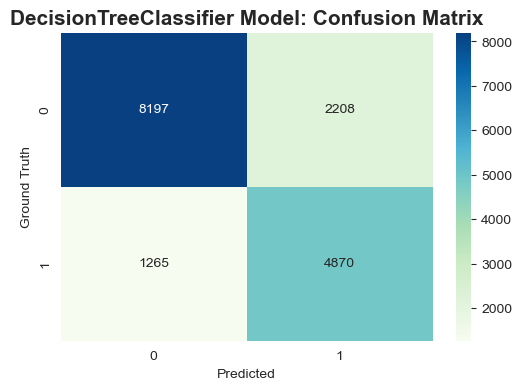

Classification Report : RandomForestClassifier
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     10405
           1       0.77      0.82      0.80      6135

    accuracy                           0.84     16540
   macro avg       0.83      0.84      0.84     16540
weighted avg       0.85      0.84      0.85     16540



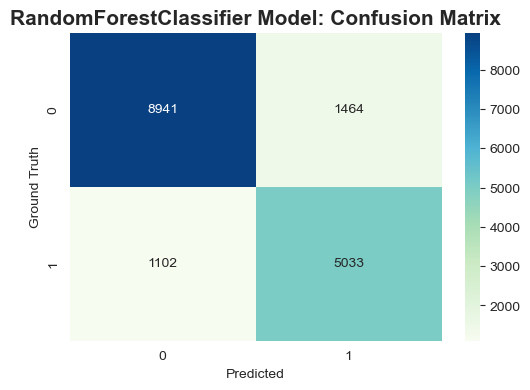

[LightGBM] [Info] Number of positive: 24595, number of negative: 24595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 49190, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report : LGBMClassifier
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     10405
           1       0.77      0.78      0.77      6135

    accuracy                           0.83     16540
   macro avg       0.82      0.82      0.82     16540
weighted avg       0.83      0.83      0.83     16540



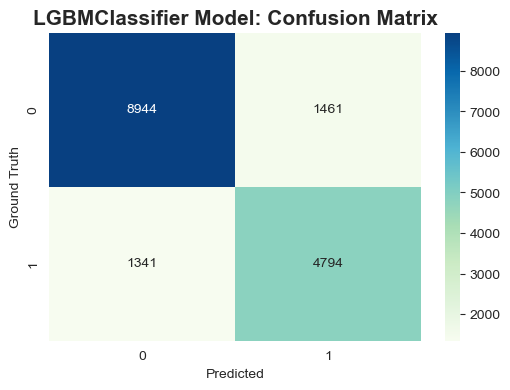

Classification Report : XGBClassifier
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     10405
           1       0.76      0.80      0.78      6135

    accuracy                           0.83     16540
   macro avg       0.82      0.82      0.82     16540
weighted avg       0.83      0.83      0.83     16540



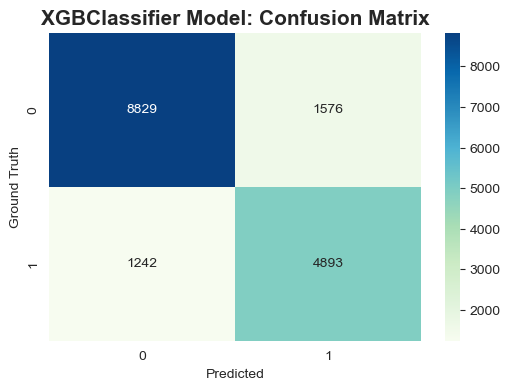

In [572]:
models = [LogisticRegression(random_state=42),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42)]

list_precision = []
list_recall = []
list_f1score = []
auc_list = []
fpr_list = []
tpr_list = []

hasil_test_under = pd.DataFrame()

for model in models:
    method = str(type(model)).split(".")[-1][:-2]
    
    model.fit(X_train_under, y_train_under)
    y_pred_test = model.predict(X_test)
    print('Classification Report :',method)
    print('='*60)
    print(classification_report(y_test, y_pred_test))
    
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1_scores = f1_score(y_test, y_pred_test)
    
    list_precision.append(precision)
    list_recall.append(recall)
    list_f1score.append(f1_scores)
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(f'{method} Model: Confusion Matrix', fontdict={'fontsize':15, 'fontweight':'bold'})
    plt.show()
    
    # Calculate ROC AUC score
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Compute ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Store fpr, tpr, and AUC for each model
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)
    
    hasil_test_under = hasil_test_under.append({
        'model':method,
        'precision':precision,
        'recall':recall,
        'f1_score':f1_scores,
        'AUC_score':round(roc_auc,3)
    }, ignore_index=True)

## Evaluation Model Undersampling

In [573]:
hasil_test_under

model  precision    recall  f1_score  AUC_score
0      LogisticRegression   0.711427  0.718500  0.714946      0.857
1    KNeighborsClassifier   0.693673  0.777343  0.733128      0.866
2  DecisionTreeClassifier   0.688047  0.793806  0.737153      0.792
3  RandomForestClassifier   0.774665  0.820375  0.796865      0.923
4          LGBMClassifier   0.766427  0.781418  0.773850      0.906
5           XGBClassifier   0.756377  0.797555  0.776420      0.910

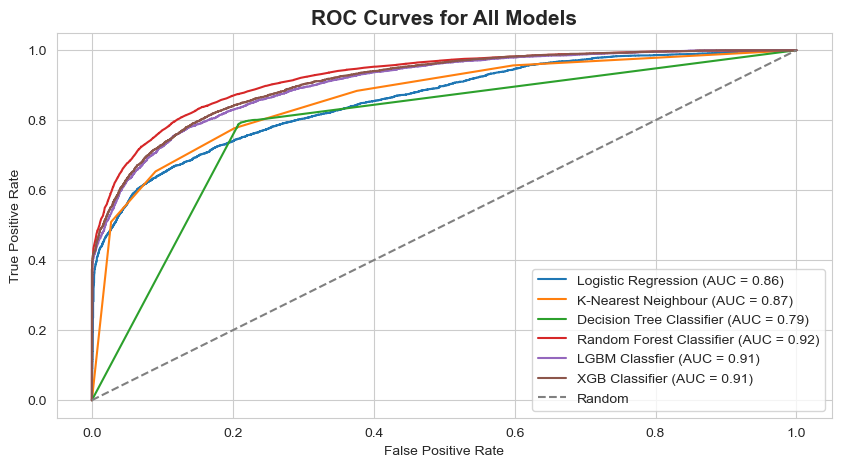

In [519]:
# Plot ROC curves for all models in a single plot
plt.figure(figsize=(10, 5))
models = ['Logistic Regression','K-Nearest Neighbour','Decision Tree Classifier',
          'Random Forest Classifier', 'LGBM Classfier','XGB Classifier']
for i in range(len(models)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'{models[i]} (AUC = {auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.legend(loc='lower right')
plt.show()

## Hyperparameter Tuning Best Model After Undersampling

In [529]:
def model_hyperparameter(model, parameter, X_train, y_train, X_test, y_test):
    method_test = str(type(model)).split(".")[-1][:-2]  # for the name of the model

    # Train Model
    model_under_hyper_gridcv = GridSearchCV(model, parameter, cv=5, scoring='f1', n_jobs=-1)
    model_under_hyper_gridcv.fit(X_train, y_train)

    # Show best estimator
    cv_result = pd.DataFrame(model_under_hyper_gridcv.cv_results_)
    retain_cols = ['params', 'mean_test_score', 'rank_test_score']
    display(cv_result[retain_cols].sort_values('rank_test_score').head())

    print(f'Best Estimator {(method_test)}: {model_under_hyper_gridcv.best_params_}')
    

    # Show Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    y_pred = model_under_hyper_gridcv.best_estimator_.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=model_under_hyper_gridcv.best_estimator_.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=model_under_hyper_gridcv.best_estimator_.classes_)
    disp.plot(ax=ax)
    plt.title(f'{method_test} : ConfusionMatrix')
    plt.grid(None)
    plt.show()

    # Calculate ROC AUC score
    y_pred_proba = model_under_hyper_gridcv.best_estimator_.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{method_test} Model: ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Classification report
    y_preds = model_under_hyper_gridcv.best_estimator_.predict(X_test)
    print(f'Classification Report : {method_test}')
    print('#' * 60)
    print(classification_report(y_test, y_preds, digits=4))

    return y_preds, fpr, tpr, roc_auc, model_under_hyper_gridcv

### Random Forest

params  mean_test_score  \
67  {'max_depth': 50, 'min_samples_split': 2, 'n_e...         0.836103   
68  {'max_depth': 50, 'min_samples_split': 2, 'n_e...         0.835921   
87  {'max_depth': 100, 'min_samples_split': 2, 'n_...         0.835895   
7   {'max_depth': None, 'min_samples_split': 2, 'n...         0.835895   
94  {'max_depth': 100, 'min_samples_split': 5, 'n_...         0.835848   

    rank_test_score  
67                1  
68                2  
87                3  
7                 3  
94                5

Best Estimator RandomForestClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 300}


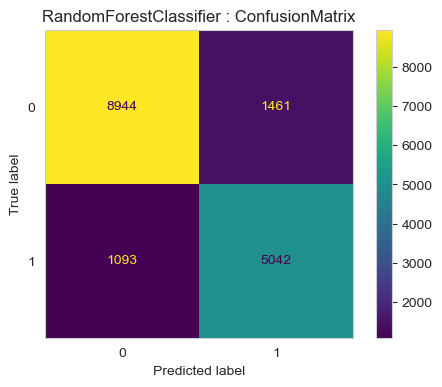

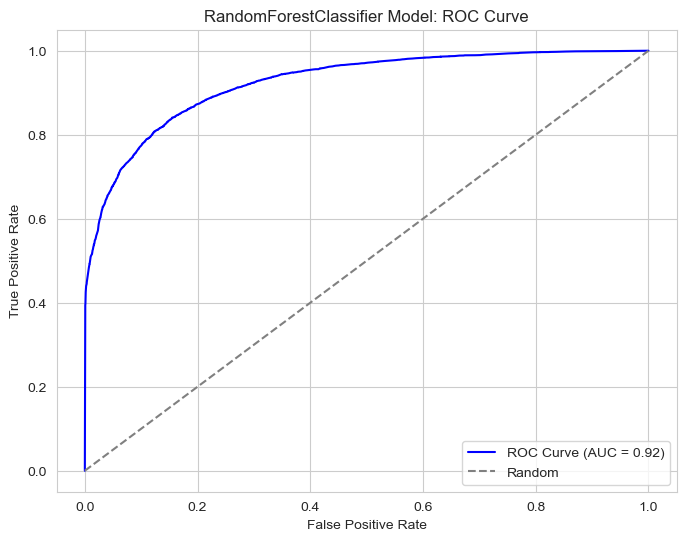

Classification Report : RandomForestClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8911    0.8596    0.8751     10405
           1     0.7753    0.8218    0.7979      6135

    accuracy                         0.8456     16540
   macro avg     0.8332    0.8407    0.8365     16540
weighted avg     0.8482    0.8456    0.8464     16540



In [530]:
parameter = {
        'n_estimators': [100,200,300,400,500],
        'max_depth': [None, 10, 20, 50, 100],
        'min_samples_split': [0, 2, 5, 10]
    }


y_preds, fpr, tpr, roc_auc, model_under_hyper_gridcv = model_hyperparameter(RandomForestClassifier(random_state=42), parameter, X_train_under, y_train_under, X_test, y_test)

In [531]:
y_pred_rf_under = y_preds
rf_under_hyper_gridcv = model_under_hyper_gridcv
fpr_rf_under, tpr_rf_under, roc_auc_rf_under = fpr, tpr, roc_auc

### LGBM Classifier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24595, number of negative: 24595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 49190, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


params  mean_test_score  \
694  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.824227   
695  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.823893   
683  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.823279   
687  {'learning_rate': 0.5, 'max_depth': 8, 'min_ch...         0.823279   
503  {'learning_rate': 0.1, 'max_depth': 8, 'min_ch...         0.822968   

     rank_test_score  
694                1  
695                2  
683                3  
687                3  
503                5

Best Estimator LGBMClassifier: {'learning_rate': 0.5, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'binary'}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


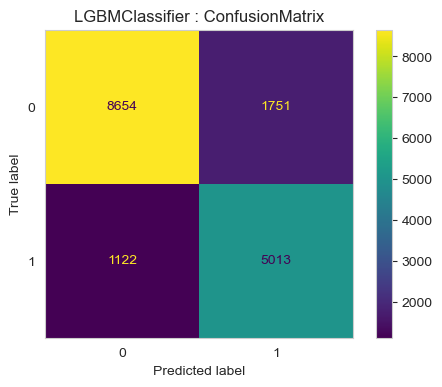

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


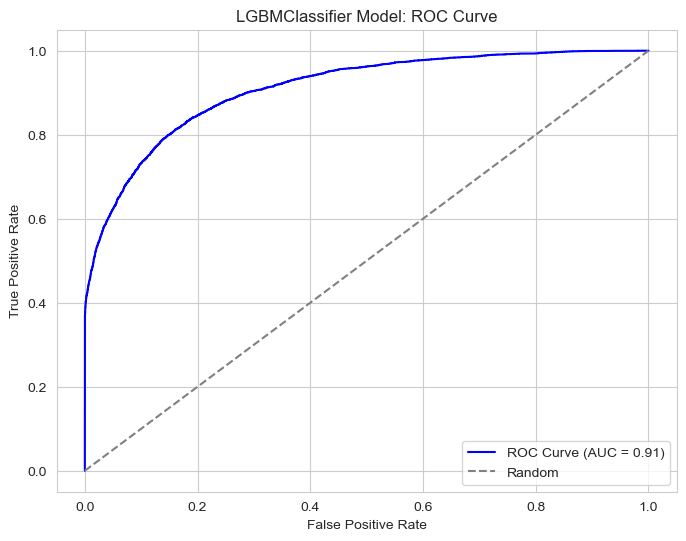

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Classification Report : LGBMClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8852    0.8317    0.8576     10405
           1     0.7411    0.8171    0.7773      6135

    accuracy                         0.8263     16540
   macro avg     0.8132    0.8244    0.8175     16540
weighted avg     0.8318    0.8263    0.8278     16540



In [533]:
parameter = {
        'max_depth': range(1,10),
        'learning_rate': [0.05, 0.01, 0.1, 0.5],
        'n_estimators': range(100,500,100),
        'min_child_weight' : [1e-3, 1e-2, 1e-1, 1, 10],
        'objective': ['binary']
    }


y_preds, fpr, tpr, roc_auc,model_under_hyper_gridcv = model_hyperparameter(LGBMClassifier(random_state=42), parameter, X_train_under, y_train_under, X_test, y_test)

In [534]:
y_pred_lgbm_under = y_preds
lgbm_under_hyper_gridcv = model_under_hyper_gridcv
fpr_lgbm_under, tpr_lgbm_under, roc_auc_lgbm_under = fpr, tpr, roc_auc

### XGB Classifier

params  mean_test_score  \
527  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.831198   
523  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.830653   
531  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.829968   
522  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.829528   
535  {'learning_rate': 0.1, 'max_depth': 9, 'min_ch...         0.828920   

     rank_test_score  
527                1  
523                2  
531                3  
522                4  
535                5

Best Estimator XGBClassifier: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 0.01, 'n_estimators': 400, 'objective': 'binary:logistic'}


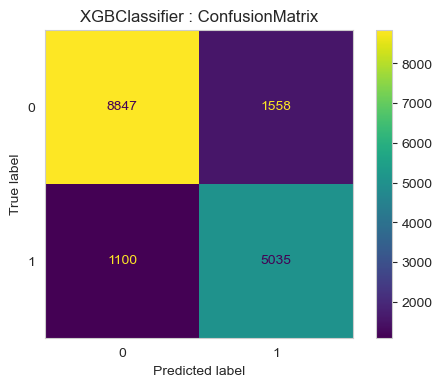

Classification Report : XGBClassifier
############################################################
              precision    recall  f1-score   support

           0     0.8894    0.8503    0.8694     10405
           1     0.7637    0.8207    0.7912      6135

    accuracy                         0.8393     16540
   macro avg     0.8266    0.8355    0.8303     16540
weighted avg     0.8428    0.8393    0.8404     16540



In [535]:
parameter = {
         'max_depth': range(1,10),
        'learning_rate': [0.05, 0.01, 0.1, 0.5],
        'n_estimators': range(100,500,100),
        'min_child_weight' : [1e-3, 1e-2, 1e-1, 1, 10],
        'objective': ['binary:logistic']
    }


y_preds, fpr, tpr, roc_auc, model_under_hyper_gridcv = model_hyperparameter(XGBClassifier(random_state=42), parameter, X_train_under, y_train_under, X_test, y_test)

In [536]:
y_pred_xgb_under = y_preds
xgb_under_hyper_gridcv = model_under_hyper_gridcv
fpr_xgb_under, tpr_xgb_under, roc_auc_xgb_under = fpr, tpr, roc_auc

### Evaluation Hyperparameter Tuning Undersampling

In [548]:
y_preds= [y_pred_rf_under,y_pred_lgbm_under, y_pred_xgb_under]
roc_auc_list = [roc_auc_rf_under, roc_auc_lgbm_under, roc_auc_xgb_under]
models = ['Random Forest Classifier','LGBM Classifier','XGB Classifier']

hasil_test_hyper_under = pd.DataFrame(columns= ['Model','Precision Score','Recall Score','F1 Score', 'AUC Score'])

for model, preds, auc in zip(models,y_preds, roc_auc_list):
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1_scores = f1_score(y_test, preds)
    
    hasil_test_hyper_under = hasil_test_hyper_under.append({
        'Model' : model,
        'Precision Score' : precision,
        'Recall Score' : recall,
        'F1 Score' : f1_scores,
        'AUC Score' : auc
        }, ignore_index=True)
    
hasil_test_hyper_under

Model  Precision Score  Recall Score  F1 Score  \
0  Random Forest Classifier         0.775334      0.821842  0.797911   
1           LGBM Classifier         0.741130      0.817115  0.777270   
2            XGB Classifier         0.763689      0.820701  0.791169   

   AUC Score  
0   0.924428  
1   0.909910  
2   0.919413

In [549]:
# Plot ROC curves for all models in a single plot
plt.figure(figsize=(10, 5))
models = ['Random Forest Classifier', 'LGBM Classfier','XGB Classifier']
fpr_list_hyper_under = [fpr_rf_under,fpr_lgbm_under,fpr_xgb_under]
tpr_list_hyper_under = [tpr_rf_under, tpr_lgbm_under, tpr_xgb_under]
for i in range(len(models)):
    plt.plot(fpr_list_hyper_under[i], tpr_list_hyper_under[i], label=f'{models[i]} (AUC = {roc_auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models',fontdict={'fontsize':15, 'fontweight':'bold'})
plt.legend(loc='lower right')
plt.show()

### Feature Important

In [545]:
feature_importances = pd.DataFrame(rf_under_hyper_gridcv.best_estimator_.feature_importances_,
                                   index = fitur_std.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(x='importance', y='index', color='#0077b6',data=feature_importances.reset_index())
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Random Forest', fontdict={'fontweight':'bold'})
plt.show()

**Observation**

Terlihat 5 fitur importance dari model Random Forest, yaitu:

lead_time, adr, deposit_type, arrival_date_day_of_month, total_of_special_request

- Melalui lead_time, terlihat bahwa semakin lama guest booking dari check-in date, maka semakin tinggi cancellation. Sebaliknya, guest yang booking dekat dengan check-in date semakin jarang untuk cancel. Hal ini terjadi karena guest yang booking dekat dengan tanggal check-in pasti lebih yakin untuk stay

- Melalui adr, terlihat bahwa semakin tinggi adr, guest semakin banyak yang cancel. Namun, pada suatu titik adr, cancellation rate menjadi tetap.

- Melalui deposit_type, terlihat bahwa jenis deposit type mempengaruhi dari tingkat cancel terutama untuk deposit type non refund, pesanan otomatis lebih sedikit karena pemesan menghindari pembatalan tiket dan uangnya tidak kembali sedangkan untuk non deposit. diharapkan pihak hotel menerapkan sistem DP untuk para pemesan sehingga dapat memastikan bahwa pemesan tidak hanya asal booking saja tetapi memang benar-benar akan menginap

- Melalui arrival_date_day_of_month, terlihat bahwa tanggal mempengaruhi jumlah pemesanan hotel, pemesanan yang tinggi terjadi pada tanggal dimana harinya adalah weekdays dengan pesanan yang tinggi tersebut kemungkinan cancel terjadi pun akan tinggi

- Melalui total_of_special_request, terlihat bahwa semakin banyak request yang dimiliki oleh guest, semakin jarang guest cancel. Hal ini menunjukkan bahwa guest yang memiliki special request adalah guest yang memang niat untuk stay, sedangkan guest yang tidak memiliki special request bisa jadi adalah guest yang asal-asalan booking saja

In [579]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title(f'Random Forest Model: Confusion Matrix', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

In [580]:
false_negatives = cm[1, 0]  # Jumlah False Negatives
true_positives = cm[1, 1]   # Jumlah True Positives

fnr = false_negatives / (false_negatives + true_positives)
print("False Negative Rate (FNR):", fnr)

False Negative Rate (FNR): 0.17815810920945396


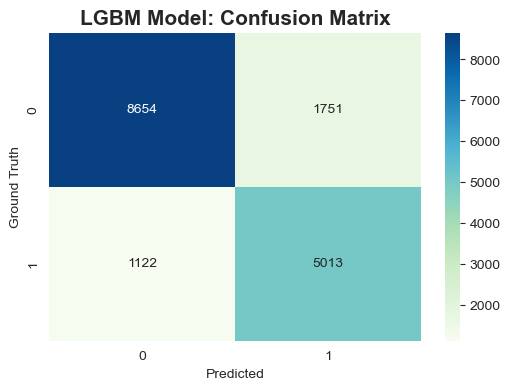

In [583]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title(f'LGBM Model: Confusion Matrix', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

In [584]:
false_negatives = cm[1, 0]  # Jumlah False Negatives
true_positives = cm[1, 1]   # Jumlah True Positives

fnr = false_negatives / (false_negatives + true_positives)
print("False Negative Rate (FNR):", fnr)

False Negative Rate (FNR): 0.18288508557457211


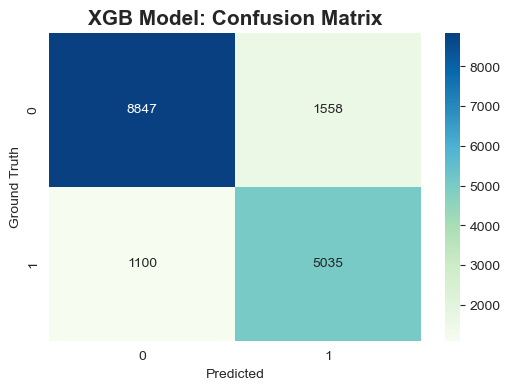

In [585]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title(f'XGB Model: Confusion Matrix', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.show()

In [586]:
false_negatives = cm[1, 0]  # Jumlah False Negatives
true_positives = cm[1, 1]   # Jumlah True Positives

fnr = false_negatives / (false_negatives + true_positives)
print("False Negative Rate (FNR):", fnr)

False Negative Rate (FNR): 0.17929910350448247


**Observation**

Model Random Forest memiliki false Negatif rate lebih kecil dibandingkan model lain yaitu sebesar 17.8%

# Comparison

## Base Model

In [576]:
base_model_comparison = hasil_test.merge(hasil_test_under, how='inner', on='model',suffixes= ['_base','_under'])
column = ['model','precision_base','precision_under','recall_base','recall_under',
          'f1_score_base','f1_score_under','AUC_score_base','AUC_score_under']
base_model_comparison[column]

model  precision_base  precision_under  recall_base  \
0      LogisticRegression        0.829002         0.711427     0.618745   
1    KNeighborsClassifier        0.773646         0.693673     0.705297   
2  DecisionTreeClassifier        0.747526         0.688047     0.750937   
3  RandomForestClassifier        0.850407         0.774665     0.749633   
4          LGBMClassifier        0.848307         0.766427     0.681826   
5           XGBClassifier        0.841700         0.756377     0.713284   

   recall_under  f1_score_base  f1_score_under  AUC_score_base  \
0      0.718500       0.708606        0.714946           0.858   
1      0.777343       0.737892        0.733128           0.869   
2      0.793806       0.749228        0.737153           0.803   
3      0.820375       0.796847        0.796865           0.926   
4      0.781418       0.756009        0.773850           0.907   
5      0.797555       0.772190        0.776420           0.912   

   AUC_score_under  
0            0.857  
1            0.866  
2            0.792  
3            0.923  
4            0.906  
5            0.910

## Hyperparameter Tuning Model

In [577]:
hyper_model_comparison = hasil_test_hyper.merge(hasil_test_hyper_under, how='inner', on='Model',suffixes= ['_base','_under'])
column = ['Model','Precision Score_base','Precision Score_under','Recall Score_base','Recall Score_under',
          'F1 Score_base','F1 Score_under','AUC Score_base','AUC Score_under']
hyper_model_comparison[column]

Model  Precision Score_base  Precision Score_under  \
0  Random Forest Classifier              0.849585               0.775334   
1           LGBM Classifier              0.816460               0.741130   
2            XGB Classifier              0.840294               0.763689   

   Recall Score_base  Recall Score_under  F1 Score_base  F1 Score_under  \
0           0.751263            0.821842       0.797405        0.797911   
1           0.751915            0.817115       0.782860        0.777270   
2           0.744417            0.820701       0.789455        0.791169   

   AUC Score_base  AUC Score_under  
0        0.927440         0.924428  
1        0.914261         0.909910  
2        0.922708         0.919413

# Conclusion

Dalam hal ini, kita perlu memerhatikan beberapa metric evaluation :

Precision : Untuk mengetahui keakuratan model dalam menentukan pesanan yang akan cancel.
Recall : Untuk mengetahui banyaknya kesalahan dalam menentukan cancel (dilihat recall kecil)

Perbandingan antara model menggunakan undersampling dan tidak, sangat kecil peningkatan recall terjadi pada model yang dilakukan undersampling tetapi untuk precision mengalami penurunan. Sedangkan base model precision tinggi tetapi recall lebih kecil dibandingkan model dilakukan undersampling. F1 Score mengalami sedikit peningkatan untuk Random Forest dan XGB menggunakan model undersampling sedangkan LGBM mengalami sedikit penurunan

Maka dari itu, model terbaik adalah Random Forest

Memiliki nilai precision 0.78. Artinya dari 100 yang di prediksi akan cancel, 78 benar cancel.
Memiliki nilai recall 0.82. Artinya, dari 100 orang yang cancel, model dapat memprediksi 82 orang yang benar-benar cancel.